In [10]:
def train_and_submit(train_70, train_30, test, feats, global_min, 
                     model, params,
                     file_sufix= '', opis='', subfolder='', 
                     learning_curve = False, add_model_column_min = -1, total = None,  
                     save_min=7000, kaggle_min=-1):
    import pandas as pd
    import numpy as np
    from datetime import datetime
    from sklearn.metrics import r2_score, mean_absolute_error
    from scikitplot.estimators import plot_learning_curve

    train_70[feats]
    train_30[feats]
    test[['car_id', *feats]]

    
    time_model_start = datetime.now().strftime("%H:%M:%S")
    
    X_train = train_70[ feats ].values
    y_train = train_70['price_value'].values
    y_train_log = np.log(y_train)

    if params is not None: 
        model = model(**params)
    model.fit(X_train, y_train_log)

    ## check 
    y_train_pred_log = model.predict(train_30[ feats ].values)
    y_train_pred = np.exp(y_train_pred_log)
    y_train_pred[ y_train_pred < global_min] = global_min
    y_train_pred

    mae = mean_absolute_error(train_30['price_value'].values, y_train_pred)
    r2 = r2_score(train_30['price_value'].values, y_train_pred)
    print(f'mea: {mae}')
    print(f'r2: {r2}')

    ## add_model_column
    model_cl = 'model_' + type(model).__name__ + "_{:.5f}_".format(mae).replace('.', '_') + file_sufix
    if mae <= add_model_column_min and total is not None: 
        X_total = total[feats].values
        y_pred_log = model.predict(X_total)
        y_pred = np.exp(y_pred_log)
        y_pred[ y_pred < global_min] = global_min
        total[model_cl] = y_pred

    learning_curve_plot = None
    if learning_curve: 
        print("Learning curve for: " + type(model).__name__)
        learning_curve_plot = plot_learning_curve(model, X_train, y_train, cv=3, random_state=0, shuffle=True)

    time_model_end = datetime.now().strftime("%H:%M:%S")

    try:
        if mae <= save_min:
            save_model(file_sufix, subfolder, test, feats, global_min, 
                       model, mae, r2,
                       details = {"mean_absolute_error" : mae, "r2_score" : r2, 
                                  "vars": ("'"+ "', '".join(list(feats))+"'"), 
                                  "best_params" : params,
                                  "model_start" : time_model_start, "model_end" : time_model_end, 
                                  "opis" : opis}, 
                       learning_curve_plot = learning_curve_plot if learning_curve else None, hist_plt=None,
                       kaggle=(mae < kaggle_min))
    except: 
        print('Error on save!')
        
    return mae, r2, model, model_cl, learning_curve_plot

def save_model(file_sufix, subfolder, test, feats, global_min, model, mae=0.0, r2=0.0,
               details='', learning_curve_plot=None, hist_plt=None, kaggle=None):
    
    from kaggle.api.kaggle_api_extended import KaggleApi
    kaggle_api = KaggleApi()
    kaggle_api.authenticate()
    
    import json
    import pandas as pd
    import numpy as np

    test['car_id']
    
    ## predict test
    X_test = test[feats].values
    y_pred_log = model.predict(X_test)
    y_pred = np.exp(y_pred_log)
    y_pred[ y_pred < global_min] = global_min
    test['price_value'] = y_pred
#     result = pd.concat([test['car_id'], y_pred], axis=1)
#     result = test['car_id']
#     result['price_value'] = y_pred

    
    file_name = 'output_model/' + subfolder + '/' \
        + ('' if mae==0.0 else "mae_{:.5f}_".format(mae).replace('.', '_')) \
        + ('' if r2==0.0 else "r2_{:.5f}_".format(r2).replace('.', '_')) \
        + type(model).__name__ + '_' \
        + file_sufix + '.csv'
        
    test[['car_id','price_value']].to_csv(file_name, index=False)
#     test = test.drop(['price_value_log', 'price_value_pln_log_transl','price_value_pln','price_value'],
#                            axis=1, errors='ignore')

    message = json.dumps(details, ensure_ascii=False, indent=4)
    with open(file_name.replace('.csv','.txt'), 'w') as outfile: 
        outfile.write(message)
    
    if learning_curve_plot is not None:
        learning_curve_plot.get_figure().savefig(file_name.replace('.csv','_lc.png'), bbox_inches='tight')

    if hist_plt is not None:
        hist_plt.savefig(file_name.replace('.csv','_hist.png'), bbox_inches='tight')

    if kaggle and details is not None:
        print(message)
        kaggle_api.competition_submit(file_name.replace('~/pml7/konkurs/', ''), message, 'dw-car-price-prediction')
        leaderboard = kaggle_api.competition_view_leaderboard('dw-car-price-prediction')
        print(pd.DataFrame(leaderboard['submissions'])[['teamName', 'submissionDate', 'score']].head())


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_cat(df, var):
    plt.figure(figsize=(20,8))

    plt.subplot(1,2,1)
    plt.title('Histogram')
    sns.countplot(df[var], palette=("cubehelix"))

    plt.subplot(1,2,2)
    plt.title(var + ' vs Price')
    sns.boxplot(x=df[var], y=df['price_value_log'], palette=("cubehelix"))

    plt.show()

def print_plots_by_type(total, type = [np.object, bool], min_c = 9.0, max_c = 100., max_values=30): 
    index = 0
    for cl in total.columns[2:]:
        index += 1
        if total[cl].dtype in type:
            rows = len(total.index)
            nas = rows - total[cl].isna().sum()
            nas_perc = nas/rows*100
            values = len(total[cl].value_counts())
            print(str(index) + ': ' + cl + " [{:.2f}%=".format(nas_perc) + str(nas) + '/' + str(rows) + ' #' + str(values) + ']: ')
            if max_c >= nas_perc >= min_c: 
                if 1 < values < max_values:
                    print(total[cl].value_counts())
                    plot_cat(total, cl)
                    plt.clf()
                    plt.cla()
                    plt.close()


In [12]:
from mozo import compare_and_combine_2, Diff, merge_with_features, num_to_range_categories
import pandas as pd
import numpy as np
np.random.seed(0)

import xgboost as xgb

from scipy import stats
import math 
import datetime 

from sklearn.metrics import r2_score, mean_absolute_error


In [13]:
total = pd.read_csv('~/pml7/konkurs/output/newest_total_20201030_16_24.h5.csv')
total.info(verbose=True)

/home/conda/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (3,86,161) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160616 entries, 0 to 160615
Data columns (total 199 columns):
 #   Column                                              Dtype  
---  ------                                              -----  
 0   breadcrumb                                          object 
 1   created_at                                          object 
 2   price_currency                                      object 
 3   price_details                                       object 
 4   price_value                                         float64
 5   seller_address                                      object 
 6   seller_name                                         object 
 7   seller_type                                         object 
 8   feature_czujniki_parkowania_przednie                bool   
 9   feature_poduszka_powietrzna_chroniąca_kolana        bool   
 10  feature_kurtyny_powietrzne                          bool   
 11  feature_klimatyzacja_dwustrefowa      

1: price_currency [100.00%=160616/160616]: 
PLN    160288
EUR       328
Name: price_currency, dtype: int64


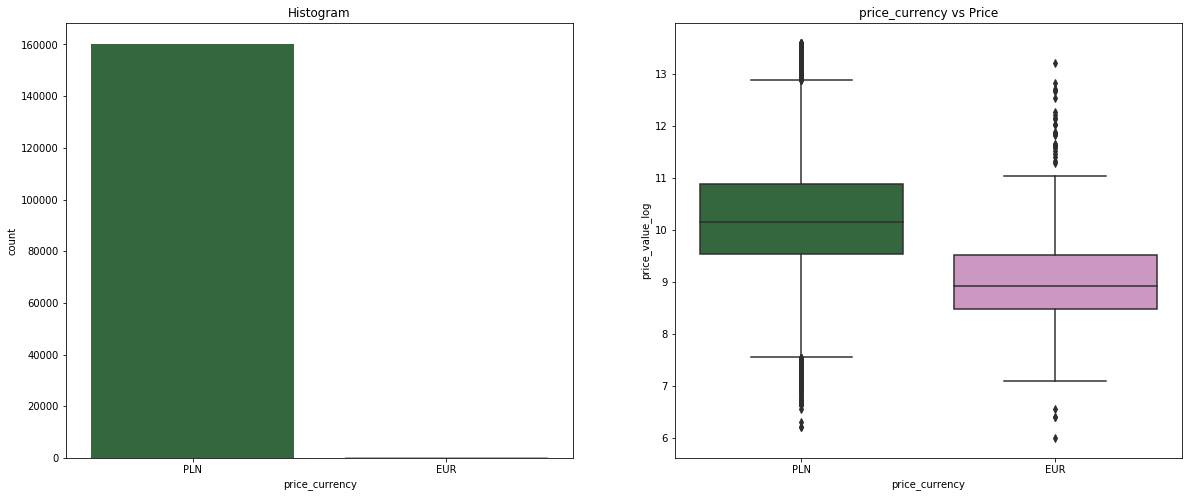

2: price_details [66.30%=106494/160616]: 
Cena Brutto, Do negocjacji                                                    49422
Cena Brutto                                                                   29148
Cena Brutto, Faktura VAT                                                      13781
Cena Brutto, Do negocjacji, Faktura VAT                                        7528
Cena Netto, Faktura VAT                                                        2828
Cena Netto, Do negocjacji, Faktura VAT                                         2277
Cena Netto                                                                      716
Cena Netto, Do negocjacji                                                       685
Brutto                                        , Do negocjacji                    51
Brutto                                                                           27
Brutto                    , Faktura VAT                    , Do negocjacji       10
Brutto                    , Faktur

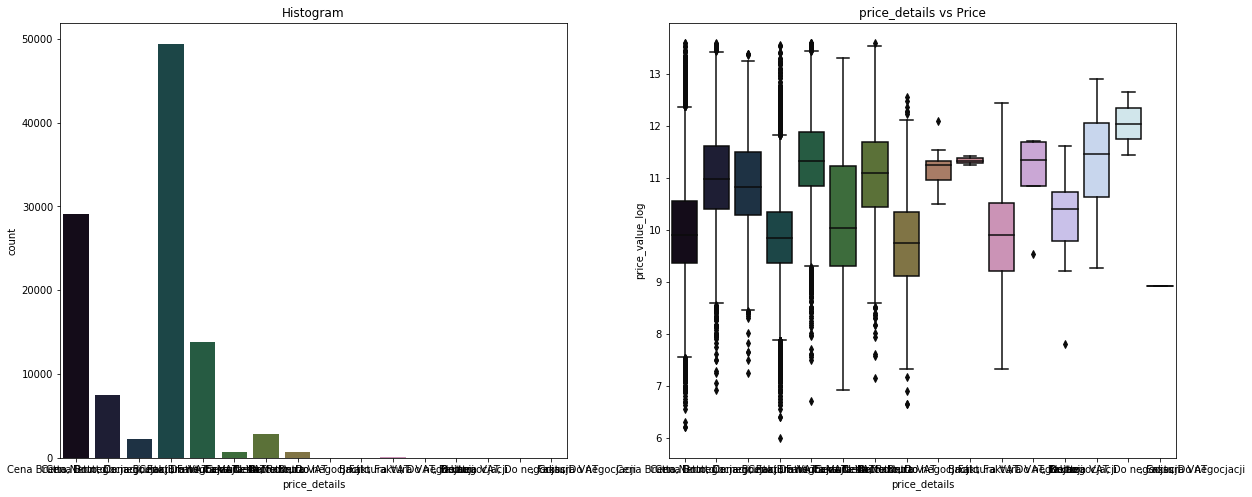

4: seller_address [99.90%=160455/160616]: 
5: seller_name [60.53%=97228/160616]: 
6: seller_type [99.90%=160455/160616]: 
Dealer            97228
Osoba prywatna    63227
Name: seller_type, dtype: int64


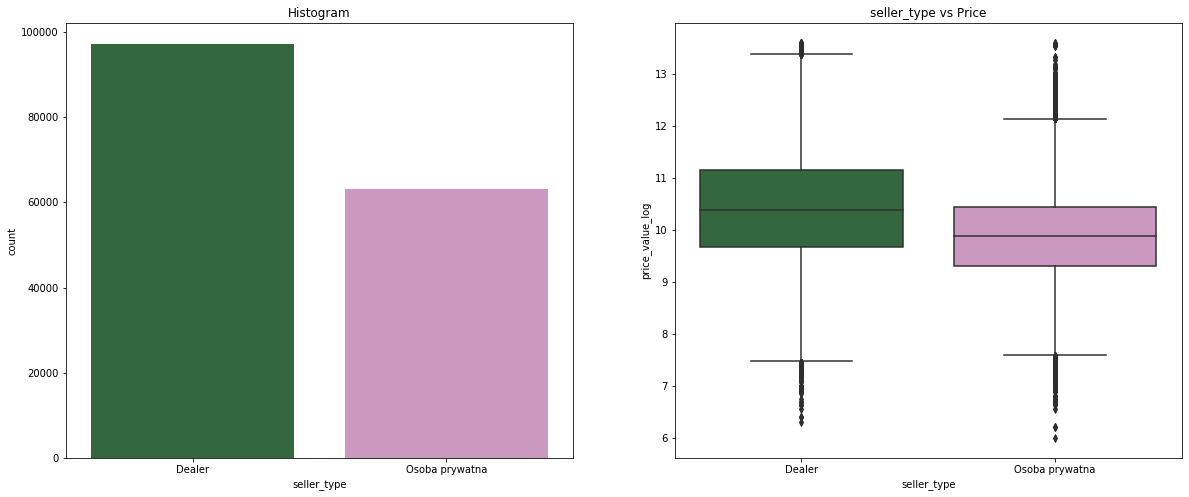

78: param_vin [22.23%=35701/160616]: 
81: param_kategoria [99.90%=160455/160616]: 
83: param_wartość_wykupu [0.25%=407/160616]: 
85: param_liczba_pozostałych_rat [0.28%=442/160616]: 
86: param_oferta_od [99.90%=160455/160616]: 
Firmy              97223
Osoby prywatnej    63232
Name: param_oferta_od, dtype: int64


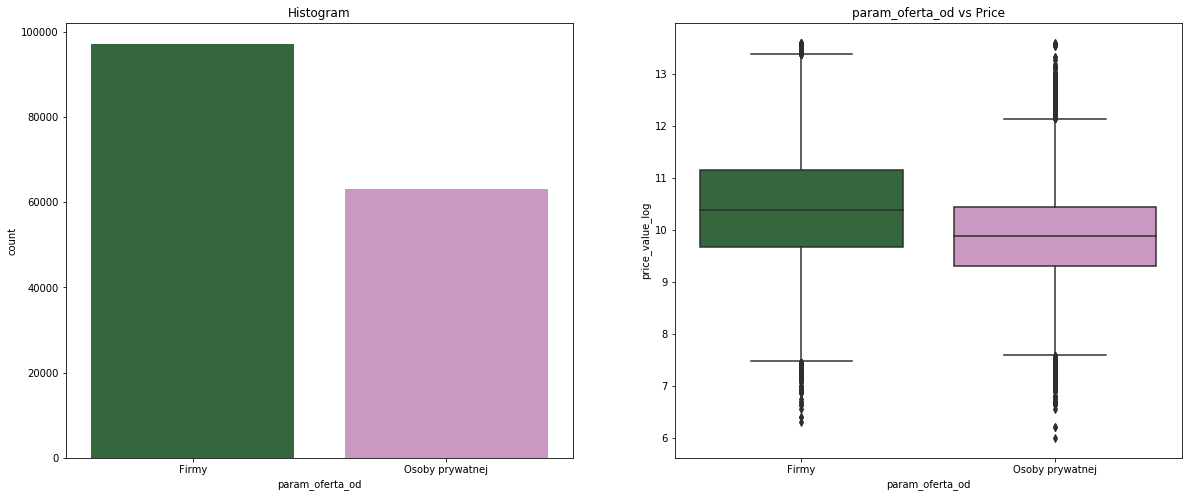

87: param_opłata_początkowa [0.26%=412/160616]: 
91: param_stan [99.90%=160455/160616]: 
Używane    146217
Nowe        14238
Name: param_stan, dtype: int64


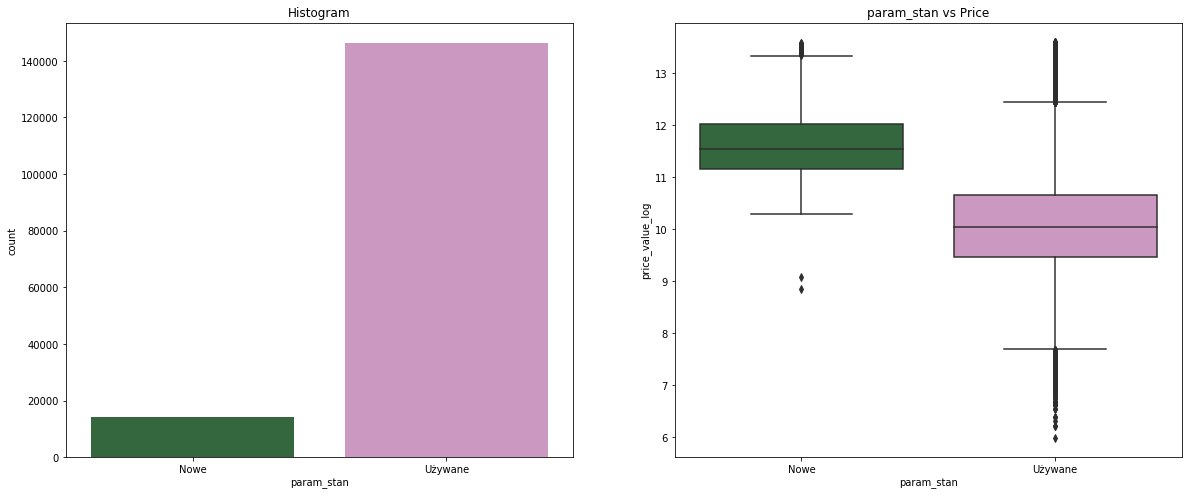

104: param_marka_pojazdu [99.90%=160455/160616]: 
105: param_model_pojazdu [99.90%=160455/160616]: 
106: param_kod_silnika [10.75%=17265/160616]: 
108: param_pierwsza_rejestracja [36.28%=58276/160616]: 
109: param_kraj_pochodzenia [68.01%=109232/160616]: 
110: param_skrzynia_biegów [94.56%=151871/160616]: 
Manualna                                 110681
Automatyczna hydrauliczna (klasyczna)     27955
Automatyczna dwusprzęgłowa (DCT, DSG)      9629
Automatyczna bezstopniowa (CVT)            2302
Półautomatyczna (ASG, Tiptronic)           1304
Name: param_skrzynia_biegów, dtype: int64


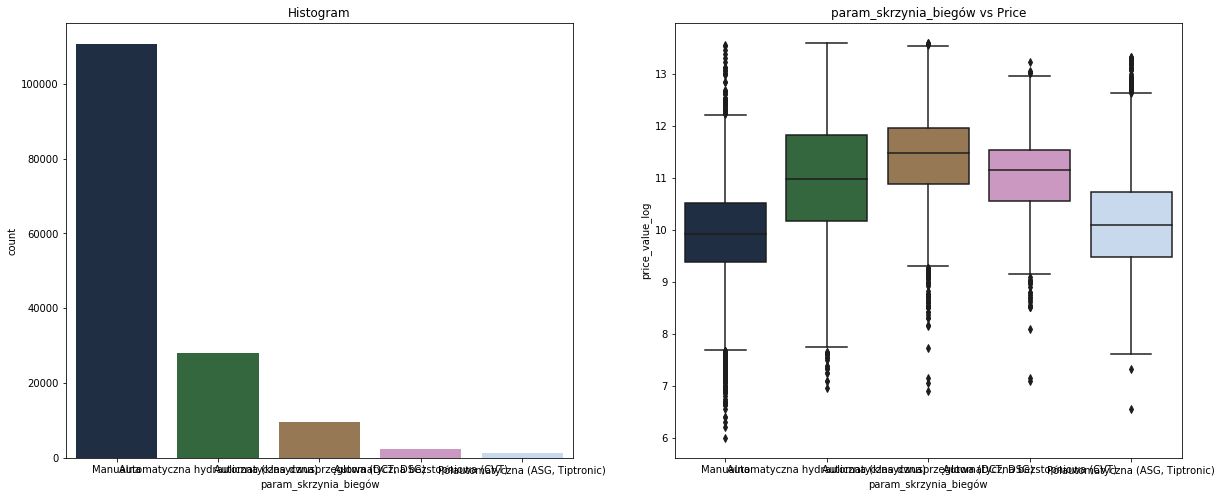

112: param_kolor [99.90%=160455/160616]: 
Czarny        39267
Srebrny       29515
Szary         21927
Biały         17687
Niebieski     17423
Inny kolor    11467
Czerwony       6246
Brązowy        4284
Zielony        3872
Bordowy        2850
Złoty          2448
Beżowy         2113
Fioletowy       736
Żółty           620
Name: param_kolor, dtype: int64


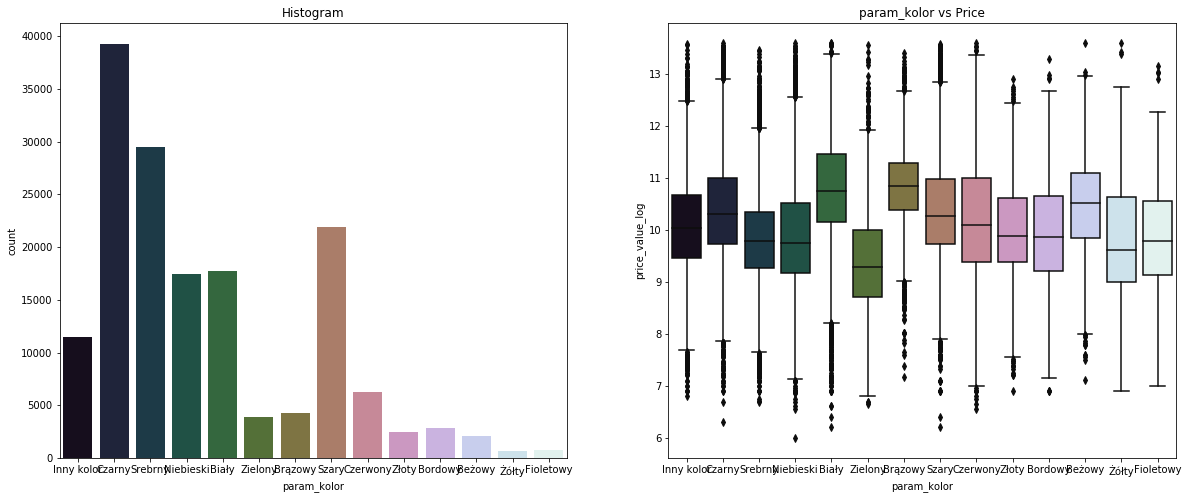

118: param_napęd [84.68%=136003/160616]: 
Na przednie koła                 99630
Na tylne koła                    12967
4x4 (stały)                      10641
4x4 (dołączany automatycznie)    10341
4x4 (dołączany ręcznie)           2424
Name: param_napęd, dtype: int64


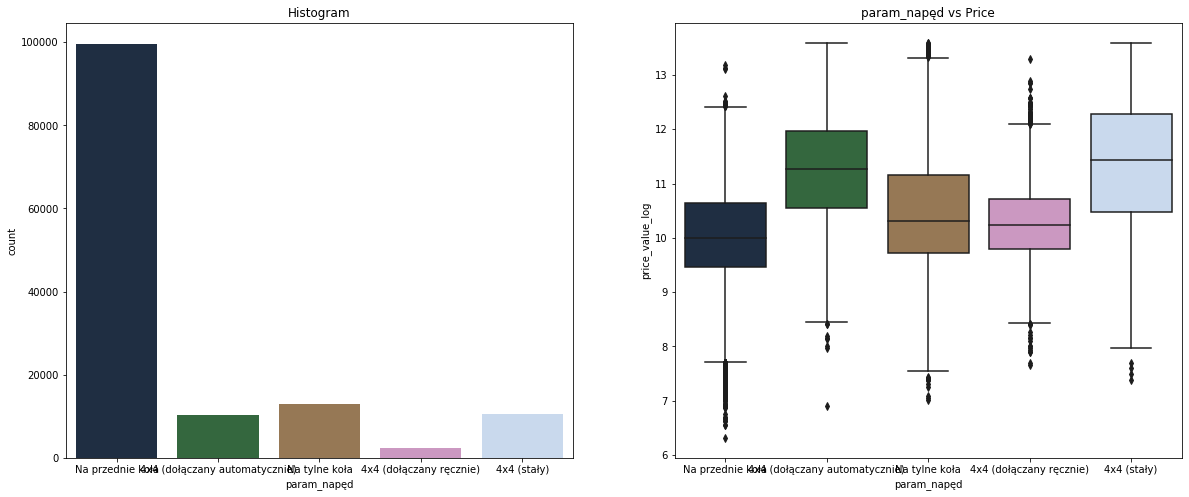

120: param_rodzaj_paliwa [99.90%=160455/160616]: 
Diesel         81448
Benzyna        70631
Benzyna+LPG     7187
Hybryda          960
Elektryczny      125
Benzyna+CNG      102
Etanol             1
Wodór              1
Name: param_rodzaj_paliwa, dtype: int64


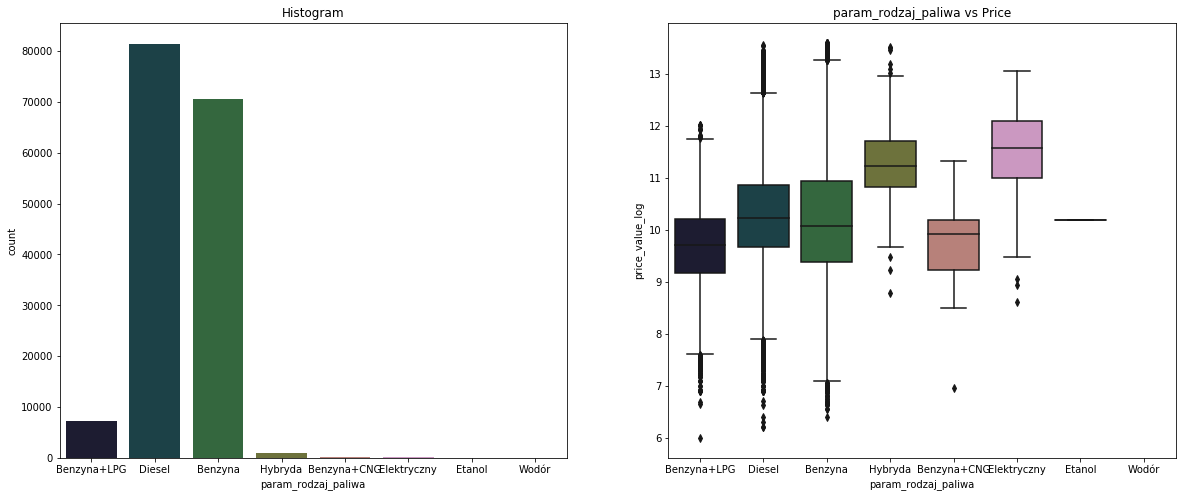

121: param_typ [99.90%=160454/160616]: 
Kombi                   33012
Sedan                   27051
Kompakt                 24864
SUV                     24263
Auta miejskie           20532
Minivan                 19784
Auta małe                5407
Coupe                    4011
Kabriolet                1348
sedan/coupe/cabrio         45
hatchback                  43
sedan/coupe                40
coupe/cabrio               37
minivan/city-car            6
city-car/suv                3
compact/minivan             3
coupe/cabrio/minivan        2
others                      1
not enough details          1
compact/sedan               1
Name: param_typ, dtype: int64


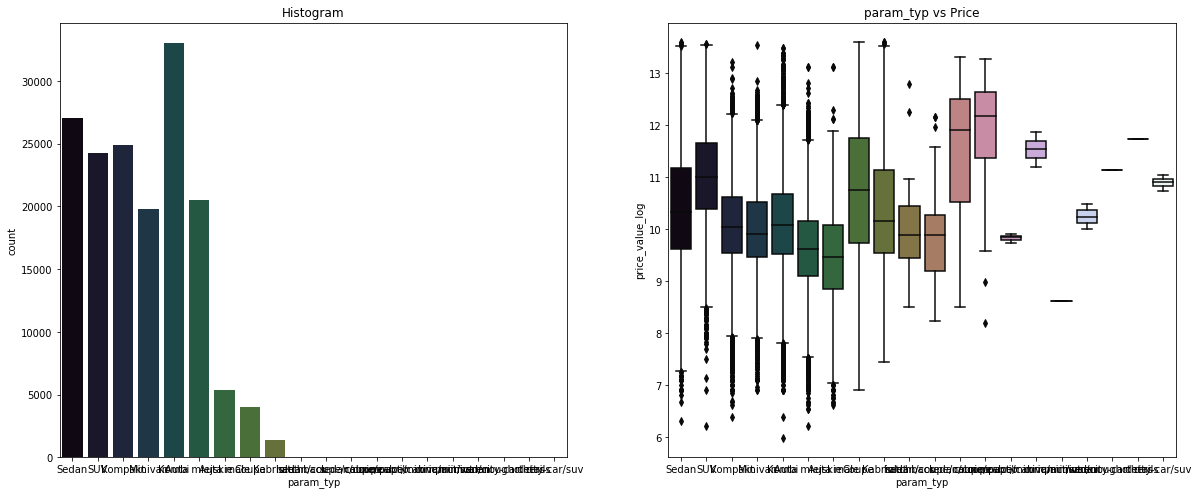

122: param_emisja_co2 [1.94%=3117/160616]: 
130: param_miesięczna_rata [0.45%=727/160616]: 
131: param_wersja [77.49%=124457/160616]: 
160: new_cat_price_value [66.30%=106494/160616]: 
perc_65    5698
perc_40    5665
perc_15    5446
perc_80    5404
perc_50    5370
perc_20    5357
perc_70    5354
perc_90    5340
perc_10    5339
perc_85    5338
perc_95    5328
perc_25    5310
perc_30    5282
perc_05    5280
perc_45    5245
perc_75    5242
perc_60    5217
perc_00    5201
perc_35    5041
perc_55    5037
Name: new_cat_price_value, dtype: int64


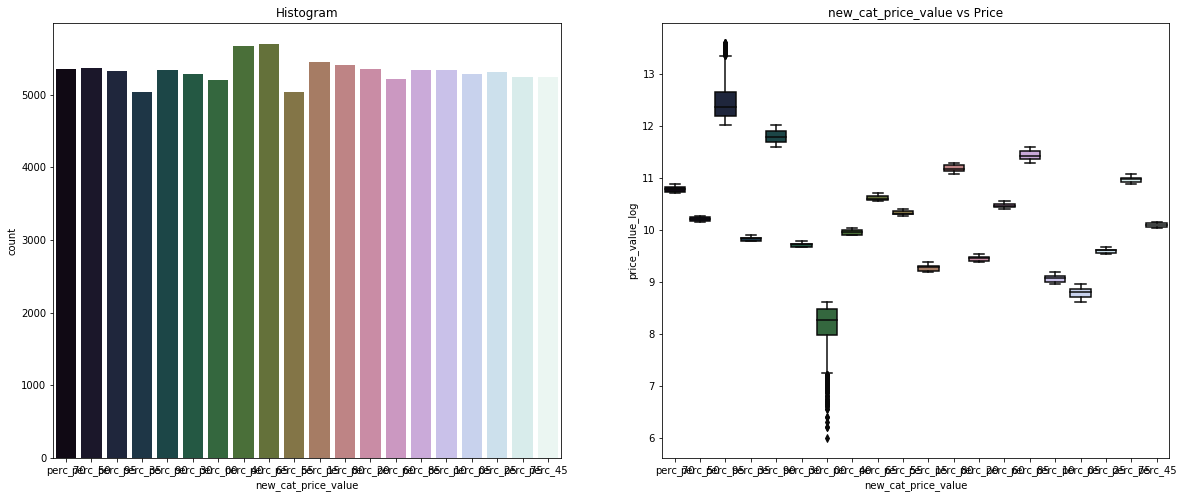

162: param_rodzaj_paliwa_2 [100.00%=160616/160616]: 
Diesel         81448
Benzyna        70632
Benzyna+LPG     7187
Hybryda          960
NA               162
Elektryczny      125
Benzyna+CNG      102
Name: param_rodzaj_paliwa_2, dtype: int64


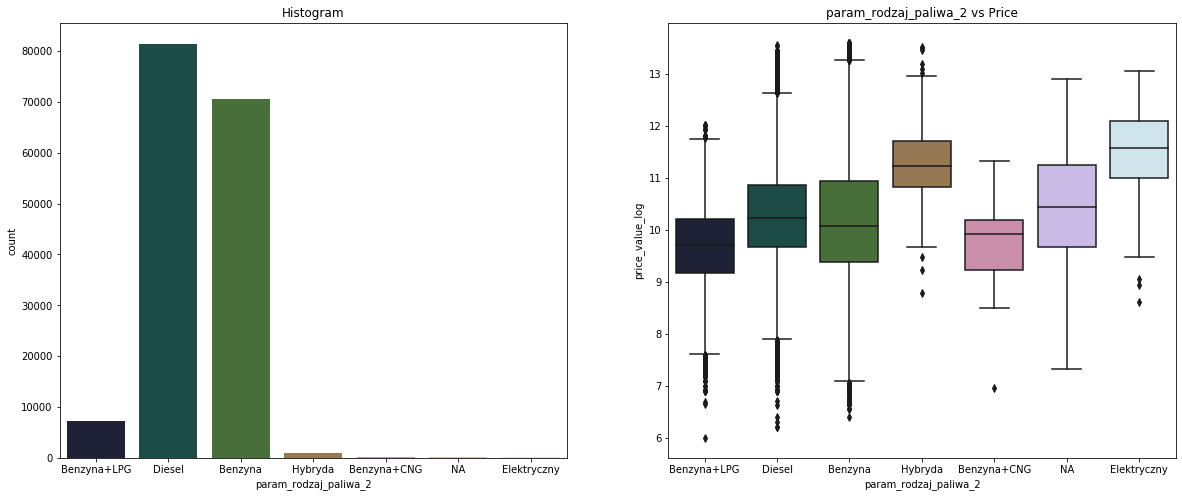

164: param_skrzynia_biegów_2 [100.00%=160616/160616]: 
Manualna                                 110681
Automatyczna hydrauliczna (klasyczna)     27955
Automatyczna dwusprzęgłowa (DCT, DSG)      9629
NA                                         8745
Automatyczna bezstopniowa (CVT)            2302
Półautomatyczna (ASG, Tiptronic)           1304
Name: param_skrzynia_biegów_2, dtype: int64


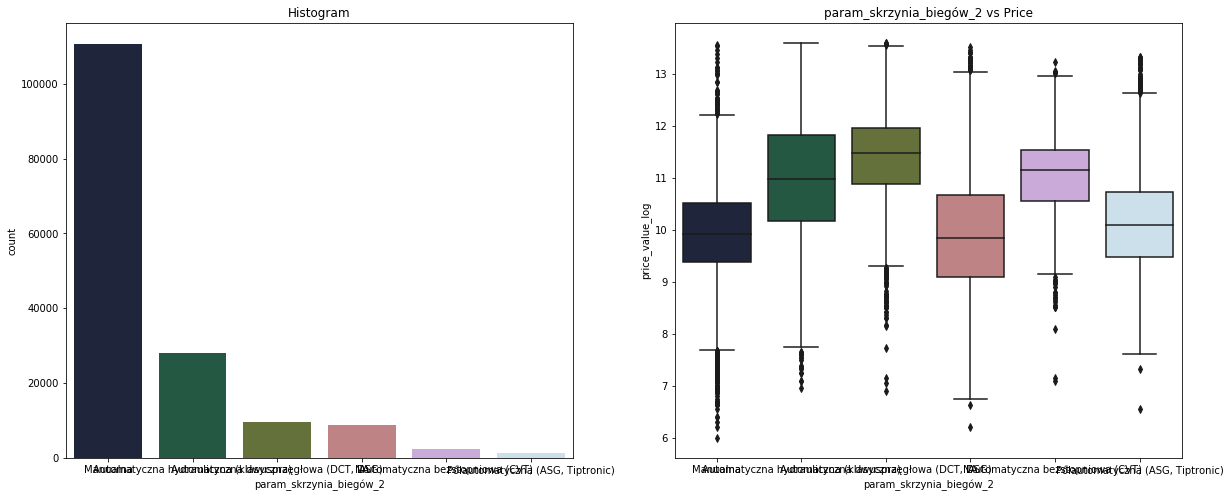

166: param_napęd_2 [100.00%=160616/160616]: 
Na przednie koła                 99630
NA                               24613
Na tylne koła                    12967
4x4 (stały)                      10641
4x4 (dołączany automatycznie)    10341
4x4 (dołączany ręcznie)           2424
Name: param_napęd_2, dtype: int64


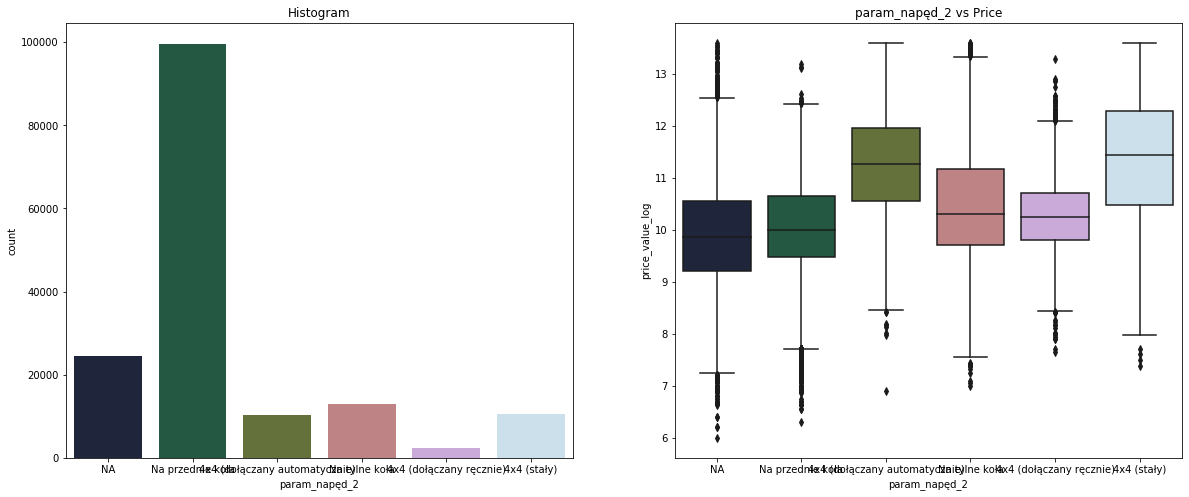

168: param_kolor_2 [100.00%=160616/160616]: 
Czarny        39267
Srebrny       29515
Szary         21927
Biały         17687
Niebieski     17423
Inny kolor    11467
Czerwony       6246
Brązowy        4284
Zielony        3872
Bordowy        2850
Złoty          2448
Beżowy         2113
Fioletowy       736
Żółty           620
NA              161
Name: param_kolor_2, dtype: int64


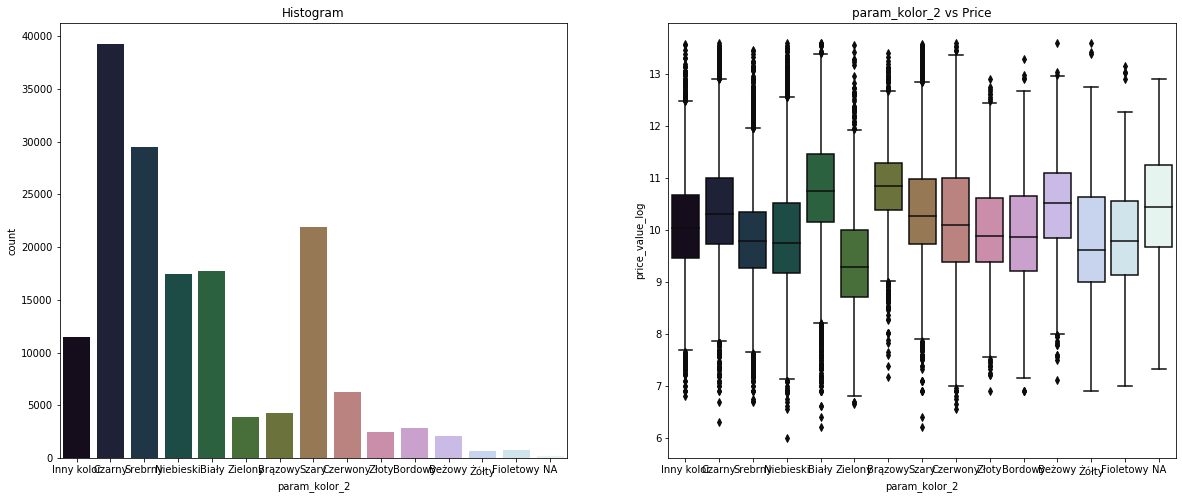

171: vin_where [100.00%=160616/160616]: 
172: vin_flex_fuel [100.00%=160616/160616]: 
173: vin_portrait [100.00%=160616/160616]: 
174: vin_security [100.00%=160616/160616]: 
175: vin_model [100.00%=160616/160616]: 
176: vin_plant [100.00%=160616/160616]: 
177: param_typ_2 [100.00%=160616/160616]: 
Kombi            33012
Sedan            27052
Kompakt          24864
SUV              24266
Auta miejskie    20538
Minivan          19789
Auta małe         5407
Coupe             4051
Kabriolet         1430
_NA_Inne           164
Hatchback           43
Name: param_typ_2, dtype: int64


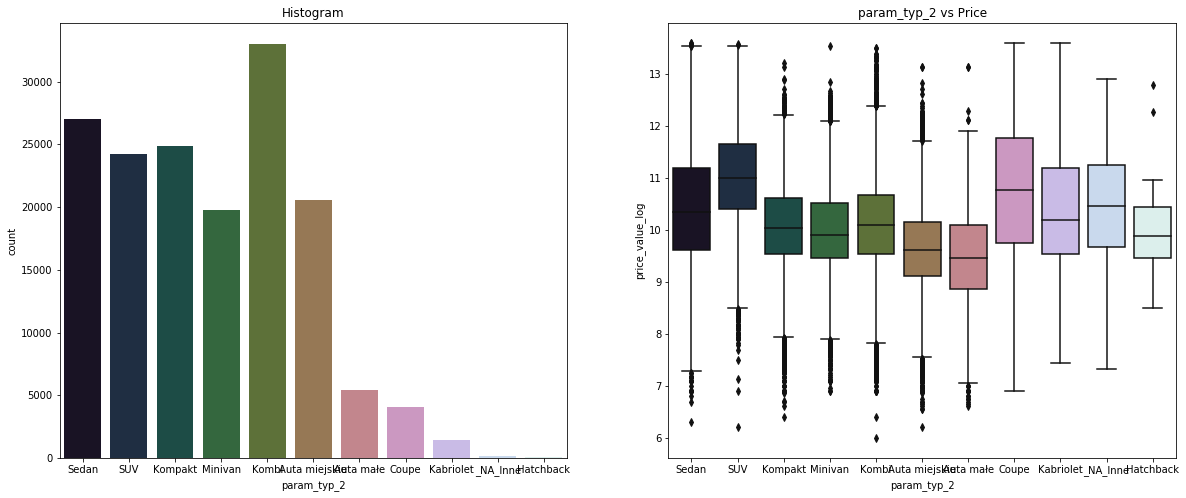

185: seller_wojewodzctwo [100.00%=160616/160616]: 
Mazowieckie            27958
Wielkopolskie          23661
Śląskie                19115
Małopolskie            15668
Dolnośląskie           11977
Łódzkie                 9687
Pomorskie               9672
Lubelskie               7086
Kujawsko-pomorskie      6908
Zachodniopomorskie      5623
Podkarpackie            4933
Świętokrzyskie          4933
Warmińsko-Mazurskie     3767
Lubuskie                3109
Podlaskie               2928
Opolskie                2740
-1                       851
Name: seller_wojewodzctwo, dtype: int64


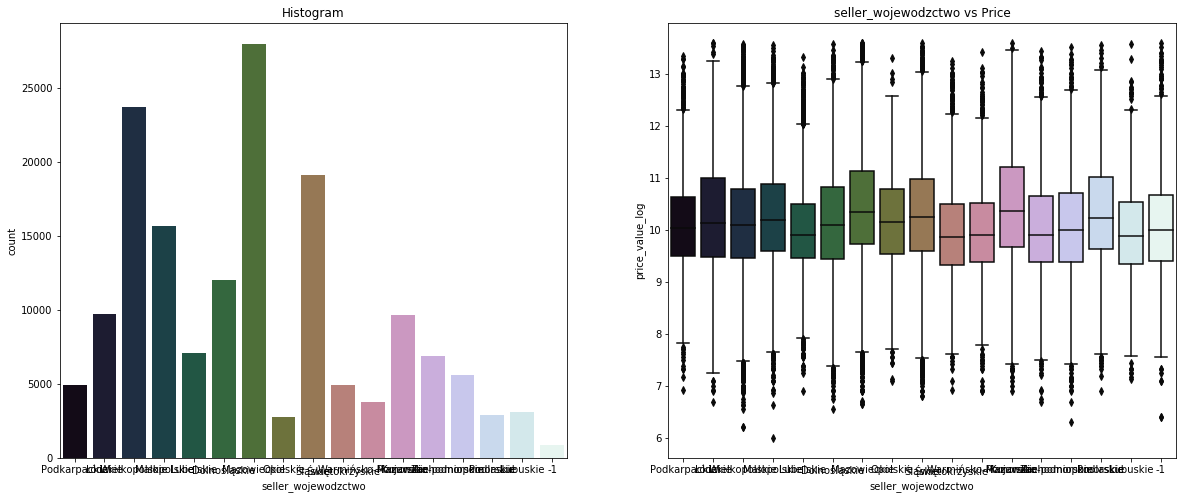

In [215]:
print_plots_by_type(total, type =[np.object])

In [ ]:
## modelowanie

In [14]:
train_30 = pd.read_hdf('output/train_30.h5', 'data') 
test_car_ids = train_30['car_id'].values

train_70 = total[~total['car_id'].isin(test_car_ids) & ~total['price_value'].isna()]
train_30 = total[total['car_id'].isin(test_car_ids)]

print(len(total.index))
print(len(total[~total['price_value'].isna()].index))

print(train_70['price_value'].isna().sum())
print(train_30['price_value'].isna().sum())

train_100 = total[~total['price_value'].isna()]
print(train_100['price_value'].isna().sum())

global_min = total[~total['price_value'].isna()].price_value.min()


160616
106494
0
0
0


In [15]:
start_vars=  ['feature_czujniki_parkowania_przednie', 'feature_poduszka_powietrzna_chroniąca_kolana', 'feature_kurtyny_powietrzne', 'feature_klimatyzacja_dwustrefowa', 'feature_światła_led', 'feature_czujnik_zmierzchu', 'feature_elektrycznie_ustawiane_lusterka', 'feature_asr__kontrola_trakcji_', 'feature_poduszka_powietrzna_kierowcy', 'feature_cd', 'feature_elektryczne_szyby_przednie', 'feature_poduszka_powietrzna_pasażera', 'feature_system_start_stop', 'feature_światła_do_jazdy_dziennej', 'feature_komputer_pokładowy', 'feature_elektryczne_szyby_tylne', 'feature_klimatyzacja_manualna', 'feature_tapicerka_welurowa', 'feature_czujnik_deszczu', 'feature_światła_przeciwmgielne', 'feature_ogrzewanie_postojowe', 'feature_radio_niefabryczne', 'feature_regulowane_zawieszenie', 'feature_ogranicznik_prędkości', 'feature_zmieniarka_cd', 'feature_szyberdach', 'feature_isofix', 'feature_asystent_pasa_ruchu', 'feature_alufelgi', 'feature_bluetooth', 'feature_nawigacja_gps', 'feature_asystent_parkowania', 'feature_wspomaganie_kierownicy', 'feature_podgrzewana_przednia_szyba', 'feature_przyciemniane_szyby', 'feature_elektrycznie_ustawiane_fotele', 'feature_klimatyzacja_czterostrefowa', 'feature_tuner_tv', 'feature_poduszki_boczne_przednie', 'feature_tempomat_aktywny', 'feature_klimatyzacja_automatyczna', 'feature_poduszki_boczne_tylne', 'feature_radio_fabryczne', 'feature_odtwarzacz_dvd', 'feature_czujniki_parkowania_tylne', 'feature_łopatki_zmiany_biegów', 'feature_centralny_zamek', 'feature_dach_panoramiczny', 'feature_kamera_cofania', 'feature_immobilizer', 'feature_czujnik_martwego_pola', 'feature_gniazdo_sd', 'feature_podgrzewane_lusterka_boczne', 'feature_podgrzewane_przednie_siedzenia', 'feature_hak', 'feature_abs', 'feature_wielofunkcyjna_kierownica', 'feature_światła_xenonowe', 'feature_gniazdo_usb', 'feature_tapicerka_skórzana', 'feature_gniazdo_aux', 'feature_esp__stabilizacja_toru_jazdy_', 'feature_alarm', 'feature_podgrzewane_tylne_siedzenia', 'feature_mp3', 'feature_tempomat', 'feature_hud__wyświetlacz_przezierny_', 'feature_elektrochromatyczne_lusterko_wsteczne', 'feature_relingi_dachowe', 'feature_elektrochromatyczne_lusterka_boczne', 
              'param_faktura_vat', 'param_homologacja_ciężarowa', 'param_vat_marża', 
              'param_zarejestrowany_jako_zabytek', 'param_vat_discount', 'param_kierownica_po_prawej__anglik_', 
              'param_vat_free', 'param_tuning', 'param_matowy', 
#               'param_liczba_miejsc',  #### to bylo, ale sa braki
              'param_liczba_miejsc_2', 
              'param_liczba_drzwi', 
              'param_serwisowany_w_aso', 'param_pierwszy_właściciel', 'param_bezwypadkowy', 
              'param_zarejestrowany_w_polsce', 'param_moc', 'param_rok_produkcji', 'param_pojemność_skokowa', 
              'param_filtr_cząstek_stałych', 'param_uszkodzony', 'param_przebieg', 'param_perłowy', 
              'param_metalik', 'param_leasing', 'param_możliwość_finansowania', 'param_akryl__niemetalizowany_', 
#               'param_pierwsza_rejestracja_date', #### to bylo, ale sa braki
              'param_pierwsza_rejestracja_date_na',
              'price_currency_pln', 'new_seller_address_cat', 
              'new_seller_name_cat', 'new_seller_type_cat', 'new_param_vin_cat', 'new_param_kategoria_cat', 
              'new_param_wartość_wykupu_cat', 'new_param_liczba_pozostałych_rat_cat', 'new_param_oferta_od_cat', 
              'new_param_opłata_początkowa_cat', 'new_param_stan_cat', 'new_param_marka_pojazdu_cat', 
              'new_param_model_pojazdu_cat', 'new_param_kod_silnika_cat', 'new_param_pierwsza_rejestracja_cat', 
              'new_param_kraj_pochodzenia_cat', 'new_param_skrzynia_biegów_cat', 'new_param_kolor_cat', 
              'new_param_napęd_cat', 'new_param_rodzaj_paliwa_cat', 'new_param_typ_cat', 'new_param_emisja_co2_cat',
              'new_param_miesięczna_rata_cat', 'new_param_wersja_cat']
start_vars = np.sort(start_vars)

### moje
# obj_feats = list(total.select_dtypes(np.object).columns)
# obj_feats = [x for x in obj_feats if x.startswith('vin_')]

# for feat in obj_feats:
#     total["new_{}_cat".format(feat)] = total[feat].factorize()[0]

### Vladimir
# obj_feats = list(total.select_dtypes(np.object).columns)
# obj_feats = [x for x in obj_feats if x.startswith('param') or x.startswith('seller')]

# for feat in obj_feats:
#     total["new_{}_cat".format(feat)] = total[feat].factorize()[0]

black_list = ['car_id', 'price_details', 'price_value', 'price_value_log', 'price_value_pln', 'price_value_pln_log_transl', 'new_cat_price_value',
              *[x for x in total.columns if x.startswith('model_')],
              *total.columns[total.isnull().any()],
#               'encoded_price_currency', 
#               'price_currency_pln'
#               'created_at_unix_na_mean',
#               'created_at_unix', 
#               'pln_to_eur', 
#               'latitude', 'longitude', 
#               'latitude_na_mean', 'longitude_na_mean', 
#               'seller_address_cat', 'seller_name_cat', 'seller_type_cat', 
#               'new_cat_seller_address', 
#               'new_seller_address_cat', 'new_seller_name_cat', 'new_seller_type_cat', 
#               'new_param_vin_cat', 'param_vin_len', 
#               'new_param_rodzaj_paliwa_cat', 'new_param_skrzynia_biegów_cat', 'new_param_napęd_cat', 'new_param_kolor_cat', 'new_param_typ_cat',
#               'new_param_wartość_wykupu_cat', 'new_param_liczba_pozostałych_rat_cat', 'new_param_opłata_początkowa_cat', 'new_param_emisja_co2_cat', 'new_param_miesięczna_rata_cat',
#               'new_param_pierwsza_rejestracja_cat',
             ]

feats = total.select_dtypes(include=[np.number, np.bool]).columns

feats = [x for x in feats if x not in black_list]
# feats = [x for x in feats if not x.endswith('_cat')]
feats = np.sort(feats)

feats2 = np.unique([*feats, *start_vars])
feats2 = np.sort(feats2)

# total[start_vars].info(verbose=True)
# total[feats].info(verbose=True)
total[feats2].info(verbose=True)
# black_list

print(total[feats2].columns[total[feats2].isnull().any()])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160616 entries, 0 to 160615
Data columns (total 147 columns):
 #   Column                                         Dtype  
---  ------                                         -----  
 0   created_at_unix                                float64
 1   created_at_unix_na_mean                        float64
 2   encoded_param_kolor_2                          int64  
 3   encoded_param_napęd_2                          int64  
 4   encoded_param_rodzaj_paliwa_2                  int64  
 5   encoded_param_skrzynia_biegów_2                int64  
 6   encoded_param_typ_2                            int64  
 7   feature_abs                                    bool   
 8   feature_alarm                                  bool   
 9   feature_alufelgi                               bool   
 10  feature_asr__kontrola_trakcji_                 bool   
 11  feature_asystent_parkowania                    bool   
 12  feature_asystent_pasa_ruchu                

In [10]:
start_vars_extra_small = [x for x in total.columns if x.startswith('new_param_')]
total[start_vars_extra_small].info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160616 entries, 0 to 160615
Data columns (total 20 columns):
 #   Column                                Non-Null Count   Dtype
---  ------                                --------------   -----
 0   new_param_vin_cat                     160616 non-null  int64
 1   new_param_kategoria_cat               160616 non-null  int64
 2   new_param_wartość_wykupu_cat          160616 non-null  int64
 3   new_param_liczba_pozostałych_rat_cat  160616 non-null  int64
 4   new_param_oferta_od_cat               160616 non-null  int64
 5   new_param_opłata_początkowa_cat       160616 non-null  int64
 6   new_param_stan_cat                    160616 non-null  int64
 7   new_param_marka_pojazdu_cat           160616 non-null  int64
 8   new_param_model_pojazdu_cat           160616 non-null  int64
 9   new_param_kod_silnika_cat             160616 non-null  int64
 10  new_param_pierwsza_rejestracja_cat    160616 non-null  int64
 11  new_param_kraj_pochodzenia

In [16]:
start_vars_2 = ['feature_asystent_parkowania', 'feature_poduszka_powietrzna_pasażera', 'new_param_kod_silnika_cat',
                'new_param_liczba_pozostałych_rat_cat', 'new_param_marka_pojazdu_cat', 'new_param_miesięczna_rata_cat', 'new_param_model_pojazdu_cat', 'new_param_napęd_cat', 'new_param_oferta_od_cat', 'new_param_pierwsza_rejestracja_cat', 'new_param_rodzaj_paliwa_cat', 'new_param_skrzynia_biegów_cat', 'new_param_stan_cat', 'new_param_typ_cat', 'new_param_vin_cat', 'new_param_wartość_wykupu_cat', 'new_param_wersja_cat', 'param_leasing', 'param_liczba_miejsc_2', 'param_uszkodzony']

mea: 12840.187868861838
r2: 0.7700437558396883
Learning curve for: XGBRegressor


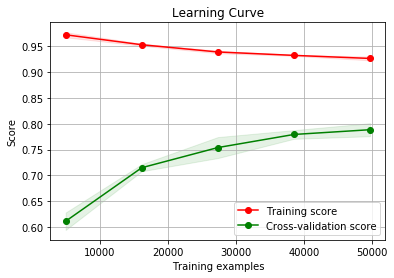

In [21]:
params = {    
    'n_estimators': 50, 
    'learning_rate': 0.3, 
    'subsample': 0.5, 
    'colsample_bytree': 0.9,
    'max_depth': 10, 
}

mae, r2, model, model_cl, learning_curve_plot = train_and_submit(train_70, train_30, total.loc[total['price_value'].isna(),], 
                 start_vars_2, global_min, 
                 xgb.XGBRegressor, params,
                 file_sufix = 'vars_search_train_70', opis='', 
                 learning_curve = True, 
                 add_model_column_min = -1, total = total, 
                 save_min=7000, kaggle_min=-1)


In [18]:
def replace_feature(current_vars, old, new):
    current_vars = np.array(current_vars)
    current_vars = list(current_vars)
    current_vars.remove(old)
    current_vars.append(new)
    return np.sort(current_vars)

replace_feature(['a', 'b', 'c'], 'b', 'e')

array(['a', 'c', 'e'], dtype='<U1')

In [19]:
import random

def mutate_rand_feature(current_vars, all_vars, added_so_far, removed_so_far):
    
    def diff(a, b):
        return np.concatenate([np.setdiff1d(a,b), np.setdiff1d(b,a)])
    
#     vars_to_draw_from = diff(current_vars, all_vars)
    vars_to_draw_from = [x for x in all_vars if x not in current_vars]
#     vars_to_draw_from = diff(vars_to_draw_from, added_so_far)
    vars_to_draw_from = [x for x in vars_to_draw_from if x not in added_so_far]
#     vars_to_draw_from = diff(vars_to_draw_from, removed_so_far)
    vars_to_draw_from = [x for x in vars_to_draw_from if x not in removed_so_far]
    
    last_trial = False
    if len(vars_to_draw_from) == 1: last_trial = True

    print(vars_to_draw_from)
    added = np.random.choice(vars_to_draw_from, 1)[0]
    removed = np.random.choice(np.setdiff1d(current_vars, added), 1)[0]
    print(removed)
    print(added)
    current_vars = replace_feature(current_vars, removed, added)
    print(current_vars)
    
    return current_vars, added, np.append(added_so_far, added), removed, np.append(removed_so_far, removed), last_trial

added_so_far = []
removed_so_far = []
current_vars = ['a', 'b', 'c', 'd', 'e']
all_vars = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']
mutate_rand_feature(current_vars, all_vars, added_so_far, removed_so_far)

['f', 'g', 'h', 'i']
a
f
['b' 'c' 'd' 'e' 'f']


(array(['b', 'c', 'd', 'e', 'f'], dtype='<U1'),
 'f',
 array(['f'], dtype='<U32'),
 'a',
 array(['a'], dtype='<U32'),
 False)

In [22]:
import contextlib
import warnings
warnings.filterwarnings("ignore")

params = {    
    'n_jobs': 8, 
    'n_estimators': 50, 
    'learning_rate': 0.3, 
    'subsample': 0.5, 
    'colsample_bytree': 0.9,
    'max_depth': 10, 
}

mae_global_min = 12840.187868861838
big_iter = 0

current_vars=start_vars_2 #naj mniejszy set
all_vars = feats2 #maksymalny set

while True:

    added_so_far = []
    removed_so_far = []

    last_added = None
    last_removed = None

    last_trial = False
    big_iter += 1
    print("START iter=" + str(big_iter) + ', mae_global_min=' + str(mae_global_min))
    
    while True:
        with contextlib.redirect_stdout(None):
            current_vars, last_added, added_so_far, last_removed, removed_so_far, last_trial =  mutate_rand_feature(current_vars, all_vars, added_so_far, removed_so_far)
        print('added: ' + last_added)
        print('removed: ' + last_removed)
        print('len: ' + str(len(current_vars)))
        
        mae, r2, model, model_cl, learning_curve_plot = train_and_submit(train_70, train_30, total.loc[total['price_value'].isna(),], 
                     current_vars, global_min, 
                     xgb.XGBRegressor, params, subfolder='extra_small',
                     file_sufix = 'vars_search_train_70', opis='', 
                     learning_curve = False, 
                     add_model_column_min = -1, total = total, 
                     save_min=mae_global_min, kaggle_min=-1)

        if mae < mae_global_min:
            mae_global_min = mae
            print('Improvement: ' + last_removed + ' -> ' + last_added)
        else:
            current_vars = replace_feature(current_vars, last_added, last_removed)
            print('Rollback: ' + last_added + ' -> ' + last_removed)
        print('=============================================' + str(mae_global_min)+ '=============================================')

        if last_trial == True: 
            print("END iter=" + str(big_iter) + ', mae_global_min=' + str(mae))
            break

START iter=1, mae_global_min=12840.187868861838
added: new_seller_wojewodzctwo_cat
removed: param_leasing
len: 20
mea: 12844.25484495607
r2: 0.7771382069201439
Rollback: new_seller_wojewodzctwo_cat -> param_leasing
=============================================12840.187868861838=============================================
added: feature_klimatyzacja_czterostrefowa
removed: new_param_typ_cat
len: 20
mea: 13010.592401333764
r2: 0.7772136287165651
Rollback: feature_klimatyzacja_czterostrefowa -> new_param_typ_cat
=============================================12840.187868861838=============================================
added: feature_światła_przeciwmgielne
removed: new_param_pierwsza_rejestracja_cat
len: 20
mea: 12736.689288799691
r2: 0.7919439326098551
Improvement: new_param_pierwsza_rejestracja_cat -> feature_światła_przeciwmgielne
=============================================12736.689288799691=============================================
added: feature_dach_panoramiczny
removed: param

mea: 12410.455801590799
r2: 0.7937853700272537
Rollback: param_możliwość_finansowania -> feature_czujniki_parkowania_tylne
=============================================12327.290800712628=============================================
added: feature_czujnik_zmierzchu
removed: feature_poduszka_powietrzna_pasażera
len: 20
mea: 12396.431765991047
r2: 0.7993362971298136
Rollback: feature_czujnik_zmierzchu -> feature_poduszka_powietrzna_pasażera
=============================================12327.290800712628=============================================
added: feature_światła_xenonowe
removed: new_param_skrzynia_biegów_cat
len: 20
mea: 12687.57367030114
r2: 0.7761652061128689
Rollback: feature_światła_xenonowe -> new_param_skrzynia_biegów_cat
=============================================12327.290800712628=============================================
added: feature_regulowane_zawieszenie
removed: new_param_rodzaj_paliwa_cat
len: 20
mea: 12462.457147851697
r2: 0.7932950808561079
Rollback: feature

mea: 11967.514137939444
r2: 0.8053549834316189
Rollback: feature_tempomat_aktywny -> new_param_opłata_początkowa_cat
=============================================11836.063870587392=============================================
added: new_vin_model_cat
removed: new_param_napęd_cat
len: 20
mea: 12040.00230767719
r2: 0.8098054146885153
Rollback: new_vin_model_cat -> new_param_napęd_cat
=============================================11836.063870587392=============================================
added: feature_elektryczne_szyby_przednie
removed: feature_gniazdo_sd
len: 20
mea: 12038.908127555342
r2: 0.8085194402673692
Rollback: feature_elektryczne_szyby_przednie -> feature_gniazdo_sd
=============================================11836.063870587392=============================================
added: param_metalik
removed: new_seller_type_cat
len: 20
mea: 12038.384216852597
r2: 0.8072722304835912
Rollback: param_metalik -> new_seller_type_cat
=============================================11836.06

mea: 10978.821908377016
r2: 0.835485580060661
Improvement: param_tuning -> pln_to_eur
=============================================10978.821908377016=============================================
added: param_zarejestrowany_jako_zabytek
removed: param_pierwsza_rejestracja_date_na
len: 20
mea: 11604.144865705312
r2: 0.8124722823576715
Rollback: param_zarejestrowany_jako_zabytek -> param_pierwsza_rejestracja_date_na
=============================================10978.821908377016=============================================
added: feature_hud__wyświetlacz_przezierny_
removed: new_param_model_pojazdu_cat
len: 20
mea: 11343.28218538871
r2: 0.8217638409255057
Rollback: feature_hud__wyświetlacz_przezierny_ -> new_param_model_pojazdu_cat
=============================================10978.821908377016=============================================
added: new_vin_where_cat
removed: feature_elektrycznie_ustawiane_fotele
len: 20
mea: 10954.920988942611
r2: 0.8376216684288273
Improvement: feature_elek

mea: 8200.200531520175
r2: 0.8986235466856611
Rollback: feature_gniazdo_aux -> feature_bluetooth
=============================================8178.731353130214=============================================
added: param_vin_len
removed: new_param_kod_silnika_cat
len: 20
mea: 8158.776828720797
r2: 0.8955991429528751
Improvement: new_param_kod_silnika_cat -> param_vin_len
=============================================8158.776828720797=============================================
added: feature_radio_niefabryczne
removed: param_serwisowany_w_aso
len: 20
mea: 8161.372777812453
r2: 0.8958174657344713
Rollback: feature_radio_niefabryczne -> param_serwisowany_w_aso
=============================================8158.776828720797=============================================
added: param_vat_discount
removed: feature_czujniki_parkowania_tylne
len: 20
mea: 8189.934799214147
r2: 0.8962954869893244
Rollback: param_vat_discount -> feature_czujniki_parkowania_tylne
=======================================

mea: 7862.123037258233
r2: 0.9066929072828396
Rollback: param_vat_discount -> new_param_marka_pojazdu_cat
=============================================7488.394300335563=============================================
added: param_liczba_drzwi
removed: feature_elektryczne_szyby_tylne
len: 20
mea: 7519.619492302734
r2: 0.9188023941725256
Rollback: param_liczba_drzwi -> feature_elektryczne_szyby_tylne
=============================================7488.394300335563=============================================
added: feature_relingi_dachowe
removed: new_param_typ_cat
len: 20
mea: 7659.026403973804
r2: 0.9157204442041227
Rollback: feature_relingi_dachowe -> new_param_typ_cat
=============================================7488.394300335563=============================================
added: feature_tempomat_aktywny
removed: param_pojemność_skokowa
len: 20
mea: 7614.129247042696
r2: 0.9147274243611194
Rollback: feature_tempomat_aktywny -> param_pojemność_skokowa
=====================================

mea: 7384.379339898128
r2: 0.9201270720387962
Rollback: feature_klimatyzacja_dwustrefowa -> feature_czujnik_deszczu
=============================================7284.758113048962=============================================
added: new_param_vin_cat
removed: param_uszkodzony
len: 20
mea: 8063.9424937404065
r2: 0.9050629053757224
Rollback: new_param_vin_cat -> param_uszkodzony
=============================================7284.758113048962=============================================
added: param_serwisowany_w_aso
removed: param_leasing
len: 20
mea: 7361.524262734284
r2: 0.9160996755498927
Rollback: param_serwisowany_w_aso -> param_leasing
=============================================7284.758113048962=============================================
added: feature_czujniki_parkowania_przednie
removed: new_param_model_pojazdu_cat
len: 20
mea: 7531.269565871064
r2: 0.917198575808724
Rollback: feature_czujniki_parkowania_przednie -> new_param_model_pojazdu_cat
===================================

mea: 9160.372937210475
r2: 0.9049550585810044
Rollback: feature_gniazdo_aux -> param_rok_produkcji
=============================================7258.979267169071=============================================
added: new_param_kategoria_cat
removed: price_currency_pln
len: 20
mea: 7465.3677904298365
r2: 0.9137350136879393
Rollback: new_param_kategoria_cat -> price_currency_pln
=============================================7258.979267169071=============================================
added: feature_klimatyzacja_automatyczna
removed: pln_to_eur
len: 20
mea: 7340.809401083288
r2: 0.9225324988755046
Rollback: feature_klimatyzacja_automatyczna -> pln_to_eur
=============================================7258.979267169071=============================================
added: param_zarejestrowany_jako_zabytek
removed: param_faktura_vat
len: 20
mea: 7384.271857818992
r2: 0.9163039140567645
Rollback: param_zarejestrowany_jako_zabytek -> param_faktura_vat
=============================================72

mea: 7325.768876487907
r2: 0.9227559298158161
Rollback: feature_odtwarzacz_dvd -> param_faktura_vat
=============================================7258.979267169071=============================================
added: param_pierwsza_rejestracja_date_na
removed: feature_czujnik_deszczu
len: 20
mea: 7447.273059019752
r2: 0.9175613719998187
Rollback: param_pierwsza_rejestracja_date_na -> feature_czujnik_deszczu
=============================================7258.979267169071=============================================
added: encoded_param_typ_2
removed: price_currency_pln
len: 20
mea: 7438.734672976654
r2: 0.9147947211614285
Rollback: encoded_param_typ_2 -> price_currency_pln
=============================================7258.979267169071=============================================
added: new_param_kolor_cat
removed: encoded_param_rodzaj_paliwa_2
len: 20
mea: 7572.9993366560375
r2: 0.9114712787605882
Rollback: new_param_kolor_cat -> encoded_param_rodzaj_paliwa_2
==============================

mea: 7342.036442576281
r2: 0.9201735974554798
Rollback: feature_ogranicznik_prędkości -> feature_czujnik_deszczu
=============================================7258.979267169071=============================================
added: param_tuning
removed: param_przebieg
len: 20
mea: 7628.742092447693
r2: 0.9139172924639029
Rollback: param_tuning -> param_przebieg
=============================================7258.979267169071=============================================
added: param_homologacja_ciężarowa
removed: new_param_marka_pojazdu_cat
len: 20
mea: 7762.715968621149
r2: 0.9082396438146956
Rollback: param_homologacja_ciężarowa -> new_param_marka_pojazdu_cat
=============================================7258.979267169071=============================================
added: feature_isofix
removed: pln_to_eur
len: 20
mea: 7335.865732744043
r2: 0.9210298934291035
Rollback: feature_isofix -> pln_to_eur
=============================================7258.979267169071================================

mea: 7410.934535268092
r2: 0.9208982076409201
Rollback: feature_poduszki_boczne_przednie -> encoded_param_skrzynia_biegów_2
=============================================7258.979267169071=============================================
added: feature_abs
removed: new_param_opłata_początkowa_cat
len: 20
mea: 7369.089709810567
r2: 0.9199390240303995
Rollback: feature_abs -> new_param_opłata_początkowa_cat
=============================================7258.979267169071=============================================
added: feature_czujniki_parkowania_przednie
removed: param_faktura_vat
len: 20
mea: 7308.654942938079
r2: 0.9166342475153564
Rollback: feature_czujniki_parkowania_przednie -> param_faktura_vat
=============================================7258.979267169071=============================================
added: longitude
removed: param_przebieg
len: 20
mea: 7551.460774393904
r2: 0.916427661888428
Rollback: longitude -> param_przebieg
=============================================7258.979267

mea: 7722.770740819811
r2: 0.9137994419948007
Rollback: new_seller_address_cat -> param_moc
=============================================7243.166839295972=============================================
added: feature_łopatki_zmiany_biegów
removed: param_pojemność_skokowa
len: 20
mea: 7418.126097486347
r2: 0.9143560501654489
Rollback: feature_łopatki_zmiany_biegów -> param_pojemność_skokowa
=============================================7243.166839295972=============================================
added: new_vin_portrait_cat
removed: param_pojemność_skokowa
len: 20
mea: 7345.059470361027
r2: 0.918984987973768
Rollback: new_vin_portrait_cat -> param_pojemność_skokowa
=============================================7243.166839295972=============================================
added: feature_klimatyzacja_dwustrefowa
removed: price_currency_pln
len: 20
mea: 7427.30777669793
r2: 0.9123910977759156
Rollback: feature_klimatyzacja_dwustrefowa -> price_currency_pln
===================================

mea: 7397.772943577512
r2: 0.9206019270000481
Rollback: feature_czujnik_martwego_pola -> new_param_napęd_cat
=============================================7237.339057606413=============================================
added: param_liczba_pozostałych_rat_2
removed: feature_elektryczne_szyby_tylne
len: 20
mea: 7306.390364356481
r2: 0.9199182392301212
Rollback: param_liczba_pozostałych_rat_2 -> feature_elektryczne_szyby_tylne
=============================================7237.339057606413=============================================
added: feature_elektrycznie_ustawiane_fotele
removed: price_currency_pln
len: 20
mea: 7407.6437844831335
r2: 0.9141973336151483
Rollback: feature_elektrycznie_ustawiane_fotele -> price_currency_pln
=============================================7237.339057606413=============================================
added: feature_bluetooth
removed: pln_to_eur
len: 20
mea: 7339.842742206237
r2: 0.9199556199596906
Rollback: feature_bluetooth -> pln_to_eur
===================

mea: 7365.447100176991
r2: 0.916861993613787
Rollback: new_param_skrzynia_biegów_cat -> param_zarejestrowany_w_polsce
=============================================7210.151754123226=============================================
added: feature_gniazdo_sd
removed: param_uszkodzony
len: 20
mea: 7919.991698081836
r2: 0.908835999640324
Rollback: feature_gniazdo_sd -> param_uszkodzony
=============================================7210.151754123226=============================================
added: feature_klimatyzacja_manualna
removed: encoded_param_rodzaj_paliwa_2
len: 20
mea: 7443.209486230894
r2: 0.9145976822722734
Rollback: feature_klimatyzacja_manualna -> encoded_param_rodzaj_paliwa_2
=============================================7210.151754123226=============================================
added: param_serwisowany_w_aso
removed: new_seller_type_cat
len: 20
mea: 7445.687884658918
r2: 0.9202377133792253
Rollback: param_serwisowany_w_aso -> new_seller_type_cat
==============================

mea: 7899.572783453158
r2: 0.9089420315106995
Rollback: feature_mp3 -> param_uszkodzony
=============================================7210.151754123226=============================================
added: feature_klimatyzacja_manualna
removed: param_rok_produkcji
len: 20
mea: 9199.032044961426
r2: 0.8903123147582447
Rollback: feature_klimatyzacja_manualna -> param_rok_produkcji
=============================================7210.151754123226=============================================
added: feature_czujnik_deszczu
removed: param_przebieg
len: 20
mea: 7556.357304942881
r2: 0.91602575708334
Rollback: feature_czujnik_deszczu -> param_przebieg
=============================================7210.151754123226=============================================
added: feature_ogrzewanie_postojowe
removed: feature_elektrochromatyczne_lusterko_wsteczne
len: 20
mea: 7313.809797598336
r2: 0.9204251132425816
Rollback: feature_ogrzewanie_postojowe -> feature_elektrochromatyczne_lusterko_wsteczne
=============

mea: 7572.870647400126
r2: 0.9149197655531389
Rollback: new_cat_seller_address -> param_przebieg
=============================================7210.151754123226=============================================
added: param_serwisowany_w_aso
removed: price_currency_pln
len: 20
mea: 7468.983862963851
r2: 0.912406343135699
Rollback: param_serwisowany_w_aso -> price_currency_pln
=============================================7210.151754123226=============================================
added: feature_odtwarzacz_dvd
removed: param_pojemność_skokowa
len: 20
mea: 7315.4968493581655
r2: 0.9199165144292876
Rollback: feature_odtwarzacz_dvd -> param_pojemność_skokowa
=============================================7210.151754123226=============================================
added: feature_elektrycznie_ustawiane_lusterka
removed: param_leasing
len: 20
mea: 7408.143584855592
r2: 0.9176137772695743
Rollback: feature_elektrycznie_ustawiane_lusterka -> param_leasing
==========================================

mea: 7365.327653638186
r2: 0.9191034494188037
Rollback: new_vin_where_cat -> encoded_param_skrzynia_biegów_2
=============================================7210.151754123226=============================================
added: param_zarejestrowany_jako_zabytek
removed: price_currency_pln
len: 20
mea: 7436.675696021317
r2: 0.9136499051589901
Rollback: param_zarejestrowany_jako_zabytek -> price_currency_pln
=============================================7210.151754123226=============================================
added: feature_isofix
removed: encoded_param_skrzynia_biegów_2
len: 20
mea: 7435.335268433491
r2: 0.9188446404630578
Rollback: feature_isofix -> encoded_param_skrzynia_biegów_2
=============================================7210.151754123226=============================================
added: new_param_napęd_cat
removed: encoded_param_skrzynia_biegów_2
len: 20
mea: 7446.163432544135
r2: 0.9154594611400101
Rollback: new_param_napęd_cat -> encoded_param_skrzynia_biegów_2
==============

mea: 9125.875376835933
r2: 0.898202771451037
Rollback: param_perłowy -> param_rok_produkcji
=============================================7210.151754123226=============================================
added: feature_czujnik_martwego_pola
removed: new_seller_type_cat
len: 20
mea: 7403.074752911332
r2: 0.9120773672510861
Rollback: feature_czujnik_martwego_pola -> new_seller_type_cat
=============================================7210.151754123226=============================================
added: param_homologacja_ciężarowa
removed: param_rok_produkcji
len: 20
mea: 9184.492349472086
r2: 0.8957389077175408
Rollback: param_homologacja_ciężarowa -> param_rok_produkcji
=============================================7210.151754123226=============================================
added: encoded_param_napęd_2
removed: param_moc
len: 20
mea: 7780.561953481708
r2: 0.9082165084227367
Rollback: encoded_param_napęd_2 -> param_moc
=============================================7210.151754123226=============

mea: 7557.649891644095
r2: 0.9118677032581114
Rollback: new_param_rodzaj_paliwa_cat -> param_przebieg
=============================================7210.151754123226=============================================
added: feature_esp__stabilizacja_toru_jazdy_
removed: new_param_opłata_początkowa_cat
len: 20
mea: 7358.368565842057
r2: 0.9179610688191754
Rollback: feature_esp__stabilizacja_toru_jazdy_ -> new_param_opłata_początkowa_cat
=============================================7210.151754123226=============================================
added: feature_tempomat
removed: param_moc
len: 20
mea: 7839.8725307947
r2: 0.9107347021370568
Rollback: feature_tempomat -> param_moc
=============================================7210.151754123226=============================================
added: param_tuning
removed: param_moc
len: 20
mea: 7856.47829410305
r2: 0.9093499803707608
Rollback: param_tuning -> param_moc
=============================================7210.151754123226==========================

mea: 7464.782067903341
r2: 0.9204892023123401
Rollback: feature_gniazdo_sd -> new_param_typ_cat
=============================================7210.151754123226=============================================
added: feature_klimatyzacja_czterostrefowa
removed: param_rok_produkcji
len: 20
mea: 9249.441023240593
r2: 0.898115293656566
Rollback: feature_klimatyzacja_czterostrefowa -> param_rok_produkcji
=============================================7210.151754123226=============================================
added: feature_gniazdo_usb
removed: new_seller_type_cat
len: 20
mea: 7388.137558697828
r2: 0.9193500822797215
Rollback: feature_gniazdo_usb -> new_seller_type_cat
=============================================7210.151754123226=============================================
added: feature_isofix
removed: feature_elektryczne_szyby_tylne
len: 20
mea: 7381.0920132742685
r2: 0.9197205751126606
Rollback: feature_isofix -> feature_elektryczne_szyby_tylne
=============================================

mea: 7482.103049584549
r2: 0.9143799922781011
Rollback: feature_kamera_cofania -> new_param_model_pojazdu_cat
=============================================7210.151754123226=============================================
added: param_opłata_początkowa_2
removed: feature_światła_led
len: 20
mea: 7362.15552874659
r2: 0.9176455547229847
Rollback: param_opłata_początkowa_2 -> feature_światła_led
=============================================7210.151754123226=============================================
added: new_param_kod_silnika_cat
removed: new_param_model_pojazdu_cat
len: 20
mea: 7495.281022011369
r2: 0.9137849077288025
Rollback: new_param_kod_silnika_cat -> new_param_model_pojazdu_cat
=============================================7210.151754123226=============================================
added: new_param_miesięczna_rata_cat
removed: pln_to_eur
len: 20
mea: 7305.0125374142135
r2: 0.9227150382403917
Rollback: new_param_miesięczna_rata_cat -> pln_to_eur
===================================

mea: 7499.701462476926
r2: 0.9117974170584731
Rollback: feature_poduszka_powietrzna_pasażera -> price_currency_pln
=============================================7210.151754123226=============================================
added: feature_system_start_stop
removed: param_zarejestrowany_w_polsce
len: 20
mea: 7341.825247066659
r2: 0.9225315301002933
Rollback: feature_system_start_stop -> param_zarejestrowany_w_polsce
=============================================7210.151754123226=============================================
added: feature_centralny_zamek
removed: new_param_opłata_początkowa_cat
len: 20
mea: 7278.465602965294
r2: 0.9229000305063135
Rollback: feature_centralny_zamek -> new_param_opłata_początkowa_cat
=============================================7210.151754123226=============================================
added: new_vin_plant_cat
removed: new_param_model_pojazdu_cat
len: 20
mea: 7409.681905831149
r2: 0.9218589507411064
Rollback: new_vin_plant_cat -> new_param_model_pojazdu_

mea: 7568.35428468073
r2: 0.9102120160745945
Rollback: feature_alufelgi -> param_przebieg
=============================================7210.151754123226=============================================
added: feature_elektrochromatyczne_lusterka_boczne
removed: encoded_param_rodzaj_paliwa_2
len: 20
mea: 7443.252064396699
r2: 0.9173638771627162
Rollback: feature_elektrochromatyczne_lusterka_boczne -> encoded_param_rodzaj_paliwa_2
=============================================7210.151754123226=============================================
END iter=5, mae_global_min=7443.252064396699
START iter=6, mae_global_min=7210.151754123226
added: new_seller_wojewodzctwo_cat
removed: param_rok_produkcji
len: 20
mea: 9274.427160713229
r2: 0.8973482852631304
Rollback: new_seller_wojewodzctwo_cat -> param_rok_produkcji
=============================================7210.151754123226=============================================
added: feature_podgrzewana_przednia_szyba
removed: price_currency_pln
len: 20
mea: 7

mea: 7384.403766613469
r2: 0.9186553712139209
Rollback: feature_elektrycznie_ustawiane_fotele -> encoded_param_rodzaj_paliwa_2
=============================================7210.151754123226=============================================
added: param_vin_len
removed: param_leasing
len: 20
mea: 7388.797078252094
r2: 0.9183812906298114
Rollback: param_vin_len -> param_leasing
=============================================7210.151754123226=============================================
added: feature_alarm
removed: feature_elektrochromatyczne_lusterko_wsteczne
len: 20
mea: 7321.057125779088
r2: 0.918856646447151
Rollback: feature_alarm -> feature_elektrochromatyczne_lusterko_wsteczne
=============================================7210.151754123226=============================================
added: new_param_skrzynia_biegów_cat
removed: param_moc
len: 20
mea: 7870.670193285878
r2: 0.9090883596303525
Rollback: new_param_skrzynia_biegów_cat -> param_moc
=============================================

mea: 7437.707466591653
r2: 0.9149942000982274
Rollback: new_param_kod_silnika_cat -> new_seller_type_cat
=============================================7210.151754123226=============================================
added: feature_łopatki_zmiany_biegów
removed: param_przebieg
len: 20
mea: 7557.906152304166
r2: 0.9171022674662878
Rollback: feature_łopatki_zmiany_biegów -> param_przebieg
=============================================7210.151754123226=============================================
added: new_param_kategoria_cat
removed: encoded_param_skrzynia_biegów_2
len: 20
mea: 7444.558773518164
r2: 0.9179205495664531
Rollback: new_param_kategoria_cat -> encoded_param_skrzynia_biegów_2
=============================================7210.151754123226=============================================
added: feature_cd
removed: new_param_marka_pojazdu_cat
len: 20
mea: 7692.4014289452425
r2: 0.9120691816688369
Rollback: feature_cd -> new_param_marka_pojazdu_cat
=========================================

mea: 7636.162915401196
r2: 0.9081380467631283
Rollback: feature_podgrzewane_tylne_siedzenia -> param_przebieg
=============================================7210.151754123226=============================================
added: feature_podgrzewane_przednie_siedzenia
removed: encoded_param_rodzaj_paliwa_2
len: 20
mea: 7307.0717381650975
r2: 0.9223456721488649
Rollback: feature_podgrzewane_przednie_siedzenia -> encoded_param_rodzaj_paliwa_2
=============================================7210.151754123226=============================================
added: new_param_kraj_pochodzenia_cat
removed: feature_światła_led
len: 20
mea: 7267.4374642369785
r2: 0.9208256463806126
Rollback: new_param_kraj_pochodzenia_cat -> feature_światła_led
=============================================7210.151754123226=============================================
added: param_vat_free
removed: param_moc
len: 20
mea: 7863.530110224193
r2: 0.9108691678559742
Rollback: param_vat_free -> param_moc
=========================

mea: 7368.727991284846
r2: 0.920807852338007
Rollback: new_param_liczba_pozostałych_rat_cat -> new_param_typ_cat
=============================================7210.151754123226=============================================
added: param_bezwypadkowy
removed: param_rok_produkcji
len: 20
mea: 9365.017692989233
r2: 0.8947540571955019
Rollback: param_bezwypadkowy -> param_rok_produkcji
=============================================7210.151754123226=============================================
added: feature_isofix
removed: new_seller_type_cat
len: 20
mea: 7343.954789321519
r2: 0.9203310685774595
Rollback: feature_isofix -> new_seller_type_cat
=============================================7210.151754123226=============================================
added: param_vat_marża
removed: param_zarejestrowany_w_polsce
len: 20
mea: 7328.877198171304
r2: 0.9226250632296139
Rollback: param_vat_marża -> param_zarejestrowany_w_polsce
=============================================7210.151754123226============

mea: 7323.187202737756
r2: 0.9218689253332877
Rollback: param_liczba_drzwi -> feature_elektryczne_szyby_tylne
=============================================7210.151754123226=============================================
added: feature_asr__kontrola_trakcji_
removed: new_param_wersja_cat
len: 20
mea: 7453.760464177894
r2: 0.9196335766481223
Rollback: feature_asr__kontrola_trakcji_ -> new_param_wersja_cat
=============================================7210.151754123226=============================================
added: new_param_miesięczna_rata_cat
removed: new_param_model_pojazdu_cat
len: 20
mea: 7489.285832613982
r2: 0.9165554255118852
Rollback: new_param_miesięczna_rata_cat -> new_param_model_pojazdu_cat
=============================================7210.151754123226=============================================
added: param_homologacja_ciężarowa
removed: param_moc
len: 20
mea: 7858.458024393492
r2: 0.9074619988349005
Rollback: param_homologacja_ciężarowa -> param_moc
=====================

mea: 7178.225965129943
r2: 0.9255347190989415
Improvement: param_leasing -> param_metalik
=============================================7178.225965129943=============================================
added: feature_komputer_pokładowy
removed: param_zarejestrowany_w_polsce
len: 20
mea: 7381.658478467238
r2: 0.9222871421466581
Rollback: feature_komputer_pokładowy -> param_zarejestrowany_w_polsce
=============================================7178.225965129943=============================================
added: feature_kamera_cofania
removed: pln_to_eur
len: 20
mea: 7265.695129667716
r2: 0.9226137128382776
Rollback: feature_kamera_cofania -> pln_to_eur
=============================================7178.225965129943=============================================
added: new_vin_flex_fuel_cat
removed: new_param_marka_pojazdu_cat
len: 20
mea: 7696.168477556057
r2: 0.9123563402663515
Rollback: new_vin_flex_fuel_cat -> new_param_marka_pojazdu_cat
=============================================7178.22596

mea: 7385.665817384097
r2: 0.9162976329302966
Rollback: param_liczba_miejsc_2 -> new_seller_type_cat
=============================================7178.225965129943=============================================
added: feature_elektrycznie_ustawiane_fotele
removed: feature_elektrochromatyczne_lusterko_wsteczne
len: 20
mea: 7258.755889742382
r2: 0.9198988429346423
Rollback: feature_elektrycznie_ustawiane_fotele -> feature_elektrochromatyczne_lusterko_wsteczne
=============================================7178.225965129943=============================================
added: feature_czujniki_parkowania_tylne
removed: param_moc
len: 20
mea: 7772.7496009931865
r2: 0.9152092911713061
Rollback: feature_czujniki_parkowania_tylne -> param_moc
=============================================7178.225965129943=============================================
added: param_tuning
removed: new_param_opłata_początkowa_cat
len: 20
mea: 7413.489086362646
r2: 0.9181958939059326
Rollback: param_tuning -> new_param_o

mea: 7293.715350688685
r2: 0.9211126664805624
Rollback: feature_poduszki_boczne_przednie -> new_param_opłata_początkowa_cat
=============================================7178.225965129943=============================================
added: created_at_unix
removed: encoded_param_skrzynia_biegów_2
len: 20
mea: 7490.7366497548455
r2: 0.9188302840210341
Rollback: created_at_unix -> encoded_param_skrzynia_biegów_2
=============================================7178.225965129943=============================================
added: new_seller_name_cat
removed: param_rok_produkcji
len: 20
mea: 9279.51189127831
r2: 0.8926890360380163
Rollback: new_seller_name_cat -> param_rok_produkcji
=============================================7178.225965129943=============================================
added: feature_radio_fabryczne
removed: param_metalik
len: 20
mea: 7337.153901440546
r2: 0.916778427840121
Rollback: feature_radio_fabryczne -> param_metalik
=============================================7178.22

mea: 7242.185210457029
r2: 0.9215870675792867
Rollback: feature_tapicerka_welurowa -> new_seller_type_cat
=============================================7178.225965129943=============================================
added: new_param_oferta_od_cat
removed: feature_elektryczne_szyby_tylne
len: 20
mea: 7293.219039944674
r2: 0.9179380789107877
Rollback: new_param_oferta_od_cat -> feature_elektryczne_szyby_tylne
=============================================7178.225965129943=============================================
added: feature_przyciemniane_szyby
removed: param_zarejestrowany_w_polsce
len: 20
mea: 7364.918090965426
r2: 0.9214856477457837
Rollback: feature_przyciemniane_szyby -> param_zarejestrowany_w_polsce
=============================================7178.225965129943=============================================
added: param_leasing
removed: new_seller_type_cat
len: 20
mea: 7456.565299380719
r2: 0.914736903032058
Rollback: param_leasing -> new_seller_type_cat
==========================

mea: 7813.162304840637
r2: 0.9141175718451765
Rollback: feature_czujnik_zmierzchu -> param_uszkodzony
=============================================7178.225965129943=============================================
added: new_param_rodzaj_paliwa_cat
removed: new_param_model_pojazdu_cat
len: 20
mea: 7502.564143396369
r2: 0.9190368420880166
Rollback: new_param_rodzaj_paliwa_cat -> new_param_model_pojazdu_cat
=============================================7178.225965129943=============================================
added: feature_regulowane_zawieszenie
removed: new_param_model_pojazdu_cat
len: 20
mea: 7392.688274532369
r2: 0.9223756654447052
Rollback: feature_regulowane_zawieszenie -> new_param_model_pojazdu_cat
=============================================7178.225965129943=============================================
added: param_vat_discount
removed: feature_elektrochromatyczne_lusterko_wsteczne
len: 20
mea: 7351.726660904054
r2: 0.9177598080843661
Rollback: param_vat_discount -> feature_ele

mea: 7307.054005135473
r2: 0.9249031014078459
Rollback: feature_klimatyzacja_automatyczna -> encoded_param_rodzaj_paliwa_2
=============================================7178.225965129943=============================================
added: encoded_param_typ_2
removed: new_param_marka_pojazdu_cat
len: 20
mea: 7607.392320490732
r2: 0.9148388152197657
Rollback: encoded_param_typ_2 -> new_param_marka_pojazdu_cat
=============================================7178.225965129943=============================================
added: feature_cd
removed: param_uszkodzony
len: 20
mea: 7863.517333779047
r2: 0.9137072135316716
Rollback: feature_cd -> param_uszkodzony
=============================================7178.225965129943=============================================
added: feature_dach_panoramiczny
removed: param_metalik
len: 20
mea: 7312.866519798202
r2: 0.9193362610542896
Rollback: feature_dach_panoramiczny -> param_metalik
=============================================7178.225965129943==========

mea: 7866.71010021572
r2: 0.9108960172430803
Rollback: feature_gniazdo_usb -> param_moc
=============================================7178.225965129943=============================================
added: new_cat_seller_address
removed: feature_elektrochromatyczne_lusterko_wsteczne
len: 20
mea: 7284.731054459475
r2: 0.9206282503685794
Rollback: new_cat_seller_address -> feature_elektrochromatyczne_lusterko_wsteczne
=============================================7178.225965129943=============================================
added: feature_czujniki_parkowania_przednie
removed: new_param_marka_pojazdu_cat
len: 20
mea: 7597.00754781149
r2: 0.9149395710096359
Rollback: feature_czujniki_parkowania_przednie -> new_param_marka_pojazdu_cat
=============================================7178.225965129943=============================================
added: param_matowy
removed: param_zarejestrowany_w_polsce
len: 20
mea: 7370.911582617053
r2: 0.9177800473145235
Rollback: param_matowy -> param_zarejestro

mea: 7539.830313443199
r2: 0.9109991191652751
Rollback: feature_elektrochromatyczne_lusterka_boczne -> new_param_wersja_cat
=============================================7178.225965129943=============================================
added: new_param_wartość_wykupu_cat
removed: param_zarejestrowany_w_polsce
len: 20
mea: 7397.52697392582
r2: 0.9213615365650945
Rollback: new_param_wartość_wykupu_cat -> param_zarejestrowany_w_polsce
=============================================7178.225965129943=============================================
added: feature_alufelgi
removed: price_currency_pln
len: 20
mea: 7464.149872735634
r2: 0.9134194840006463
Rollback: feature_alufelgi -> price_currency_pln
=============================================7178.225965129943=============================================
added: param_opłata_początkowa_2
removed: new_param_wersja_cat
len: 20
mea: 7411.6203170130375
r2: 0.9191887107266642
Rollback: param_opłata_początkowa_2 -> new_param_wersja_cat
===================

mea: 7818.924321603132
r2: 0.9113266108747797
Rollback: new_param_kategoria_cat -> param_moc
=============================================7178.225965129943=============================================
added: feature_esp__stabilizacja_toru_jazdy_
removed: encoded_param_rodzaj_paliwa_2
len: 20
mea: 7356.0029982307315
r2: 0.9198294826576069
Rollback: feature_esp__stabilizacja_toru_jazdy_ -> encoded_param_rodzaj_paliwa_2
=============================================7178.225965129943=============================================
added: created_at_unix_na_mean
removed: param_pojemność_skokowa
len: 20
mea: 7438.142808464333
r2: 0.9178872586277097
Rollback: created_at_unix_na_mean -> param_pojemność_skokowa
=============================================7178.225965129943=============================================
added: param_matowy
removed: param_uszkodzony
len: 20
mea: 7827.972861056697
r2: 0.9127554919662227
Rollback: param_matowy -> param_uszkodzony
=========================================

mea: 7433.415238071688
r2: 0.9161316405741041
Rollback: new_param_skrzynia_biegów_cat -> new_seller_type_cat
=============================================7178.225965129943=============================================
added: feature_łopatki_zmiany_biegów
removed: feature_światła_led
len: 20
mea: 7336.170698100742
r2: 0.9178335728643786
Rollback: feature_łopatki_zmiany_biegów -> feature_światła_led
=============================================7178.225965129943=============================================
added: latitude
removed: param_rok_produkcji
len: 20
mea: 9413.731695405604
r2: 0.8897272013720392
Rollback: latitude -> param_rok_produkcji
=============================================7178.225965129943=============================================
added: feature_gniazdo_usb
removed: feature_elektryczne_szyby_tylne
len: 20
mea: 7327.819359422729
r2: 0.9201436135708814
Rollback: feature_gniazdo_usb -> feature_elektryczne_szyby_tylne
=============================================7178.225965

mea: 7917.420730069951
r2: 0.9089561966339504
Rollback: param_liczba_pozostałych_rat_2 -> param_uszkodzony
=============================================7178.225965129943=============================================
added: feature_czujnik_martwego_pola
removed: new_param_typ_cat
len: 20
mea: 7406.081883306085
r2: 0.9180782214199205
Rollback: feature_czujnik_martwego_pola -> new_param_typ_cat
=============================================7178.225965129943=============================================
added: new_param_liczba_pozostałych_rat_cat
removed: new_param_marka_pojazdu_cat
len: 20
mea: 7665.5554120028355
r2: 0.9105751386592623
Rollback: new_param_liczba_pozostałych_rat_cat -> new_param_marka_pojazdu_cat
=============================================7178.225965129943=============================================
added: feature_zmieniarka_cd
removed: feature_światła_led
len: 20
mea: 7385.446727182782
r2: 0.9223956502090087
Rollback: feature_zmieniarka_cd -> feature_światła_led
=========

mea: 7398.105158024526
r2: 0.9119723026738228
Rollback: param_wartość_wykupu_2 -> feature_elektrochromatyczne_lusterko_wsteczne
=============================================7178.225965129943=============================================
added: param_vat_marża
removed: price_currency_pln
len: 20
mea: 7447.145414194364
r2: 0.9085390932905157
Rollback: param_vat_marża -> price_currency_pln
=============================================7178.225965129943=============================================
added: feature_podgrzewane_lusterka_boczne
removed: new_param_opłata_początkowa_cat
len: 20
mea: 7334.580047904182
r2: 0.919222211252824
Rollback: feature_podgrzewane_lusterka_boczne -> new_param_opłata_początkowa_cat
=============================================7178.225965129943=============================================
added: encoded_param_typ_2
removed: param_moc
len: 20
mea: 7798.254003032283
r2: 0.9120285805532308
Rollback: encoded_param_typ_2 -> param_moc
==================================

mea: 7422.947629047069
r2: 0.918182770283731
Rollback: feature_światła_do_jazdy_dziennej -> encoded_param_skrzynia_biegów_2
=============================================7178.225965129943=============================================
added: feature_elektrycznie_ustawiane_lusterka
removed: param_przebieg
len: 20
mea: 7549.415054742932
r2: 0.9165684695165105
Rollback: feature_elektrycznie_ustawiane_lusterka -> param_przebieg
=============================================7178.225965129943=============================================
added: created_at_unix
removed: feature_światła_led
len: 20
mea: 7407.812057898611
r2: 0.9215774911591192
Rollback: created_at_unix -> feature_światła_led
=============================================7178.225965129943=============================================
added: feature_immobilizer
removed: new_param_opłata_początkowa_cat
len: 20
mea: 7287.44429534508
r2: 0.922136776829427
Rollback: feature_immobilizer -> new_param_opłata_początkowa_cat
===================

mea: 7515.2454991698805
r2: 0.916490836376866
Rollback: feature_esp__stabilizacja_toru_jazdy_ -> new_param_typ_cat
=============================================7178.225965129943=============================================
added: new_vin_portrait_cat
removed: pln_to_eur
len: 20
mea: 7321.435926845966
r2: 0.9231022097751829
Rollback: new_vin_portrait_cat -> pln_to_eur
=============================================7178.225965129943=============================================
added: encoded_param_typ_2
removed: new_param_typ_cat
len: 20
mea: 7320.219302213861
r2: 0.9200421215033345
Rollback: encoded_param_typ_2 -> new_param_typ_cat
=============================================7178.225965129943=============================================
added: param_pierwsza_rejestracja_date_na
removed: price_currency_pln
len: 20
mea: 7470.942909111724
r2: 0.9117528363993894
Rollback: param_pierwsza_rejestracja_date_na -> price_currency_pln
=============================================7178.225965129943==

mea: 7472.664354136517
r2: 0.9185124792028486
Rollback: feature_gniazdo_aux -> new_param_model_pojazdu_cat
=============================================7178.225965129943=============================================
added: feature_klimatyzacja_czterostrefowa
removed: param_przebieg
len: 20
mea: 7568.024837834199
r2: 0.9129133817209554
Rollback: feature_klimatyzacja_czterostrefowa -> param_przebieg
=============================================7178.225965129943=============================================
added: param_vat_free
removed: pln_to_eur
len: 20
mea: 7335.660727298047
r2: 0.9215658391052554
Rollback: param_vat_free -> pln_to_eur
=============================================7178.225965129943=============================================
added: new_seller_address_cat
removed: encoded_param_skrzynia_biegów_2
len: 20
mea: 7537.020091597858
r2: 0.9146734406694875
Rollback: new_seller_address_cat -> encoded_param_skrzynia_biegów_2
=============================================7178.225965

mea: 7452.5443984434305
r2: 0.914017981355497
Rollback: feature_centralny_zamek -> encoded_param_skrzynia_biegów_2
=============================================7178.225965129943=============================================
added: feature_łopatki_zmiany_biegów
removed: new_param_model_pojazdu_cat
len: 20
mea: 7438.346593602273
r2: 0.9206997744351436
Rollback: feature_łopatki_zmiany_biegów -> new_param_model_pojazdu_cat
=============================================7178.225965129943=============================================
added: param_liczba_pozostałych_rat_2
removed: feature_elektryczne_szyby_tylne
len: 20
mea: 7329.392093461041
r2: 0.9203001503837335
Rollback: param_liczba_pozostałych_rat_2 -> feature_elektryczne_szyby_tylne
=============================================7178.225965129943=============================================
added: feature_elektrycznie_ustawiane_fotele
removed: new_param_marka_pojazdu_cat
len: 20
mea: 7741.4861571145375
r2: 0.9072051191772827
Rollback: featur

mea: 7674.955713265369
r2: 0.9125646258182576
Rollback: param_liczba_miejsc_2 -> new_param_marka_pojazdu_cat
=============================================7178.225965129943=============================================
END iter=10, mae_global_min=7674.955713265369
START iter=11, mae_global_min=7178.225965129943
added: feature_asystent_parkowania
removed: param_przebieg
len: 20
mea: 7550.564784589703
r2: 0.9142247857988229
Rollback: feature_asystent_parkowania -> param_przebieg
=============================================7178.225965129943=============================================
added: feature_centralny_zamek
removed: param_przebieg
len: 20
mea: 7559.314449592683
r2: 0.9120993294730443
Rollback: feature_centralny_zamek -> param_przebieg
=============================================7178.225965129943=============================================
added: feature_podgrzewane_tylne_siedzenia
removed: encoded_param_skrzynia_biegów_2
len: 20
mea: 7393.987606704942
r2: 0.9167861982759644
Rollb

mea: 7258.925134136586
r2: 0.9224982442537338
Rollback: feature_gniazdo_sd -> new_param_opłata_początkowa_cat
=============================================7178.225965129943=============================================
added: feature_podgrzewana_przednia_szyba
removed: param_rok_produkcji
len: 20
mea: 9320.047213261425
r2: 0.8942989904574481
Rollback: feature_podgrzewana_przednia_szyba -> param_rok_produkcji
=============================================7178.225965129943=============================================
added: feature_odtwarzacz_dvd
removed: encoded_param_skrzynia_biegów_2
len: 20
mea: 7424.906440634635
r2: 0.9156688208432512
Rollback: feature_odtwarzacz_dvd -> encoded_param_skrzynia_biegów_2
=============================================7178.225965129943=============================================
added: feature_regulowane_zawieszenie
removed: encoded_param_rodzaj_paliwa_2
len: 20
mea: 7515.455239349281
r2: 0.9166331345804551
Rollback: feature_regulowane_zawieszenie -> encod

mea: 7369.550304988792
r2: 0.9200366419278313
Rollback: new_vin_where_cat -> new_seller_type_cat
=============================================7178.225965129943=============================================
added: feature_łopatki_zmiany_biegów
removed: new_param_opłata_początkowa_cat
len: 20
mea: 7297.565777901692
r2: 0.9205440806436508
Rollback: feature_łopatki_zmiany_biegów -> new_param_opłata_początkowa_cat
=============================================7178.225965129943=============================================
added: param_vat_marża
removed: new_param_marka_pojazdu_cat
len: 20
mea: 7649.116788294202
r2: 0.9127623001744702
Rollback: param_vat_marża -> new_param_marka_pojazdu_cat
=============================================7178.225965129943=============================================
added: new_param_stan_cat
removed: feature_elektrochromatyczne_lusterko_wsteczne
len: 20
mea: 7286.367416152454
r2: 0.919192543843135
Rollback: new_param_stan_cat -> feature_elektrochromatyczne_lusterk

mea: 7942.1958647103465
r2: 0.9122185256519906
Rollback: feature_kurtyny_powietrzne -> param_uszkodzony
=============================================7178.225965129943=============================================
added: param_miesięczna_rata_2
removed: new_param_marka_pojazdu_cat
len: 20
mea: 7840.069966575758
r2: 0.9027114650257926
Rollback: param_miesięczna_rata_2 -> new_param_marka_pojazdu_cat
=============================================7178.225965129943=============================================
added: feature_tuner_tv
removed: feature_elektrochromatyczne_lusterko_wsteczne
len: 20
mea: 7399.973722275837
r2: 0.9182612518183442
Rollback: feature_tuner_tv -> feature_elektrochromatyczne_lusterko_wsteczne
=============================================7178.225965129943=============================================
added: new_param_vin_cat
removed: price_currency_pln
len: 20
mea: 7472.959264347498
r2: 0.9146395416811888
Rollback: new_param_vin_cat -> price_currency_pln
===================

mea: 7478.182987581129
r2: 0.9172947055395757
Rollback: feature_hak -> encoded_param_skrzynia_biegów_2
=============================================7178.225965129943=============================================
added: feature_abs
removed: encoded_param_skrzynia_biegów_2
len: 20
mea: 7367.709559444959
r2: 0.9201128608086417
Rollback: feature_abs -> encoded_param_skrzynia_biegów_2
=============================================7178.225965129943=============================================
added: new_seller_wojewodzctwo_cat
removed: feature_światła_led
len: 20
mea: 7356.64979375684
r2: 0.9185915236868629
Rollback: new_seller_wojewodzctwo_cat -> feature_światła_led
=============================================7178.225965129943=============================================
added: feature_tapicerka_skórzana
removed: param_rok_produkcji
len: 20
mea: 9240.025669702289
r2: 0.8954555051874201
Rollback: feature_tapicerka_skórzana -> param_rok_produkcji
=============================================71

mea: 7358.853246682884
r2: 0.9163650141114568
Rollback: new_param_rodzaj_paliwa_cat -> param_metalik
=============================================7178.225965129943=============================================
added: feature_wspomaganie_kierownicy
removed: param_przebieg
len: 20
mea: 7536.8750678399765
r2: 0.9139178035789537
Rollback: feature_wspomaganie_kierownicy -> param_przebieg
=============================================7178.225965129943=============================================
added: feature_czujnik_deszczu
removed: price_currency_pln
len: 20
mea: 7511.267648361221
r2: 0.9111515413436758
Rollback: feature_czujnik_deszczu -> price_currency_pln
=============================================7178.225965129943=============================================
added: feature_regulowane_zawieszenie
removed: new_param_model_pojazdu_cat
len: 20
mea: 7392.688274532369
r2: 0.9223756654447052
Rollback: feature_regulowane_zawieszenie -> new_param_model_pojazdu_cat
=============================

mea: 7373.9559431141115
r2: 0.9198830356641922
Rollback: new_cat_seller_address -> feature_elektryczne_szyby_tylne
=============================================7178.225965129943=============================================
added: feature_elektrochromatyczne_lusterka_boczne
removed: param_metalik
len: 20
mea: 7328.876335724239
r2: 0.920574568754557
Rollback: feature_elektrochromatyczne_lusterka_boczne -> param_metalik
=============================================7178.225965129943=============================================
added: feature_hak
removed: feature_światła_led
len: 20
mea: 7278.500833245099
r2: 0.9243789484322729
Rollback: feature_hak -> feature_światła_led
=============================================7178.225965129943=============================================
added: new_param_emisja_co2_cat
removed: new_seller_type_cat
len: 20
mea: 7337.414453648217
r2: 0.9183555654836842
Rollback: new_param_emisja_co2_cat -> new_seller_type_cat
===========================================

mea: 7499.017423185683
r2: 0.9204398968208658
Rollback: created_at_unix -> new_param_typ_cat
=============================================7178.225965129943=============================================
added: feature_relingi_dachowe
removed: param_rok_produkcji
len: 20
mea: 9274.58654323506
r2: 0.8958951222753786
Rollback: feature_relingi_dachowe -> param_rok_produkcji
=============================================7178.225965129943=============================================
added: new_vin_flex_fuel_cat
removed: feature_elektryczne_szyby_tylne
len: 20
mea: 7354.208582770894
r2: 0.9186776839223897
Rollback: new_vin_flex_fuel_cat -> feature_elektryczne_szyby_tylne
=============================================7178.225965129943=============================================
added: param_matowy
removed: new_param_typ_cat
len: 20
mea: 7445.741757143786
r2: 0.9206016270121887
Rollback: param_matowy -> new_param_typ_cat
=============================================7178.225965129943===============

mea: 7285.884465732067
r2: 0.9201408090940829
Rollback: feature_tuner_tv -> feature_elektryczne_szyby_tylne
=============================================7178.225965129943=============================================
added: feature_wielofunkcyjna_kierownica
removed: feature_elektryczne_szyby_tylne
len: 20
mea: 7396.74102494344
r2: 0.9158910188034722
Rollback: feature_wielofunkcyjna_kierownica -> feature_elektryczne_szyby_tylne
=============================================7178.225965129943=============================================
added: feature_podgrzewana_przednia_szyba
removed: feature_elektryczne_szyby_tylne
len: 20
mea: 7377.6770595837315
r2: 0.9184384102818319
Rollback: feature_podgrzewana_przednia_szyba -> feature_elektryczne_szyby_tylne
=============================================7178.225965129943=============================================
added: feature_poduszki_boczne_tylne
removed: param_metalik
len: 20
mea: 7391.159246728093
r2: 0.9146446274406264
Rollback: feature_podu

mea: 7382.271427934569
r2: 0.918965978098325
Rollback: param_opłata_początkowa_2 -> encoded_param_skrzynia_biegów_2
=============================================7178.225965129943=============================================
added: param_liczba_miejsc_2
removed: encoded_param_rodzaj_paliwa_2
len: 20
mea: 7384.642796386444
r2: 0.9190722787437131
Rollback: param_liczba_miejsc_2 -> encoded_param_rodzaj_paliwa_2
=============================================7178.225965129943=============================================
added: param_vat_discount
removed: param_rok_produkcji
len: 20
mea: 9286.809197057866
r2: 0.8969004950564028
Rollback: param_vat_discount -> param_rok_produkcji
=============================================7178.225965129943=============================================
added: new_param_napęd_cat
removed: new_param_typ_cat
len: 20
mea: 7431.429280236621
r2: 0.9182464785231904
Rollback: new_param_napęd_cat -> new_param_typ_cat
=============================================7178.225

mea: 7321.681170246657
r2: 0.9195521951651338
Rollback: new_param_stan_cat -> new_param_opłata_początkowa_cat
=============================================7178.225965129943=============================================
added: feature_poduszki_boczne_tylne
removed: param_uszkodzony
len: 20
mea: 7946.206717180649
r2: 0.9098377927412098
Rollback: feature_poduszki_boczne_tylne -> param_uszkodzony
=============================================7178.225965129943=============================================
added: new_vin_portrait_cat
removed: new_seller_type_cat
len: 20
mea: 7438.039674236521
r2: 0.9183928030108595
Rollback: new_vin_portrait_cat -> new_seller_type_cat
=============================================7178.225965129943=============================================
added: feature_hud__wyświetlacz_przezierny_
removed: new_param_model_pojazdu_cat
len: 20
mea: 7399.701742563588
r2: 0.9192934623789654
Rollback: feature_hud__wyświetlacz_przezierny_ -> new_param_model_pojazdu_cat
===========

mea: 7339.6315764244755
r2: 0.920047692972228
Rollback: new_param_vin_cat -> param_zarejestrowany_w_polsce
=============================================7178.225965129943=============================================
added: new_seller_address_cat
removed: feature_światła_led
len: 20
mea: 7439.24013619133
r2: 0.9158051693665074
Rollback: new_seller_address_cat -> feature_światła_led
=============================================7178.225965129943=============================================
added: feature_asr__kontrola_trakcji_
removed: pln_to_eur
len: 20
mea: 7293.942317675882
r2: 0.9243024463615361
Rollback: feature_asr__kontrola_trakcji_ -> pln_to_eur
=============================================7178.225965129943=============================================
added: feature_cd
removed: param_przebieg
len: 20
mea: 7593.352687262943
r2: 0.9121008450939858
Rollback: feature_cd -> param_przebieg
=============================================7178.225965129943=====================================

mea: 7299.6077049488285
r2: 0.9206630645318444
Rollback: param_akryl__niemetalizowany_ -> feature_światła_led
=============================================7178.225965129943=============================================
added: new_param_skrzynia_biegów_cat
removed: encoded_param_rodzaj_paliwa_2
len: 20
mea: 7370.014462706998
r2: 0.9218535621466564
Rollback: new_param_skrzynia_biegów_cat -> encoded_param_rodzaj_paliwa_2
=============================================7178.225965129943=============================================
added: param_leasing
removed: param_pojemność_skokowa
len: 20
mea: 7324.247299526993
r2: 0.9177716529723978
Rollback: param_leasing -> param_pojemność_skokowa
=============================================7178.225965129943=============================================
added: new_vin_model_cat
removed: pln_to_eur
len: 20
mea: 7372.785471615895
r2: 0.9196282829156546
Rollback: new_vin_model_cat -> pln_to_eur
=============================================7178.225965129943=

mea: 7378.286198514671
r2: 0.9183828678494854
Rollback: param_bezwypadkowy -> new_param_opłata_początkowa_cat
=============================================7178.225965129943=============================================
added: feature_mp3
removed: param_uszkodzony
len: 20
mea: 7877.339304602847
r2: 0.9126815299408733
Rollback: feature_mp3 -> param_uszkodzony
=============================================7178.225965129943=============================================
added: feature_radio_niefabryczne
removed: encoded_param_rodzaj_paliwa_2
len: 20
mea: 7418.922690983624
r2: 0.9205700726357344
Rollback: feature_radio_niefabryczne -> encoded_param_rodzaj_paliwa_2
=============================================7178.225965129943=============================================
added: feature_poduszki_boczne_przednie
removed: new_param_model_pojazdu_cat
len: 20
mea: 7451.887831063063
r2: 0.919625079553567
Rollback: feature_poduszki_boczne_przednie -> new_param_model_pojazdu_cat
========================

mea: 7221.7340258688955
r2: 0.9259794011430551
Rollback: feature_przyciemniane_szyby -> pln_to_eur
=============================================7178.225965129943=============================================
added: feature_ogrzewanie_postojowe
removed: new_param_model_pojazdu_cat
len: 20
mea: 7449.180598773203
r2: 0.9154887293592044
Rollback: feature_ogrzewanie_postojowe -> new_param_model_pojazdu_cat
=============================================7178.225965129943=============================================
added: new_param_liczba_pozostałych_rat_cat
removed: new_param_marka_pojazdu_cat
len: 20
mea: 7665.5554120028355
r2: 0.9105751386592623
Rollback: new_param_liczba_pozostałych_rat_cat -> new_param_marka_pojazdu_cat
=============================================7178.225965129943=============================================
added: feature_asystent_parkowania
removed: feature_elektryczne_szyby_tylne
len: 20
mea: 7378.730487560038
r2: 0.9188439998688706
Rollback: feature_asystent_parkowani

mea: 7491.119099958534
r2: 0.9189603546388426
Rollback: new_vin_plant_cat -> new_param_model_pojazdu_cat
=============================================7178.225965129943=============================================
added: feature_abs
removed: encoded_param_rodzaj_paliwa_2
len: 20
mea: 7354.759501235123
r2: 0.9197262610854116
Rollback: feature_abs -> encoded_param_rodzaj_paliwa_2
=============================================7178.225965129943=============================================
added: param_vin_len
removed: new_param_model_pojazdu_cat
len: 20
mea: 7387.639400784656
r2: 0.9221393542381987
Rollback: param_vin_len -> new_param_model_pojazdu_cat
=============================================7178.225965129943=============================================
added: feature_cd
removed: price_currency_pln
len: 20
mea: 7456.660586282059
r2: 0.9155262323998439
Rollback: feature_cd -> price_currency_pln
=============================================7178.225965129943================================

mea: 7518.327882225
r2: 0.91368102607532
Rollback: created_at_unix -> new_param_wersja_cat
=============================================7178.225965129943=============================================
added: feature_elektrycznie_ustawiane_fotele
removed: param_uszkodzony
len: 20
mea: 7875.575130715071
r2: 0.9093390325686004
Rollback: feature_elektrycznie_ustawiane_fotele -> param_uszkodzony
=============================================7178.225965129943=============================================
added: feature_klimatyzacja_czterostrefowa
removed: price_currency_pln
len: 20
mea: 7492.447677735965
r2: 0.9127132701180566
Rollback: feature_klimatyzacja_czterostrefowa -> price_currency_pln
=============================================7178.225965129943=============================================
added: new_vin_where_cat
removed: param_moc
len: 20
mea: 7887.362481235353
r2: 0.9131569119019982
Rollback: new_vin_where_cat -> param_moc
=============================================7178.2259651299

mea: 7646.592895715053
r2: 0.9096271593546899
Rollback: new_param_vin_cat -> param_przebieg
=============================================7178.225965129943=============================================
added: feature_czujnik_zmierzchu
removed: param_przebieg
len: 20
mea: 7528.6357725477765
r2: 0.9146248008368328
Rollback: feature_czujnik_zmierzchu -> param_przebieg
=============================================7178.225965129943=============================================
added: encoded_param_napęd_2
removed: param_rok_produkcji
len: 20
mea: 9056.548835452963
r2: 0.9038452880018051
Rollback: encoded_param_napęd_2 -> param_rok_produkcji
=============================================7178.225965129943=============================================
added: feature_elektrochromatyczne_lusterka_boczne
removed: encoded_param_rodzaj_paliwa_2
len: 20
mea: 7488.704642680415
r2: 0.9161984220041915
Rollback: feature_elektrochromatyczne_lusterka_boczne -> encoded_param_rodzaj_paliwa_2
====================

mea: 7386.998602266304
r2: 0.92059663485614
Rollback: param_vat_discount -> new_param_typ_cat
=============================================7178.225965129943=============================================
added: feature_czujnik_zmierzchu
removed: feature_elektryczne_szyby_tylne
len: 20
mea: 7408.319449197995
r2: 0.9188280755747563
Rollback: feature_czujnik_zmierzchu -> feature_elektryczne_szyby_tylne
=============================================7178.225965129943=============================================
added: encoded_param_napęd_2
removed: new_param_opłata_początkowa_cat
len: 20
mea: 7296.889194748048
r2: 0.9192142914093129
Rollback: encoded_param_napęd_2 -> new_param_opłata_początkowa_cat
=============================================7178.225965129943=============================================
added: feature_ogranicznik_prędkości
removed: feature_elektryczne_szyby_tylne
len: 20
mea: 7310.220550711452
r2: 0.9197920476902648
Rollback: feature_ogranicznik_prędkości -> feature_elektrycz

mea: 9274.58654323506
r2: 0.8958951222753786
Rollback: feature_relingi_dachowe -> param_rok_produkcji
=============================================7178.225965129943=============================================
added: feature_komputer_pokładowy
removed: new_seller_type_cat
len: 20
mea: 7346.986215424478
r2: 0.9187740478135618
Rollback: feature_komputer_pokładowy -> new_seller_type_cat
=============================================7178.225965129943=============================================
added: feature_podgrzewane_przednie_siedzenia
removed: pln_to_eur
len: 20
mea: 7314.395233686723
r2: 0.9224763143770678
Rollback: feature_podgrzewane_przednie_siedzenia -> pln_to_eur
=============================================7178.225965129943=============================================
added: feature_isofix
removed: feature_światła_led
len: 20
mea: 7344.565463996636
r2: 0.9194932891581605
Rollback: feature_isofix -> feature_światła_led
=============================================7178.22596512994

mea: 7315.559125841688
r2: 0.9224455831362985
Rollback: feature_gniazdo_sd -> param_pojemność_skokowa
=============================================7178.225965129943=============================================
added: feature_cd
removed: price_currency_pln
len: 20
mea: 7456.660586282059
r2: 0.9155262323998439
Rollback: feature_cd -> price_currency_pln
=============================================7178.225965129943=============================================
added: feature_wspomaganie_kierownicy
removed: new_param_typ_cat
len: 20
mea: 7401.841941103125
r2: 0.9186796158238353
Rollback: feature_wspomaganie_kierownicy -> new_param_typ_cat
=============================================7178.225965129943=============================================
added: feature_czujniki_parkowania_tylne
removed: new_param_wersja_cat
len: 20
mea: 7475.958309028188
r2: 0.9154913921008678
Rollback: feature_czujniki_parkowania_tylne -> new_param_wersja_cat
=============================================7178.2259651

mea: 7374.902244054289
r2: 0.9224125509261196
Rollback: new_vin_where_cat -> feature_elektryczne_szyby_tylne
=============================================7178.225965129943=============================================
added: feature_szyberdach
removed: param_moc
len: 20
mea: 7815.5612732479585
r2: 0.9099971894309098
Rollback: feature_szyberdach -> param_moc
=============================================7178.225965129943=============================================
added: feature_poduszka_powietrzna_pasażera
removed: param_moc
len: 20
mea: 7824.70523204218
r2: 0.9106913646633081
Rollback: feature_poduszka_powietrzna_pasażera -> param_moc
=============================================7178.225965129943=============================================
added: feature_elektrycznie_ustawiane_fotele
removed: new_param_wersja_cat
len: 20
mea: 7393.290771415982
r2: 0.91787762947522
Rollback: feature_elektrycznie_ustawiane_fotele -> new_param_wersja_cat
=============================================7178.

mea: 7291.882600951755
r2: 0.925667170966206
Rollback: encoded_param_kolor_2 -> pln_to_eur
=============================================7178.225965129943=============================================
added: feature_elektrycznie_ustawiane_lusterka
removed: pln_to_eur
len: 20
mea: 7237.955665239761
r2: 0.9221858348348152
Rollback: feature_elektrycznie_ustawiane_lusterka -> pln_to_eur
=============================================7178.225965129943=============================================
added: feature_gniazdo_aux
removed: encoded_param_skrzynia_biegów_2
len: 20
mea: 7460.0664776415515
r2: 0.9175438121659625
Rollback: feature_gniazdo_aux -> encoded_param_skrzynia_biegów_2
=============================================7178.225965129943=============================================
added: feature_czujniki_parkowania_przednie
removed: new_param_typ_cat
len: 20
mea: 7488.679593621055
r2: 0.9169152801499575
Rollback: feature_czujniki_parkowania_przednie -> new_param_typ_cat
===================

mea: 7443.51027186005
r2: 0.9202561968300017
Rollback: feature_radio_fabryczne -> encoded_param_rodzaj_paliwa_2
=============================================7178.225965129943=============================================
added: feature_podgrzewane_tylne_siedzenia
removed: param_zarejestrowany_w_polsce
len: 20
mea: 7291.914223050906
r2: 0.9233684867758896
Rollback: feature_podgrzewane_tylne_siedzenia -> param_zarejestrowany_w_polsce
=============================================7178.225965129943=============================================
added: feature_relingi_dachowe
removed: new_param_model_pojazdu_cat
len: 20
mea: 7440.237350146074
r2: 0.920260288010152
Rollback: feature_relingi_dachowe -> new_param_model_pojazdu_cat
=============================================7178.225965129943=============================================
added: encoded_param_napęd_2
removed: new_param_typ_cat
len: 20
mea: 7410.232814369892
r2: 0.9153333454792992
Rollback: encoded_param_napęd_2 -> new_param_typ_cat


mea: 7650.0850631781595
r2: 0.9130403560623059
Rollback: feature_poduszka_powietrzna_pasażera -> param_przebieg
=============================================7178.225965129943=============================================
added: feature_tapicerka_welurowa
removed: param_przebieg
len: 20
mea: 7545.977078645025
r2: 0.9164703133777364
Rollback: feature_tapicerka_welurowa -> param_przebieg
=============================================7178.225965129943=============================================
added: new_param_skrzynia_biegów_cat
removed: new_param_typ_cat
len: 20
mea: 7399.314578153212
r2: 0.9189131782716811
Rollback: new_param_skrzynia_biegów_cat -> new_param_typ_cat
=============================================7178.225965129943=============================================
added: feature_alarm
removed: feature_światła_led
len: 20
mea: 7372.016174425452
r2: 0.9177038689351923
Rollback: feature_alarm -> feature_światła_led
=============================================7178.225965129943=====

mea: 7274.733632917878
r2: 0.9255477238401185
Rollback: new_param_oferta_od_cat -> feature_światła_led
=============================================7178.225965129943=============================================
added: param_vat_discount
removed: new_param_typ_cat
len: 20
mea: 7386.998602266304
r2: 0.92059663485614
Rollback: param_vat_discount -> new_param_typ_cat
=============================================7178.225965129943=============================================
added: feature_podgrzewane_przednie_siedzenia
removed: new_param_opłata_początkowa_cat
len: 20
mea: 7360.982529061209
r2: 0.9178407093402406
Rollback: feature_podgrzewane_przednie_siedzenia -> new_param_opłata_początkowa_cat
=============================================7178.225965129943=============================================
added: new_param_kod_silnika_cat
removed: feature_elektrochromatyczne_lusterko_wsteczne
len: 20
mea: 7324.248307169758
r2: 0.9178612667369354
Rollback: new_param_kod_silnika_cat -> feature_elek

mea: 7470.064689411692
r2: 0.918939121349726
Rollback: new_param_vin_cat -> new_param_wersja_cat
=============================================7178.225965129943=============================================
added: feature_podgrzewana_przednia_szyba
removed: feature_światła_led
len: 20
mea: 7403.217544033496
r2: 0.9216147706368869
Rollback: feature_podgrzewana_przednia_szyba -> feature_światła_led
=============================================7178.225965129943=============================================
added: param_vin_len
removed: param_zarejestrowany_w_polsce
len: 20
mea: 7460.223550001841
r2: 0.9155474851319141
Rollback: param_vin_len -> param_zarejestrowany_w_polsce
=============================================7178.225965129943=============================================
added: feature_isofix
removed: new_param_marka_pojazdu_cat
len: 20
mea: 7687.383927974994
r2: 0.9105405566304281
Rollback: feature_isofix -> new_param_marka_pojazdu_cat
=============================================7

mea: 7641.794530000909
r2: 0.9128290656867931
Rollback: new_param_skrzynia_biegów_cat -> new_param_marka_pojazdu_cat
=============================================7178.225965129943=============================================
added: feature_gniazdo_usb
removed: param_pojemność_skokowa
len: 20
mea: 7323.393627374757
r2: 0.9208710489032014
Rollback: feature_gniazdo_usb -> param_pojemność_skokowa
=============================================7178.225965129943=============================================
added: feature_tapicerka_skórzana
removed: new_param_opłata_początkowa_cat
len: 20
mea: 7367.117483175395
r2: 0.9157673952391029
Rollback: feature_tapicerka_skórzana -> new_param_opłata_początkowa_cat
=============================================7178.225965129943=============================================
added: param_zarejestrowany_jako_zabytek
removed: new_param_marka_pojazdu_cat
len: 20
mea: 7710.467960256849
r2: 0.9090280603232731
Rollback: param_zarejestrowany_jako_zabytek -> new_para

mea: 7469.420599442911
r2: 0.9135016269728351
Rollback: feature_komputer_pokładowy -> price_currency_pln
=============================================7178.225965129943=============================================
added: feature_elektrycznie_ustawiane_lusterka
removed: feature_elektrochromatyczne_lusterko_wsteczne
len: 20
mea: 7315.755807136593
r2: 0.9200004053607753
Rollback: feature_elektrycznie_ustawiane_lusterka -> feature_elektrochromatyczne_lusterko_wsteczne
=============================================7178.225965129943=============================================
added: param_leasing
removed: encoded_param_skrzynia_biegów_2
len: 20
mea: 7347.464558358405
r2: 0.9184059408559224
Rollback: param_leasing -> encoded_param_skrzynia_biegów_2
=============================================7178.225965129943=============================================
added: feature_światła_do_jazdy_dziennej
removed: feature_światła_led
len: 20
mea: 7322.831542816454
r2: 0.9211301356270261
Rollback: feature

mea: 7278.8315769902565
r2: 0.9236290180055232
Rollback: param_vat_marża -> feature_elektrochromatyczne_lusterko_wsteczne
=============================================7178.225965129943=============================================
added: latitude
removed: new_param_model_pojazdu_cat
len: 20
mea: 7478.944453845525
r2: 0.919622758002308
Rollback: latitude -> new_param_model_pojazdu_cat
=============================================7178.225965129943=============================================
added: feature_radio_niefabryczne
removed: param_zarejestrowany_w_polsce
len: 20
mea: 7349.7331240649
r2: 0.9234768211911278
Rollback: feature_radio_niefabryczne -> param_zarejestrowany_w_polsce
=============================================7178.225965129943=============================================
added: feature_czujnik_deszczu
removed: feature_światła_led
len: 20
mea: 7365.716394214523
r2: 0.9217460005531635
Rollback: feature_czujnik_deszczu -> feature_światła_led
================================

mea: 7429.52358427827
r2: 0.920173674354822
Rollback: feature_kurtyny_powietrzne -> new_param_model_pojazdu_cat
=============================================7178.225965129943=============================================
added: feature_poduszka_powietrzna_pasażera
removed: new_param_typ_cat
len: 20
mea: 7508.7154261517435
r2: 0.9169346969221053
Rollback: feature_poduszka_powietrzna_pasażera -> new_param_typ_cat
=============================================7178.225965129943=============================================
added: feature_relingi_dachowe
removed: param_uszkodzony
len: 20
mea: 7897.857372153576
r2: 0.9115298000691412
Rollback: feature_relingi_dachowe -> param_uszkodzony
=============================================7178.225965129943=============================================
added: feature_esp__stabilizacja_toru_jazdy_
removed: param_uszkodzony
len: 20
mea: 7885.399279731512
r2: 0.9137980392887306
Rollback: feature_esp__stabilizacja_toru_jazdy_ -> param_uszkodzony
============

mea: 7379.361568527138
r2: 0.9154494664411912
Rollback: new_vin_where_cat -> feature_elektrochromatyczne_lusterko_wsteczne
=============================================7178.225965129943=============================================
added: new_seller_name_cat
removed: feature_elektrochromatyczne_lusterko_wsteczne
len: 20
mea: 7395.386829507879
r2: 0.9166133153529309
Rollback: new_seller_name_cat -> feature_elektrochromatyczne_lusterko_wsteczne
=============================================7178.225965129943=============================================
added: feature_elektryczne_szyby_przednie
removed: param_zarejestrowany_w_polsce
len: 20
mea: 7319.981704342425
r2: 0.9201774838836643
Rollback: feature_elektryczne_szyby_przednie -> param_zarejestrowany_w_polsce
=============================================7178.225965129943=============================================
added: feature_światła_przeciwmgielne
removed: feature_elektryczne_szyby_tylne
len: 20
mea: 7258.527500708603
r2: 0.921509879

mea: 7684.427841056101
r2: 0.9130362211785588
Rollback: param_perłowy -> new_param_marka_pojazdu_cat
=============================================7178.225965129943=============================================
added: feature_czujnik_zmierzchu
removed: feature_elektrochromatyczne_lusterko_wsteczne
len: 20
mea: 7292.016019734639
r2: 0.9211968469909024
Rollback: feature_czujnik_zmierzchu -> feature_elektrochromatyczne_lusterko_wsteczne
=============================================7178.225965129943=============================================
added: feature_cd
removed: param_uszkodzony
len: 20
mea: 7863.517333779047
r2: 0.9137072135316716
Rollback: feature_cd -> param_uszkodzony
=============================================7178.225965129943=============================================
added: feature_mp3
removed: pln_to_eur
len: 20
mea: 7212.599263360358
r2: 0.9241590382862582
Rollback: feature_mp3 -> pln_to_eur
=============================================7178.225965129943==================

mea: 7672.931964399607
r2: 0.9096545188860814
Rollback: feature_asr__kontrola_trakcji_ -> new_param_marka_pojazdu_cat
=============================================7178.225965129943=============================================
added: feature_poduszka_powietrzna_chroniąca_kolana
removed: new_param_model_pojazdu_cat
len: 20
mea: 7467.080562737836
r2: 0.9169223957498511
Rollback: feature_poduszka_powietrzna_chroniąca_kolana -> new_param_model_pojazdu_cat
=============================================7178.225965129943=============================================
added: new_vin_plant_cat
removed: param_moc
len: 20
mea: 7857.792744138257
r2: 0.906852338023446
Rollback: new_vin_plant_cat -> param_moc
=============================================7178.225965129943=============================================
added: feature_dach_panoramiczny
removed: param_pojemność_skokowa
len: 20
mea: 7319.723536356818
r2: 0.9174235905199194
Rollback: feature_dach_panoramiczny -> param_pojemność_skokowa
========

mea: 7373.9559431141115
r2: 0.9198830356641922
Rollback: new_cat_seller_address -> feature_elektryczne_szyby_tylne
=============================================7178.225965129943=============================================
added: param_liczba_miejsc_2
removed: param_metalik
len: 20
mea: 7362.096702278741
r2: 0.9173947209637833
Rollback: param_liczba_miejsc_2 -> param_metalik
=============================================7178.225965129943=============================================
added: new_param_pierwsza_rejestracja_cat
removed: new_param_typ_cat
len: 20
mea: 7413.599128231056
r2: 0.9215251443199327
Rollback: new_param_pierwsza_rejestracja_cat -> new_param_typ_cat
=============================================7178.225965129943=============================================
added: feature_hud__wyświetlacz_przezierny_
removed: feature_elektrochromatyczne_lusterko_wsteczne
len: 20
mea: 7266.7367773888345
r2: 0.9191794125235369
Rollback: feature_hud__wyświetlacz_przezierny_ -> feature_elekt

mea: 7414.949340845759
r2: 0.9163882901504247
Rollback: encoded_param_kolor_2 -> feature_światła_led
=============================================7178.225965129943=============================================
added: feature_tuner_tv
removed: new_seller_type_cat
len: 20
mea: 7403.081869060359
r2: 0.9156364250469288
Rollback: feature_tuner_tv -> new_seller_type_cat
=============================================7178.225965129943=============================================
added: param_vat_discount
removed: new_param_typ_cat
len: 20
mea: 7386.998602266304
r2: 0.92059663485614
Rollback: param_vat_discount -> new_param_typ_cat
=============================================7178.225965129943=============================================
added: feature_wspomaganie_kierownicy
removed: new_param_model_pojazdu_cat
len: 20
mea: 7362.476853665643
r2: 0.9242327511045564
Rollback: feature_wspomaganie_kierownicy -> new_param_model_pojazdu_cat
=============================================7178.225965129943

mea: 7560.578301216667
r2: 0.9087634479291523
Rollback: param_pierwszy_właściciel -> price_currency_pln
=============================================7178.225965129943=============================================
added: feature_tuner_tv
removed: new_param_model_pojazdu_cat
len: 20
mea: 7554.70311178023
r2: 0.9154209374440377
Rollback: feature_tuner_tv -> new_param_model_pojazdu_cat
=============================================7178.225965129943=============================================
added: feature_system_start_stop
removed: new_param_marka_pojazdu_cat
len: 20
mea: 7736.632631656514
r2: 0.9089208286364527
Rollback: feature_system_start_stop -> new_param_marka_pojazdu_cat
=============================================7178.225965129943=============================================
added: feature_centralny_zamek
removed: param_rok_produkcji
len: 20
mea: 9292.079009148674
r2: 0.8947112143363022
Rollback: feature_centralny_zamek -> param_rok_produkcji
======================================

mea: 7389.391372059919
r2: 0.9158632123159475
Rollback: new_param_pierwsza_rejestracja_cat -> feature_elektryczne_szyby_tylne
=============================================7178.225965129943=============================================
added: feature_czujnik_martwego_pola
removed: price_currency_pln
len: 20
mea: 7530.50355397393
r2: 0.9093031221400334
Rollback: feature_czujnik_martwego_pola -> price_currency_pln
=============================================7178.225965129943=============================================
added: param_perłowy
removed: new_param_marka_pojazdu_cat
len: 20
mea: 7684.427841056101
r2: 0.9130362211785588
Rollback: param_perłowy -> new_param_marka_pojazdu_cat
=============================================7178.225965129943=============================================
added: feature_elektrycznie_ustawiane_fotele
removed: new_param_typ_cat
len: 20
mea: 7392.99902697807
r2: 0.9177593908761568
Rollback: feature_elektrycznie_ustawiane_fotele -> new_param_typ_cat
=========

mea: 7367.607793901251
r2: 0.9176298399491286
Rollback: feature_podgrzewane_tylne_siedzenia -> param_pojemność_skokowa
=============================================7178.225965129943=============================================
added: param_vin_len
removed: encoded_param_rodzaj_paliwa_2
len: 20
mea: 7452.075780101013
r2: 0.9201899067502384
Rollback: param_vin_len -> encoded_param_rodzaj_paliwa_2
=============================================7178.225965129943=============================================
added: param_liczba_drzwi
removed: new_param_opłata_początkowa_cat
len: 20
mea: 7364.563616447229
r2: 0.9173688854758142
Rollback: param_liczba_drzwi -> new_param_opłata_początkowa_cat
=============================================7178.225965129943=============================================
added: feature_alarm
removed: param_przebieg
len: 20
mea: 7614.678586906665
r2: 0.9133417565722259
Rollback: feature_alarm -> param_przebieg
=============================================7178.2259651299

mea: 7442.04298615544
r2: 0.9173557866990896
Rollback: feature_nawigacja_gps -> new_param_wersja_cat
=============================================7178.225965129943=============================================
added: feature_mp3
removed: new_param_marka_pojazdu_cat
len: 20
mea: 7694.449743048814
r2: 0.9103135257374614
Rollback: feature_mp3 -> new_param_marka_pojazdu_cat
=============================================7178.225965129943=============================================
added: feature_kamera_cofania
removed: new_param_opłata_początkowa_cat
len: 20
mea: 7288.820315464777
r2: 0.9187865880029434
Rollback: feature_kamera_cofania -> new_param_opłata_początkowa_cat
=============================================7178.225965129943=============================================
added: new_param_napęd_cat
removed: feature_elektryczne_szyby_tylne
len: 20
mea: 7326.709314379705
r2: 0.9213711878454396
Rollback: new_param_napęd_cat -> feature_elektryczne_szyby_tylne
================================

mea: 7400.985005269935
r2: 0.9193744270842408
Rollback: feature_poduszki_boczne_przednie -> encoded_param_rodzaj_paliwa_2
=============================================7178.225965129943=============================================
added: feature_poduszka_powietrzna_kierowcy
removed: new_param_model_pojazdu_cat
len: 20
mea: 7450.466192295883
r2: 0.920806726104179
Rollback: feature_poduszka_powietrzna_kierowcy -> new_param_model_pojazdu_cat
=============================================7178.225965129943=============================================
added: feature_nawigacja_gps
removed: encoded_param_skrzynia_biegów_2
len: 20
mea: 7386.315472831976
r2: 0.9189425398624601
Rollback: feature_nawigacja_gps -> encoded_param_skrzynia_biegów_2
=============================================7178.225965129943=============================================
added: param_liczba_drzwi
removed: new_param_wersja_cat
len: 20
mea: 7487.6779804925
r2: 0.9142994895854873
Rollback: param_liczba_drzwi -> new_param_w

mea: 7320.438734169258
r2: 0.9207998615899767
Rollback: new_param_wartość_wykupu_cat -> encoded_param_skrzynia_biegów_2
=============================================7178.225965129943=============================================
added: feature_poduszki_boczne_tylne
removed: feature_elektryczne_szyby_tylne
len: 20
mea: 7406.526635837555
r2: 0.9157924312016575
Rollback: feature_poduszki_boczne_tylne -> feature_elektryczne_szyby_tylne
=============================================7178.225965129943=============================================
added: param_vin_len
removed: new_param_marka_pojazdu_cat
len: 20
mea: 7567.912658397511
r2: 0.9143662421642179
Rollback: param_vin_len -> new_param_marka_pojazdu_cat
=============================================7178.225965129943=============================================
added: longitude_na_mean
removed: encoded_param_skrzynia_biegów_2
len: 20
mea: 7497.611057512896
r2: 0.9156553990068218
Rollback: longitude_na_mean -> encoded_param_skrzynia_biegów_2

mea: 7299.1033940561265
r2: 0.9217182822673865
Rollback: param_tuning -> param_zarejestrowany_w_polsce
=============================================7178.225965129943=============================================
added: feature_zmieniarka_cd
removed: encoded_param_rodzaj_paliwa_2
len: 20
mea: 7381.469356766825
r2: 0.9218923116595328
Rollback: feature_zmieniarka_cd -> encoded_param_rodzaj_paliwa_2
=============================================7178.225965129943=============================================
added: feature_esp__stabilizacja_toru_jazdy_
removed: new_seller_type_cat
len: 20
mea: 7413.487764747503
r2: 0.9198209717188747
Rollback: feature_esp__stabilizacja_toru_jazdy_ -> new_seller_type_cat
=============================================7178.225965129943=============================================
added: feature_czujnik_martwego_pola
removed: pln_to_eur
len: 20
mea: 7281.343366987153
r2: 0.9225444045697273
Rollback: feature_czujnik_martwego_pola -> pln_to_eur
======================

mea: 7431.181842472649
r2: 0.9161347655254428
Rollback: new_param_stan_cat -> new_seller_type_cat
=============================================7178.225965129943=============================================
added: param_liczba_pozostałych_rat_2
removed: encoded_param_rodzaj_paliwa_2
len: 20
mea: 7407.592229978665
r2: 0.9213051453300867
Rollback: param_liczba_pozostałych_rat_2 -> encoded_param_rodzaj_paliwa_2
=============================================7178.225965129943=============================================
added: feature_hak
removed: new_param_typ_cat
len: 20
mea: 7445.363401444306
r2: 0.9164561460853449
Rollback: feature_hak -> new_param_typ_cat
=============================================7178.225965129943=============================================
added: new_param_kategoria_cat
removed: param_pojemność_skokowa
len: 20
mea: 7335.961144699579
r2: 0.9192535205165573
Rollback: new_param_kategoria_cat -> param_pojemność_skokowa
=============================================7178.2

mea: 7345.569241688703
r2: 0.9209546872980959
Rollback: feature_klimatyzacja_dwustrefowa -> new_seller_type_cat
=============================================7178.225965129943=============================================
added: feature_światła_xenonowe
removed: param_zarejestrowany_w_polsce
len: 20
mea: 7312.107109795746
r2: 0.9244298836509645
Rollback: feature_światła_xenonowe -> param_zarejestrowany_w_polsce
=============================================7178.225965129943=============================================
added: feature_alufelgi
removed: feature_światła_led
len: 20
mea: 7310.840653277947
r2: 0.9218876193166894
Rollback: feature_alufelgi -> feature_światła_led
=============================================7178.225965129943=============================================
added: feature_podgrzewane_tylne_siedzenia
removed: param_zarejestrowany_w_polsce
len: 20
mea: 7291.914223050906
r2: 0.9233684867758896
Rollback: feature_podgrzewane_tylne_siedzenia -> param_zarejestrowany_w_polsce

mea: 7440.63171636453
r2: 0.9172811641959318
Rollback: new_param_rodzaj_paliwa_cat -> new_param_wersja_cat
=============================================7178.225965129943=============================================
added: latitude
removed: new_param_opłata_początkowa_cat
len: 20
mea: 7365.035492276723
r2: 0.920916347904752
Rollback: latitude -> new_param_opłata_początkowa_cat
=============================================7178.225965129943=============================================
added: feature_przyciemniane_szyby
removed: encoded_param_skrzynia_biegów_2
len: 20
mea: 7468.250364589166
r2: 0.9157009039370614
Rollback: feature_przyciemniane_szyby -> encoded_param_skrzynia_biegów_2
=============================================7178.225965129943=============================================
added: param_tuning
removed: feature_elektryczne_szyby_tylne
len: 20
mea: 7284.187839948684
r2: 0.9219219372998756
Rollback: param_tuning -> feature_elektryczne_szyby_tylne
=============================

mea: 7407.463037539214
r2: 0.9200495677458079
Rollback: new_param_kategoria_cat -> encoded_param_rodzaj_paliwa_2
=============================================7178.225965129943=============================================
added: new_param_kod_silnika_cat
removed: feature_światła_led
len: 20
mea: 7355.684246295963
r2: 0.9198428059172129
Rollback: new_param_kod_silnika_cat -> feature_światła_led
=============================================7178.225965129943=============================================
added: feature_alarm
removed: feature_elektryczne_szyby_tylne
len: 20
mea: 7392.436745481445
r2: 0.9165317941600433
Rollback: feature_alarm -> feature_elektryczne_szyby_tylne
=============================================7178.225965129943=============================================
added: feature_isofix
removed: feature_elektrochromatyczne_lusterko_wsteczne
len: 20
mea: 7233.623342367762
r2: 0.9216801664635812
Rollback: feature_isofix -> feature_elektrochromatyczne_lusterko_wsteczne
========

mea: 7322.407422442004
r2: 0.9211374483507017
Rollback: param_pierwsza_rejestracja_date_na -> pln_to_eur
=============================================7178.225965129943=============================================
added: feature_podgrzewana_przednia_szyba
removed: param_metalik
len: 20
mea: 7273.814832111731
r2: 0.9233782206165212
Rollback: feature_podgrzewana_przednia_szyba -> param_metalik
=============================================7178.225965129943=============================================
added: feature_poduszki_boczne_przednie
removed: new_param_marka_pojazdu_cat
len: 20
mea: 7757.982000903556
r2: 0.9100509109233008
Rollback: feature_poduszki_boczne_przednie -> new_param_marka_pojazdu_cat
=============================================7178.225965129943=============================================
added: new_vin_where_cat
removed: pln_to_eur
len: 20
mea: 7290.549079552935
r2: 0.923307908507291
Rollback: new_vin_where_cat -> pln_to_eur
=============================================

mea: 7833.07107491398
r2: 0.9121354608644769
Rollback: feature_centralny_zamek -> param_moc
=============================================7178.225965129943=============================================
added: param_zarejestrowany_jako_zabytek
removed: new_param_wersja_cat
len: 20
mea: 7437.926943330336
r2: 0.9168663029787439
Rollback: param_zarejestrowany_jako_zabytek -> new_param_wersja_cat
=============================================7178.225965129943=============================================
added: feature_system_start_stop
removed: feature_elektryczne_szyby_tylne
len: 20
mea: 7320.7072405086
r2: 0.9219690324923913
Rollback: feature_system_start_stop -> feature_elektryczne_szyby_tylne
=============================================7178.225965129943=============================================
added: param_wartość_wykupu_2
removed: pln_to_eur
len: 20
mea: 7342.044490547619
r2: 0.9208042822090268
Rollback: param_wartość_wykupu_2 -> pln_to_eur
===========================================

mea: 7480.294228266739
r2: 0.9159743405918469
Rollback: feature_łopatki_zmiany_biegów -> new_param_wersja_cat
=============================================7178.225965129943=============================================
added: feature_tuner_tv
removed: new_param_opłata_początkowa_cat
len: 20
mea: 7354.928468542975
r2: 0.919603053357453
Rollback: feature_tuner_tv -> new_param_opłata_początkowa_cat
=============================================7178.225965129943=============================================
added: new_vin_portrait_cat
removed: param_metalik
len: 20
mea: 7343.228994608825
r2: 0.9200026024312215
Rollback: new_vin_portrait_cat -> param_metalik
=============================================7178.225965129943=============================================
added: new_param_liczba_pozostałych_rat_cat
removed: param_pojemność_skokowa
len: 20
mea: 7360.459654742409
r2: 0.9177696399950274
Rollback: new_param_liczba_pozostałych_rat_cat -> param_pojemność_skokowa
============================

mea: 7474.354821457009
r2: 0.9172966355358891
Rollback: new_seller_name_cat -> new_param_typ_cat
=============================================7178.225965129943=============================================
added: created_at_unix_na_mean
removed: param_rok_produkcji
len: 20
mea: 9327.174545813998
r2: 0.8959714333243416
Rollback: created_at_unix_na_mean -> param_rok_produkcji
=============================================7178.225965129943=============================================
added: new_param_kod_silnika_cat
removed: param_zarejestrowany_w_polsce
len: 20
mea: 7302.763859536374
r2: 0.9227004450847544
Rollback: new_param_kod_silnika_cat -> param_zarejestrowany_w_polsce
=============================================7178.225965129943=============================================
added: param_liczba_miejsc_2
removed: param_przebieg
len: 20
mea: 7487.568964595552
r2: 0.9178192116245845
Rollback: param_liczba_miejsc_2 -> param_przebieg
=============================================7178.225965

mea: 7296.000240882869
r2: 0.9235536733481731
Rollback: feature_abs -> param_zarejestrowany_w_polsce
=============================================7178.225965129943=============================================
added: feature_isofix
removed: price_currency_pln
len: 20
mea: 7541.926306089911
r2: 0.9121550050694871
Rollback: feature_isofix -> price_currency_pln
=============================================7178.225965129943=============================================
added: feature_mp3
removed: new_param_typ_cat
len: 20
mea: 7401.944780244247
r2: 0.9218133609093637
Rollback: feature_mp3 -> new_param_typ_cat
=============================================7178.225965129943=============================================
added: param_filtr_cząstek_stałych
removed: new_param_opłata_początkowa_cat
len: 20
mea: 7379.280123063106
r2: 0.9185601387829412
Rollback: param_filtr_cząstek_stałych -> new_param_opłata_początkowa_cat
=============================================7178.225965129943================

mea: 7335.055612779213
r2: 0.9179805466653201
Rollback: param_vat_free -> param_pojemność_skokowa
=============================================7178.225965129943=============================================
added: feature_klimatyzacja_automatyczna
removed: pln_to_eur
len: 20
mea: 7311.022710993008
r2: 0.9259399466562702
Rollback: feature_klimatyzacja_automatyczna -> pln_to_eur
=============================================7178.225965129943=============================================
added: param_zarejestrowany_jako_zabytek
removed: encoded_param_skrzynia_biegów_2
len: 20
mea: 7397.132009772289
r2: 0.9199923643358714
Rollback: param_zarejestrowany_jako_zabytek -> encoded_param_skrzynia_biegów_2
=============================================7178.225965129943=============================================
added: feature_ogranicznik_prędkości
removed: param_przebieg
len: 20
mea: 7525.751969260793
r2: 0.9153588239333191
Rollback: feature_ogranicznik_prędkości -> param_przebieg
=================

mea: 7489.907904881578
r2: 0.9166908649342602
Rollback: latitude -> feature_elektryczne_szyby_tylne
=============================================7178.225965129943=============================================
added: feature_tapicerka_skórzana
removed: feature_elektryczne_szyby_tylne
len: 20
mea: 7362.589524909939
r2: 0.9154229681932112
Rollback: feature_tapicerka_skórzana -> feature_elektryczne_szyby_tylne
=============================================7178.225965129943=============================================
added: new_param_miesięczna_rata_cat
removed: encoded_param_rodzaj_paliwa_2
len: 20
mea: 7428.7844978884195
r2: 0.91988751758291
Rollback: new_param_miesięczna_rata_cat -> encoded_param_rodzaj_paliwa_2
=============================================7178.225965129943=============================================
added: feature_nawigacja_gps
removed: param_moc
len: 20
mea: 7844.0870443770755
r2: 0.9112872848830899
Rollback: feature_nawigacja_gps -> param_moc
=========================

mea: 7440.613027217816
r2: 0.916827628758266
Rollback: new_param_kod_silnika_cat -> new_param_wersja_cat
=============================================7178.225965129943=============================================
added: param_leasing
removed: param_metalik
len: 20
mea: 7210.151754123226
r2: 0.9237608661589911
Rollback: param_leasing -> param_metalik
=============================================7178.225965129943=============================================
added: feature_cd
removed: encoded_param_skrzynia_biegów_2
len: 20
mea: 7459.776497237832
r2: 0.9157613366171319
Rollback: feature_cd -> encoded_param_skrzynia_biegów_2
=============================================7178.225965129943=============================================
added: param_vin_len
removed: param_metalik
len: 20
mea: 7388.797078252094
r2: 0.9183812906298114
Rollback: param_vin_len -> param_metalik
=============================================7178.225965129943=============================================
added: feature_w

mea: 7453.501347275165
r2: 0.9146196929799966
Rollback: feature_gniazdo_sd -> encoded_param_skrzynia_biegów_2
=============================================7178.225965129943=============================================
added: feature_komputer_pokładowy
removed: param_rok_produkcji
len: 20
mea: 9163.054704643946
r2: 0.9022395119239265
Rollback: feature_komputer_pokładowy -> param_rok_produkcji
=============================================7178.225965129943=============================================
added: new_vin_model_cat
removed: new_seller_type_cat
len: 20
mea: 7439.787038092647
r2: 0.9173744972576496
Rollback: new_vin_model_cat -> new_seller_type_cat
=============================================7178.225965129943=============================================
added: feature_poduszka_powietrzna_chroniąca_kolana
removed: param_zarejestrowany_w_polsce
len: 20
mea: 7335.383650195627
r2: 0.923175976689913
Rollback: feature_poduszka_powietrzna_chroniąca_kolana -> param_zarejestrowany_w_polsc

mea: 7460.619844038163
r2: 0.9217799350088898
Rollback: feature_immobilizer -> param_przebieg
=============================================7178.225965129943=============================================
added: param_zarejestrowany_jako_zabytek
removed: param_uszkodzony
len: 20
mea: 7783.9916992675035
r2: 0.9171060791337632
Rollback: param_zarejestrowany_jako_zabytek -> param_uszkodzony
=============================================7178.225965129943=============================================
added: param_liczba_pozostałych_rat_2
removed: pln_to_eur
len: 20
mea: 7296.757946433472
r2: 0.9237430082540012
Rollback: param_liczba_pozostałych_rat_2 -> pln_to_eur
=============================================7178.225965129943=============================================
added: param_matowy
removed: new_param_marka_pojazdu_cat
len: 20
mea: 7659.145815265166
r2: 0.9126873430919331
Rollback: param_matowy -> new_param_marka_pojazdu_cat
=============================================7178.225965129943==

mea: 7424.736892585475
r2: 0.916174600752088
Rollback: param_liczba_drzwi -> price_currency_pln
=============================================7178.225965129943=============================================
added: feature_ogranicznik_prędkości
removed: param_moc
len: 20
mea: 7837.684731343374
r2: 0.9085918597375839
Rollback: feature_ogranicznik_prędkości -> param_moc
=============================================7178.225965129943=============================================
added: param_homologacja_ciężarowa
removed: param_przebieg
len: 20
mea: 7617.738215445814
r2: 0.9109152095226714
Rollback: param_homologacja_ciężarowa -> param_przebieg
=============================================7178.225965129943=============================================
added: feature_system_start_stop
removed: param_pojemność_skokowa
len: 20
mea: 7391.077276517298
r2: 0.9188189895382833
Rollback: feature_system_start_stop -> param_pojemność_skokowa
=============================================7178.225965129943===

mea: 7461.210815308568
r2: 0.9144454512422948
Rollback: feature_tempomat_aktywny -> new_param_typ_cat
=============================================7178.225965129943=============================================
added: created_at_unix
removed: param_metalik
len: 20
mea: 7481.994783837162
r2: 0.9155408211080845
Rollback: created_at_unix -> param_metalik
=============================================7178.225965129943=============================================
added: feature_ogrzewanie_postojowe
removed: feature_elektryczne_szyby_tylne
len: 20
mea: 7309.285141124041
r2: 0.9221551671124464
Rollback: feature_ogrzewanie_postojowe -> feature_elektryczne_szyby_tylne
=============================================7178.225965129943=============================================
added: new_vin_model_cat
removed: new_param_typ_cat
len: 20
mea: 7531.308319470552
r2: 0.9154722235733512
Rollback: new_vin_model_cat -> new_param_typ_cat
=============================================7178.225965129943=========

mea: 7388.114866761986
r2: 0.9194742605480982
Rollback: feature_poduszki_boczne_tylne -> new_param_typ_cat
=============================================7178.225965129943=============================================
added: feature_czujnik_zmierzchu
removed: param_zarejestrowany_w_polsce
len: 20
mea: 7379.693251737327
r2: 0.9214451807921898
Rollback: feature_czujnik_zmierzchu -> param_zarejestrowany_w_polsce
=============================================7178.225965129943=============================================
added: feature_tapicerka_skórzana
removed: param_zarejestrowany_w_polsce
len: 20
mea: 7374.948720857179
r2: 0.9208527403457701
Rollback: feature_tapicerka_skórzana -> param_zarejestrowany_w_polsce
=============================================7178.225965129943=============================================
added: encoded_param_napęd_2
removed: param_uszkodzony
len: 20
mea: 7974.306720982639
r2: 0.9062253293402256
Rollback: encoded_param_napęd_2 -> param_uszkodzony
================

mea: 7448.622928697916
r2: 0.916979654793332
Rollback: new_seller_name_cat -> new_param_wersja_cat
=============================================7178.225965129943=============================================
added: new_param_liczba_pozostałych_rat_cat
removed: new_param_wersja_cat
len: 20
mea: 7368.374764348322
r2: 0.9182664216759602
Rollback: new_param_liczba_pozostałych_rat_cat -> new_param_wersja_cat
=============================================7178.225965129943=============================================
added: param_bezwypadkowy
removed: param_uszkodzony
len: 20
mea: 7764.474946772621
r2: 0.9135631409640149
Rollback: param_bezwypadkowy -> param_uszkodzony
=============================================7178.225965129943=============================================
added: new_vin_plant_cat
removed: param_metalik
len: 20
mea: 7301.987274623641
r2: 0.9248090206330706
Rollback: new_vin_plant_cat -> param_metalik
=============================================7178.225965129943==============

mea: 7437.605304704832
r2: 0.9141827259519691
Rollback: param_możliwość_finansowania -> price_currency_pln
=============================================7178.225965129943=============================================
added: new_param_vin_cat
removed: param_rok_produkcji
len: 20
mea: 9326.190309934265
r2: 0.8912293962212232
Rollback: new_param_vin_cat -> param_rok_produkcji
=============================================7178.225965129943=============================================
added: feature_ogranicznik_prędkości
removed: param_pojemność_skokowa
len: 20
mea: 7301.907192310369
r2: 0.9171959782367468
Rollback: feature_ogranicznik_prędkości -> param_pojemność_skokowa
=============================================7178.225965129943=============================================
added: feature_klimatyzacja_czterostrefowa
removed: new_param_model_pojazdu_cat
len: 20
mea: 7483.507755114613
r2: 0.9176987653602385
Rollback: feature_klimatyzacja_czterostrefowa -> new_param_model_pojazdu_cat
========

mea: 7319.723536356818
r2: 0.9174235905199194
Rollback: feature_dach_panoramiczny -> param_pojemność_skokowa
=============================================7178.225965129943=============================================
added: param_vat_free
removed: param_uszkodzony
len: 20
mea: 7769.530607758013
r2: 0.9192320012455539
Rollback: param_vat_free -> param_uszkodzony
=============================================7178.225965129943=============================================
added: feature_czujniki_parkowania_tylne
removed: encoded_param_skrzynia_biegów_2
len: 20
mea: 7354.920116397591
r2: 0.9181263364553222
Rollback: feature_czujniki_parkowania_tylne -> encoded_param_skrzynia_biegów_2
=============================================7178.225965129943=============================================
added: feature_czujnik_martwego_pola
removed: encoded_param_rodzaj_paliwa_2
len: 20
mea: 7348.244459465136
r2: 0.9231340333459341
Rollback: feature_czujnik_martwego_pola -> encoded_param_rodzaj_paliwa_2
==

mea: 9343.391390147524
r2: 0.8884610854169906
Rollback: feature_światła_przeciwmgielne -> param_rok_produkcji
=============================================7178.225965129943=============================================
added: feature_klimatyzacja_dwustrefowa
removed: encoded_param_skrzynia_biegów_2
len: 20
mea: 7406.137846502327
r2: 0.9192969115929803
Rollback: feature_klimatyzacja_dwustrefowa -> encoded_param_skrzynia_biegów_2
=============================================7178.225965129943=============================================
added: feature_elektrycznie_ustawiane_fotele
removed: param_uszkodzony
len: 20
mea: 7875.575130715071
r2: 0.9093390325686004
Rollback: feature_elektrycznie_ustawiane_fotele -> param_uszkodzony
=============================================7178.225965129943=============================================
added: param_matowy
removed: feature_elektrochromatyczne_lusterko_wsteczne
len: 20
mea: 7330.993530374688
r2: 0.9147034255311745
Rollback: param_matowy -> featu

mea: 7493.493289537592
r2: 0.9133859448758831
Rollback: new_param_kraj_pochodzenia_cat -> encoded_param_skrzynia_biegów_2
=============================================7178.225965129943=============================================
added: feature_poduszki_boczne_przednie
removed: new_param_model_pojazdu_cat
len: 20
mea: 7451.887831063063
r2: 0.919625079553567
Rollback: feature_poduszki_boczne_przednie -> new_param_model_pojazdu_cat
=============================================7178.225965129943=============================================
added: new_param_skrzynia_biegów_cat
removed: param_metalik
len: 20
mea: 7350.059765243303
r2: 0.9167254013714361
Rollback: new_param_skrzynia_biegów_cat -> param_metalik
=============================================7178.225965129943=============================================
added: param_bezwypadkowy
removed: feature_elektryczne_szyby_tylne
len: 20
mea: 7304.878291162802
r2: 0.9170800094048657
Rollback: param_bezwypadkowy -> feature_elektryczne_szyby_

mea: 7365.035492276723
r2: 0.920916347904752
Rollback: latitude -> new_param_opłata_początkowa_cat
=============================================7178.225965129943=============================================
added: feature_system_start_stop
removed: new_param_model_pojazdu_cat
len: 20
mea: 7490.039217154593
r2: 0.9199396565422523
Rollback: feature_system_start_stop -> new_param_model_pojazdu_cat
=============================================7178.225965129943=============================================
added: encoded_param_typ_2
removed: param_metalik
len: 20
mea: 7268.590565102827
r2: 0.9212147169188799
Rollback: encoded_param_typ_2 -> param_metalik
=============================================7178.225965129943=============================================
added: feature_immobilizer
removed: feature_światła_led
len: 20
mea: 7368.321684533556
r2: 0.9164656658687879
Rollback: feature_immobilizer -> feature_światła_led
=============================================7178.225965129943==========

mea: 7783.248530584831
r2: 0.9052124087510021
Rollback: new_param_kategoria_cat -> new_param_marka_pojazdu_cat
=============================================7178.225965129943=============================================
added: feature_łopatki_zmiany_biegów
removed: new_param_marka_pojazdu_cat
len: 20
mea: 7699.224564834868
r2: 0.9107343912545259
Rollback: feature_łopatki_zmiany_biegów -> new_param_marka_pojazdu_cat
=============================================7178.225965129943=============================================
added: feature_czujniki_parkowania_przednie
removed: param_pojemność_skokowa
len: 20
mea: 7335.154923527414
r2: 0.9200087179551021
Rollback: feature_czujniki_parkowania_przednie -> param_pojemność_skokowa
=============================================7178.225965129943=============================================
END iter=25, mae_global_min=7335.154923527414
START iter=26, mae_global_min=7178.225965129943
added: feature_asystent_parkowania
removed: feature_elektrochromaty

mea: 7875.575130715071
r2: 0.9093390325686004
Rollback: feature_elektrycznie_ustawiane_fotele -> param_uszkodzony
=============================================7178.225965129943=============================================
added: feature_esp__stabilizacja_toru_jazdy_
removed: encoded_param_skrzynia_biegów_2
len: 20
mea: 7420.943008352148
r2: 0.9206545747215582
Rollback: feature_esp__stabilizacja_toru_jazdy_ -> encoded_param_skrzynia_biegów_2
=============================================7178.225965129943=============================================
added: feature_podgrzewane_tylne_siedzenia
removed: param_przebieg
len: 20
mea: 7521.257988182139
r2: 0.9151067453769692
Rollback: feature_podgrzewane_tylne_siedzenia -> param_przebieg
=============================================7178.225965129943=============================================
added: longitude_na_mean
removed: param_metalik
len: 20
mea: 7399.642161236524
r2: 0.9160732917117691
Rollback: longitude_na_mean -> param_metalik
=======

mea: 7877.265331238209
r2: 0.9115946113732927
Rollback: new_vin_model_cat -> param_uszkodzony
=============================================7178.225965129943=============================================
added: feature_poduszka_powietrzna_pasażera
removed: encoded_param_rodzaj_paliwa_2
len: 20
mea: 7418.155589535306
r2: 0.9165529704896854
Rollback: feature_poduszka_powietrzna_pasażera -> encoded_param_rodzaj_paliwa_2
=============================================7178.225965129943=============================================
added: new_param_oferta_od_cat
removed: new_param_typ_cat
len: 20
mea: 7406.254052278022
r2: 0.9183613803905026
Rollback: new_param_oferta_od_cat -> new_param_typ_cat
=============================================7178.225965129943=============================================
added: feature_elektrycznie_ustawiane_lusterka
removed: param_rok_produkcji
len: 20
mea: 9258.838788011708
r2: 0.8963707898445408
Rollback: feature_elektrycznie_ustawiane_lusterka -> param_rok_produ

mea: 7353.144016838925
r2: 0.9198127081624433
Rollback: param_opłata_początkowa_2 -> new_seller_type_cat
=============================================7178.225965129943=============================================
added: encoded_param_napęd_2
removed: new_param_marka_pojazdu_cat
len: 20
mea: 7602.988389298179
r2: 0.905491508184847
Rollback: encoded_param_napęd_2 -> new_param_marka_pojazdu_cat
=============================================7178.225965129943=============================================
added: feature_nawigacja_gps
removed: new_param_wersja_cat
len: 20
mea: 7442.04298615544
r2: 0.9173557866990896
Rollback: feature_nawigacja_gps -> new_param_wersja_cat
=============================================7178.225965129943=============================================
added: feature_wielofunkcyjna_kierownica
removed: feature_elektryczne_szyby_tylne
len: 20
mea: 7396.74102494344
r2: 0.9158910188034722
Rollback: feature_wielofunkcyjna_kierownica -> feature_elektryczne_szyby_tylne
=======

mea: 7875.485704451043
r2: 0.9134945246080578
Rollback: new_vin_where_cat -> param_uszkodzony
=============================================7178.225965129943=============================================
added: feature_tapicerka_skórzana
removed: new_seller_type_cat
len: 20
mea: 7409.69826755485
r2: 0.9188308900241439
Rollback: feature_tapicerka_skórzana -> new_seller_type_cat
=============================================7178.225965129943=============================================
added: new_param_kraj_pochodzenia_cat
removed: param_przebieg
len: 20
mea: 7540.836235112992
r2: 0.9106727189173842
Rollback: new_param_kraj_pochodzenia_cat -> param_przebieg
=============================================7178.225965129943=============================================
added: feature_ogrzewanie_postojowe
removed: feature_elektryczne_szyby_tylne
len: 20
mea: 7309.285141124041
r2: 0.9221551671124464
Rollback: feature_ogrzewanie_postojowe -> feature_elektryczne_szyby_tylne
==========================

mea: 7718.693002188149
r2: 0.9103224742407312
Rollback: new_vin_where_cat -> new_param_marka_pojazdu_cat
=============================================7178.225965129943=============================================
added: latitude_na_mean
removed: new_param_model_pojazdu_cat
len: 20
mea: 7521.608384028932
r2: 0.9165182409848319
Rollback: latitude_na_mean -> new_param_model_pojazdu_cat
=============================================7178.225965129943=============================================
added: feature_wielofunkcyjna_kierownica
removed: param_pojemność_skokowa
len: 20
mea: 7261.591147237574
r2: 0.9237152545208722
Rollback: feature_wielofunkcyjna_kierownica -> param_pojemność_skokowa
=============================================7178.225965129943=============================================
added: param_kierownica_po_prawej__anglik_
removed: param_moc
len: 20
mea: 7764.043904480746
r2: 0.9119696395745907
Rollback: param_kierownica_po_prawej__anglik_ -> param_moc
========================

mea: 7404.445973898953
r2: 0.9180956591410054
Rollback: param_leasing -> param_zarejestrowany_w_polsce
=============================================7178.225965129943=============================================
added: feature_poduszki_boczne_tylne
removed: param_przebieg
len: 20
mea: 7557.8611531022525
r2: 0.9127841174149184
Rollback: feature_poduszki_boczne_tylne -> param_przebieg
=============================================7178.225965129943=============================================
added: param_serwisowany_w_aso
removed: feature_elektryczne_szyby_tylne
len: 20
mea: 7334.507988105799
r2: 0.9207157249594291
Rollback: param_serwisowany_w_aso -> feature_elektryczne_szyby_tylne
=============================================7178.225965129943=============================================
added: new_cat_seller_address
removed: feature_światła_led
len: 20
mea: 7375.444365649694
r2: 0.9179158734454026
Rollback: new_cat_seller_address -> feature_światła_led
===================================

mea: 7327.40781438617
r2: 0.9217134919656925
Rollback: feature_gniazdo_usb -> param_zarejestrowany_w_polsce
=============================================7178.225965129943=============================================
added: feature_światła_xenonowe
removed: new_param_typ_cat
len: 20
mea: 7324.122642380926
r2: 0.9213131196047701
Rollback: feature_światła_xenonowe -> new_param_typ_cat
=============================================7178.225965129943=============================================
added: created_at_unix
removed: feature_elektryczne_szyby_tylne
len: 20
mea: 7451.88295186579
r2: 0.9179156459255606
Rollback: created_at_unix -> feature_elektryczne_szyby_tylne
=============================================7178.225965129943=============================================
added: feature_abs
removed: feature_elektrochromatyczne_lusterko_wsteczne
len: 20
mea: 7369.431895192399
r2: 0.9173335036152122
Rollback: feature_abs -> feature_elektrochromatyczne_lusterko_wsteczne
======================

mea: 7838.035408529589
r2: 0.9111106832138872
Rollback: feature_system_start_stop -> param_uszkodzony
=============================================7178.225965129943=============================================
added: feature_alarm
removed: new_param_model_pojazdu_cat
len: 20
mea: 7448.638109318574
r2: 0.9183161544630387
Rollback: feature_alarm -> new_param_model_pojazdu_cat
=============================================7178.225965129943=============================================
added: feature_cd
removed: encoded_param_skrzynia_biegów_2
len: 20
mea: 7459.776497237832
r2: 0.9157613366171319
Rollback: feature_cd -> encoded_param_skrzynia_biegów_2
=============================================7178.225965129943=============================================
added: new_param_liczba_pozostałych_rat_cat
removed: encoded_param_rodzaj_paliwa_2
len: 20
mea: 7374.11036596656
r2: 0.9211222305989601
Rollback: new_param_liczba_pozostałych_rat_cat -> encoded_param_rodzaj_paliwa_2
======================

mea: 7322.328423109619
r2: 0.9223125705572212
Rollback: feature_poduszka_powietrzna_kierowcy -> param_zarejestrowany_w_polsce
=============================================7178.225965129943=============================================
added: feature_asr__kontrola_trakcji_
removed: param_przebieg
len: 20
mea: 7553.93432278276
r2: 0.9167337516645698
Rollback: feature_asr__kontrola_trakcji_ -> param_przebieg
=============================================7178.225965129943=============================================
added: feature_gniazdo_sd
removed: feature_światła_led
len: 20
mea: 7364.414982362256
r2: 0.9203556563437889
Rollback: feature_gniazdo_sd -> feature_światła_led
=============================================7178.225965129943=============================================
added: param_wartość_wykupu_2
removed: new_param_wersja_cat
len: 20
mea: 7472.25525278867
r2: 0.9187353832794535
Rollback: param_wartość_wykupu_2 -> new_param_wersja_cat
=============================================

mea: 7288.67463557505
r2: 0.9201889114711327
Rollback: param_liczba_pozostałych_rat_2 -> new_param_opłata_początkowa_cat
=============================================7178.225965129943=============================================
added: param_vat_discount
removed: new_param_model_pojazdu_cat
len: 20
mea: 7375.376094729573
r2: 0.9208178982611659
Rollback: param_vat_discount -> new_param_model_pojazdu_cat
=============================================7178.225965129943=============================================
added: feature_ogranicznik_prędkości
removed: param_pojemność_skokowa
len: 20
mea: 7301.907192310369
r2: 0.9171959782367468
Rollback: feature_ogranicznik_prędkości -> param_pojemność_skokowa
=============================================7178.225965129943=============================================
added: new_param_vin_cat
removed: feature_światła_led
len: 20
mea: 7297.966352061119
r2: 0.922309586205407
Rollback: new_param_vin_cat -> feature_światła_led
=============================

mea: 7540.101480204153
r2: 0.9109229874510836
Rollback: param_liczba_miejsc_2 -> price_currency_pln
=============================================7178.225965129943=============================================
added: latitude
removed: feature_światła_led
len: 20
mea: 7373.629157123309
r2: 0.9204292267682515
Rollback: latitude -> feature_światła_led
=============================================7178.225965129943=============================================
added: feature_relingi_dachowe
removed: new_param_typ_cat
len: 20
mea: 7443.084757566503
r2: 0.9154103393790528
Rollback: feature_relingi_dachowe -> new_param_typ_cat
=============================================7178.225965129943=============================================
added: created_at_unix
removed: param_zarejestrowany_w_polsce
len: 20
mea: 7464.007389492
r2: 0.9182908052129645
Rollback: created_at_unix -> param_zarejestrowany_w_polsce
=============================================7178.225965129943==================================

mea: 7286.6065542988335
r2: 0.9234973078647621
Rollback: param_leasing -> feature_elektryczne_szyby_tylne
=============================================7178.225965129943=============================================
added: param_vat_marża
removed: feature_elektryczne_szyby_tylne
len: 20
mea: 7289.343590334981
r2: 0.9221003590607866
Rollback: param_vat_marża -> feature_elektryczne_szyby_tylne
=============================================7178.225965129943=============================================
added: new_param_kraj_pochodzenia_cat
removed: feature_światła_led
len: 20
mea: 7296.864128355001
r2: 0.9207700079239944
Rollback: new_param_kraj_pochodzenia_cat -> feature_światła_led
=============================================7178.225965129943=============================================
added: feature_podgrzewane_przednie_siedzenia
removed: pln_to_eur
len: 20
mea: 7314.395233686723
r2: 0.9224763143770678
Rollback: feature_podgrzewane_przednie_siedzenia -> pln_to_eur
=======================

mea: 7482.433282474333
r2: 0.9191864093336506
Rollback: param_filtr_cząstek_stałych -> new_param_typ_cat
=============================================7178.225965129943=============================================
added: latitude_na_mean
removed: feature_elektrochromatyczne_lusterko_wsteczne
len: 20
mea: 7383.699295352799
r2: 0.9193848499269065
Rollback: latitude_na_mean -> feature_elektrochromatyczne_lusterko_wsteczne
=============================================7178.225965129943=============================================
added: feature_komputer_pokładowy
removed: param_metalik
len: 20
mea: 7282.690668790494
r2: 0.9193782596452448
Rollback: feature_komputer_pokładowy -> param_metalik
=============================================7178.225965129943=============================================
added: param_zarejestrowany_jako_zabytek
removed: param_moc
len: 20
mea: 7872.316817386206
r2: 0.908692582506359
Rollback: param_zarejestrowany_jako_zabytek -> param_moc
===========================

mea: 7562.457942901385
r2: 0.9080507227307585
Rollback: param_liczba_pozostałych_rat_2 -> price_currency_pln
=============================================7178.225965129943=============================================
added: new_param_rodzaj_paliwa_cat
removed: feature_elektrochromatyczne_lusterko_wsteczne
len: 20
mea: 7303.574415122997
r2: 0.9216989372110204
Rollback: new_param_rodzaj_paliwa_cat -> feature_elektrochromatyczne_lusterko_wsteczne
=============================================7178.225965129943=============================================
added: feature_czujnik_deszczu
removed: encoded_param_rodzaj_paliwa_2
len: 20
mea: 7556.2271336699305
r2: 0.9110577126996051
Rollback: feature_czujnik_deszczu -> encoded_param_rodzaj_paliwa_2
=============================================7178.225965129943=============================================
added: feature_czujniki_parkowania_tylne
removed: pln_to_eur
len: 20
mea: 7321.490898041667
r2: 0.9221038389032342
Rollback: feature_czujniki_pa

mea: 7374.707297849361
r2: 0.9191236296851424
Rollback: feature_klimatyzacja_automatyczna -> new_param_typ_cat
=============================================7178.225965129943=============================================
added: feature_esp__stabilizacja_toru_jazdy_
removed: new_param_opłata_początkowa_cat
len: 20
mea: 7333.750765325724
r2: 0.9215242864955475
Rollback: feature_esp__stabilizacja_toru_jazdy_ -> new_param_opłata_początkowa_cat
=============================================7178.225965129943=============================================
added: feature_alufelgi
removed: feature_światła_led
len: 20
mea: 7310.840653277947
r2: 0.9218876193166894
Rollback: feature_alufelgi -> feature_światła_led
=============================================7178.225965129943=============================================
added: new_param_kolor_cat
removed: pln_to_eur
len: 20
mea: 7293.346734979631
r2: 0.9236019810371391
Rollback: new_param_kolor_cat -> pln_to_eur
========================================

mea: 7276.954718545497
r2: 0.9230125174508303
Rollback: feature_komputer_pokładowy -> param_pojemność_skokowa
=============================================7178.225965129943=============================================
added: param_vat_discount
removed: param_rok_produkcji
len: 20
mea: 9286.809197057866
r2: 0.8969004950564028
Rollback: param_vat_discount -> param_rok_produkcji
=============================================7178.225965129943=============================================
added: feature_światła_xenonowe
removed: param_przebieg
len: 20
mea: 7630.543344060294
r2: 0.9099617356160783
Rollback: feature_światła_xenonowe -> param_przebieg
=============================================7178.225965129943=============================================
added: param_vat_free
removed: feature_światła_led
len: 20
mea: 7315.0556588147265
r2: 0.9236706770916382
Rollback: param_vat_free -> feature_światła_led
=============================================7178.225965129943==========================

mea: 7380.612831506273
r2: 0.9159158570816283
Rollback: param_homologacja_ciężarowa -> new_seller_type_cat
=============================================7178.225965129943=============================================
added: feature_elektrochromatyczne_lusterka_boczne
removed: param_rok_produkcji
len: 20
mea: 9265.244529911273
r2: 0.8955105735721752
Rollback: feature_elektrochromatyczne_lusterka_boczne -> param_rok_produkcji
=============================================7178.225965129943=============================================
added: latitude_na_mean
removed: feature_elektryczne_szyby_tylne
len: 20
mea: 7466.797645590158
r2: 0.9169582754295283
Rollback: latitude_na_mean -> feature_elektryczne_szyby_tylne
=============================================7178.225965129943=============================================
added: feature_podgrzewane_lusterka_boczne
removed: feature_elektryczne_szyby_tylne
len: 20
mea: 7367.581475467524
r2: 0.9183692872184199
Rollback: feature_podgrzewane_lusterka_

mea: 7615.316312197516
r2: 0.9142856984794717
Rollback: feature_hak -> param_przebieg
=============================================7178.225965129943=============================================
added: feature_czujnik_zmierzchu
removed: new_param_typ_cat
len: 20
mea: 7443.851230586813
r2: 0.9165815927057964
Rollback: feature_czujnik_zmierzchu -> new_param_typ_cat
=============================================7178.225965129943=============================================
added: param_liczba_miejsc_2
removed: param_rok_produkcji
len: 20
mea: 9240.078140667747
r2: 0.8968044222987975
Rollback: param_liczba_miejsc_2 -> param_rok_produkcji
=============================================7178.225965129943=============================================
added: feature_odtwarzacz_dvd
removed: param_pojemność_skokowa
len: 20
mea: 7372.919153892682
r2: 0.9174393165968153
Rollback: feature_odtwarzacz_dvd -> param_pojemność_skokowa
=============================================7178.225965129943=============

mea: 7431.738338570893
r2: 0.9196451702114585
Rollback: new_seller_address_cat -> encoded_param_rodzaj_paliwa_2
=============================================7178.225965129943=============================================
added: feature_poduszki_boczne_tylne
removed: new_param_wersja_cat
len: 20
mea: 7467.280404481006
r2: 0.9183692692075354
Rollback: feature_poduszki_boczne_tylne -> new_param_wersja_cat
=============================================7178.225965129943=============================================
added: feature_poduszki_boczne_przednie
removed: new_param_wersja_cat
len: 20
mea: 7356.622803016348
r2: 0.9205423134402475
Rollback: feature_poduszki_boczne_przednie -> new_param_wersja_cat
=============================================7178.225965129943=============================================
added: feature_asr__kontrola_trakcji_
removed: param_metalik
len: 20
mea: 7367.086219566518
r2: 0.9184041650901378
Rollback: feature_asr__kontrola_trakcji_ -> param_metalik
===============

mea: 7266.7367773888345
r2: 0.9191794125235369
Rollback: feature_hud__wyświetlacz_przezierny_ -> feature_elektrochromatyczne_lusterko_wsteczne
=============================================7178.225965129943=============================================
added: feature_światła_xenonowe
removed: param_moc
len: 20
mea: 7855.156721585788
r2: 0.9103923464175925
Rollback: feature_światła_xenonowe -> param_moc
=============================================7178.225965129943=============================================
added: new_seller_name_cat
removed: param_uszkodzony
len: 20
mea: 7899.071997856172
r2: 0.9111295017597901
Rollback: new_seller_name_cat -> param_uszkodzony
=============================================7178.225965129943=============================================
added: feature_wielofunkcyjna_kierownica
removed: param_metalik
len: 20
mea: 7285.158393173831
r2: 0.9241790412236004
Rollback: feature_wielofunkcyjna_kierownica -> param_metalik
============================================

mea: 7502.564143396369
r2: 0.9190368420880166
Rollback: new_param_rodzaj_paliwa_cat -> new_param_model_pojazdu_cat
=============================================7178.225965129943=============================================
added: feature_poduszka_powietrzna_chroniąca_kolana
removed: param_metalik
len: 20
mea: 7271.364072451468
r2: 0.9220219579185986
Rollback: feature_poduszka_powietrzna_chroniąca_kolana -> param_metalik
=============================================7178.225965129943=============================================
added: feature_tempomat
removed: param_zarejestrowany_w_polsce
len: 20
mea: 7322.922148546011
r2: 0.9242280493468708
Rollback: feature_tempomat -> param_zarejestrowany_w_polsce
=============================================7178.225965129943=============================================
added: feature_gniazdo_aux
removed: new_param_marka_pojazdu_cat
len: 20
mea: 7652.3725218309055
r2: 0.9124219554232071
Rollback: feature_gniazdo_aux -> new_param_marka_pojazdu_cat
===

mea: 7357.4476748448515
r2: 0.9208973514254055
Rollback: param_vin_len -> new_seller_type_cat
=============================================7178.225965129943=============================================
added: param_możliwość_finansowania
removed: new_param_typ_cat
len: 20
mea: 7361.798073431607
r2: 0.9189178203258437
Rollback: param_możliwość_finansowania -> new_param_typ_cat
=============================================7178.225965129943=============================================
added: latitude
removed: new_param_wersja_cat
len: 20
mea: 7598.543533019208
r2: 0.9111754124442457
Rollback: latitude -> new_param_wersja_cat
=============================================7178.225965129943=============================================
END iter=30, mae_global_min=7598.543533019208
START iter=31, mae_global_min=7178.225965129943
added: new_cat_seller_address
removed: param_pojemność_skokowa
len: 20
mea: 7387.802661584811
r2: 0.9224323356068955
Rollback: new_cat_seller_address -> param_pojemność

mea: 7442.19511062996
r2: 0.9169085955461628
Rollback: feature_podgrzewane_tylne_siedzenia -> new_param_wersja_cat
=============================================7178.225965129943=============================================
added: param_leasing
removed: param_uszkodzony
len: 20
mea: 7902.205696285334
r2: 0.9121229042926676
Rollback: param_leasing -> param_uszkodzony
=============================================7178.225965129943=============================================
added: feature_ogranicznik_prędkości
removed: param_moc
len: 20
mea: 7837.684731343374
r2: 0.9085918597375839
Rollback: feature_ogranicznik_prędkości -> param_moc
=============================================7178.225965129943=============================================
added: feature_odtwarzacz_dvd
removed: param_rok_produkcji
len: 20
mea: 9157.145925439152
r2: 0.9007176729945667
Rollback: feature_odtwarzacz_dvd -> param_rok_produkcji
=============================================7178.225965129943======================

mea: 9208.399551270004
r2: 0.8984261077691857
Rollback: feature_kurtyny_powietrzne -> param_rok_produkcji
=============================================7178.225965129943=============================================
added: feature_elektrycznie_ustawiane_fotele
removed: feature_elektrochromatyczne_lusterko_wsteczne
len: 20
mea: 7258.755889742382
r2: 0.9198988429346423
Rollback: feature_elektrycznie_ustawiane_fotele -> feature_elektrochromatyczne_lusterko_wsteczne
=============================================7178.225965129943=============================================
added: param_emisja_co2_2
removed: param_pojemność_skokowa
len: 20
mea: 7342.901725972509
r2: 0.9163705145724872
Rollback: param_emisja_co2_2 -> param_pojemność_skokowa
=============================================7178.225965129943=============================================
added: param_vat_free
removed: new_param_wersja_cat
len: 20
mea: 7500.604486384718
r2: 0.9139346211519466
Rollback: param_vat_free -> new_param_wersja

mea: 7316.185196892014
r2: 0.9245768155800002
Rollback: feature_gniazdo_sd -> param_zarejestrowany_w_polsce
=============================================7178.225965129943=============================================
added: param_vin_len
removed: param_uszkodzony
len: 20
mea: 7836.633398508338
r2: 0.9140362287190225
Rollback: param_vin_len -> param_uszkodzony
=============================================7178.225965129943=============================================
added: param_faktura_vat
removed: new_param_marka_pojazdu_cat
len: 20
mea: 7762.389388093607
r2: 0.9068263144333275
Rollback: param_faktura_vat -> new_param_marka_pojazdu_cat
=============================================7178.225965129943=============================================
added: param_liczba_miejsc_2
removed: param_pojemność_skokowa
len: 20
mea: 7380.898823452712
r2: 0.9226065575988027
Rollback: param_liczba_miejsc_2 -> param_pojemność_skokowa
=============================================7178.225965129943===========

mea: 7417.276696363399
r2: 0.9189005227896625
Rollback: feature_poduszka_powietrzna_chroniąca_kolana -> feature_światła_led
=============================================7178.225965129943=============================================
added: feature_abs
removed: new_seller_type_cat
len: 20
mea: 7440.9557873532485
r2: 0.9150894843257956
Rollback: feature_abs -> new_seller_type_cat
=============================================7178.225965129943=============================================
added: param_liczba_drzwi
removed: feature_elektrochromatyczne_lusterko_wsteczne
len: 20
mea: 7366.599290171658
r2: 0.917035944487144
Rollback: param_liczba_drzwi -> feature_elektrochromatyczne_lusterko_wsteczne
=============================================7178.225965129943=============================================
added: feature_elektrochromatyczne_lusterka_boczne
removed: param_rok_produkcji
len: 20
mea: 9265.244529911273
r2: 0.8955105735721752
Rollback: feature_elektrochromatyczne_lusterka_boczne -> p

mea: 7326.709314379705
r2: 0.9213711878454396
Rollback: new_param_napęd_cat -> feature_elektryczne_szyby_tylne
=============================================7178.225965129943=============================================
added: feature_światła_przeciwmgielne
removed: encoded_param_skrzynia_biegów_2
len: 20
mea: 7488.0892603462935
r2: 0.9153866350259583
Rollback: feature_światła_przeciwmgielne -> encoded_param_skrzynia_biegów_2
=============================================7178.225965129943=============================================
added: param_bezwypadkowy
removed: price_currency_pln
len: 20
mea: 7470.856938213768
r2: 0.9104758925832876
Rollback: param_bezwypadkowy -> price_currency_pln
=============================================7178.225965129943=============================================
added: new_param_stan_cat
removed: new_param_opłata_początkowa_cat
len: 20
mea: 7321.681170246657
r2: 0.9195521951651338
Rollback: new_param_stan_cat -> new_param_opłata_początkowa_cat
===========

mea: 7387.802661584811
r2: 0.9224323356068955
Rollback: new_cat_seller_address -> param_pojemność_skokowa
=============================================7178.225965129943=============================================
added: new_param_vin_cat
removed: feature_elektrochromatyczne_lusterko_wsteczne
len: 20
mea: 7323.901669344783
r2: 0.9189255779038734
Rollback: new_param_vin_cat -> feature_elektrochromatyczne_lusterko_wsteczne
=============================================7178.225965129943=============================================
added: feature_ogrzewanie_postojowe
removed: param_moc
len: 20
mea: 7860.37360261965
r2: 0.9104410005525778
Rollback: feature_ogrzewanie_postojowe -> param_moc
=============================================7178.225965129943=============================================
added: feature_asr__kontrola_trakcji_
removed: encoded_param_rodzaj_paliwa_2
len: 20
mea: 7483.514154623293
r2: 0.9168402503441819
Rollback: feature_asr__kontrola_trakcji_ -> encoded_param_rodzaj_pal

mea: 9311.92083564998
r2: 0.8937001629754902
Rollback: new_param_kategoria_cat -> param_rok_produkcji
=============================================7178.225965129943=============================================
added: feature_łopatki_zmiany_biegów
removed: encoded_param_rodzaj_paliwa_2
len: 20
mea: 7451.445197633933
r2: 0.9127124373332715
Rollback: feature_łopatki_zmiany_biegów -> encoded_param_rodzaj_paliwa_2
=============================================7178.225965129943=============================================
added: feature_klimatyzacja_manualna
removed: param_metalik
len: 20
mea: 7373.5720578842465
r2: 0.9187360687907317
Rollback: feature_klimatyzacja_manualna -> param_metalik
=============================================7178.225965129943=============================================
added: feature_zmieniarka_cd
removed: new_seller_type_cat
len: 20
mea: 7455.673351428987
r2: 0.9165498779849112
Rollback: feature_zmieniarka_cd -> new_seller_type_cat
================================

mea: 7337.713583260871
r2: 0.9182427771619248
Rollback: feature_tempomat_aktywny -> feature_elektryczne_szyby_tylne
=============================================7178.225965129943=============================================
added: param_vat_free
removed: new_param_typ_cat
len: 20
mea: 7447.501846080771
r2: 0.9178321812377855
Rollback: param_vat_free -> new_param_typ_cat
=============================================7178.225965129943=============================================
added: param_opłata_początkowa_2
removed: new_param_wersja_cat
len: 20
mea: 7411.6203170130375
r2: 0.9191887107266642
Rollback: param_opłata_początkowa_2 -> new_param_wersja_cat
=============================================7178.225965129943=============================================
added: new_vin_portrait_cat
removed: new_param_opłata_początkowa_cat
len: 20
mea: 7374.623545755418
r2: 0.9199366467917311
Rollback: new_vin_portrait_cat -> new_param_opłata_początkowa_cat
============================================

mea: 7613.3102066443425
r2: 0.9163793728323881
Rollback: new_param_napęd_cat -> new_param_marka_pojazdu_cat
=============================================7178.225965129943=============================================
added: feature_gniazdo_sd
removed: param_rok_produkcji
len: 20
mea: 9233.234076287461
r2: 0.9002398590870222
Rollback: feature_gniazdo_sd -> param_rok_produkcji
=============================================7178.225965129943=============================================
added: feature_elektrycznie_ustawiane_fotele
removed: param_pojemność_skokowa
len: 20
mea: 7260.70524311589
r2: 0.9213405288529349
Rollback: feature_elektrycznie_ustawiane_fotele -> param_pojemność_skokowa
=============================================7178.225965129943=============================================
added: new_param_pierwsza_rejestracja_cat
removed: param_metalik
len: 20
mea: 7332.178557177583
r2: 0.9178830153512508
Rollback: new_param_pierwsza_rejestracja_cat -> param_metalik
====================

mea: 7292.121340863349
r2: 0.9203119319887413
Rollback: feature_immobilizer -> feature_elektrochromatyczne_lusterko_wsteczne
=============================================7178.225965129943=============================================
added: new_vin_plant_cat
removed: new_param_marka_pojazdu_cat
len: 20
mea: 7754.749198740006
r2: 0.9087460296200026
Rollback: new_vin_plant_cat -> new_param_marka_pojazdu_cat
=============================================7178.225965129943=============================================
added: new_param_emisja_co2_cat
removed: price_currency_pln
len: 20
mea: 7470.166315029942
r2: 0.9133314918187802
Rollback: new_param_emisja_co2_cat -> price_currency_pln
=============================================7178.225965129943=============================================
added: feature_dach_panoramiczny
removed: feature_światła_led
len: 20
mea: 7427.003725955408
r2: 0.918229061497146
Rollback: feature_dach_panoramiczny -> feature_światła_led
===============================

mea: 7236.046872988813
r2: 0.9230494904667663
Rollback: new_param_stan_cat -> feature_elektryczne_szyby_tylne
=============================================7178.225965129943=============================================
added: new_seller_wojewodzctwo_cat
removed: feature_elektrochromatyczne_lusterko_wsteczne
len: 20
mea: 7325.185651479504
r2: 0.9207885565084231
Rollback: new_seller_wojewodzctwo_cat -> feature_elektrochromatyczne_lusterko_wsteczne
=============================================7178.225965129943=============================================
added: new_param_skrzynia_biegów_cat
removed: new_param_typ_cat
len: 20
mea: 7399.314578153212
r2: 0.9189131782716811
Rollback: new_param_skrzynia_biegów_cat -> new_param_typ_cat
=============================================7178.225965129943=============================================
added: param_perłowy
removed: new_param_marka_pojazdu_cat
len: 20
mea: 7684.427841056101
r2: 0.9130362211785588
Rollback: param_perłowy -> new_param_marka_p

mea: 7539.830313443199
r2: 0.9109991191652751
Rollback: feature_elektrochromatyczne_lusterka_boczne -> new_param_wersja_cat
=============================================7178.225965129943=============================================
added: param_matowy
removed: new_param_wersja_cat
len: 20
mea: 7382.752799566485
r2: 0.9196073356560525
Rollback: param_matowy -> new_param_wersja_cat
=============================================7178.225965129943=============================================
added: new_seller_address_cat
removed: encoded_param_rodzaj_paliwa_2
len: 20
mea: 7431.738338570893
r2: 0.9196451702114585
Rollback: new_seller_address_cat -> encoded_param_rodzaj_paliwa_2
=============================================7178.225965129943=============================================
added: new_vin_model_cat
removed: encoded_param_rodzaj_paliwa_2
len: 20
mea: 7446.546091505364
r2: 0.9170831112746137
Rollback: new_vin_model_cat -> encoded_param_rodzaj_paliwa_2
=================================

mea: 7455.065121782759
r2: 0.9158391146799718
Rollback: feature_podgrzewane_tylne_siedzenia -> new_param_typ_cat
=============================================7178.225965129943=============================================
added: feature_czujnik_martwego_pola
removed: param_moc
len: 20
mea: 7738.507692383332
r2: 0.9114686928356237
Rollback: feature_czujnik_martwego_pola -> param_moc
=============================================7178.225965129943=============================================
added: feature_gniazdo_aux
removed: new_param_opłata_początkowa_cat
len: 20
mea: 7277.440578781931
r2: 0.923493273074399
Rollback: feature_gniazdo_aux -> new_param_opłata_początkowa_cat
=============================================7178.225965129943=============================================
added: feature_kurtyny_powietrzne
removed: param_przebieg
len: 20
mea: 7572.38193756691
r2: 0.9130596388086751
Rollback: feature_kurtyny_powietrzne -> param_przebieg
=============================================717

mea: 7670.457475802041
r2: 0.9115182651247573
Rollback: latitude_na_mean -> param_przebieg
=============================================7178.225965129943=============================================
added: param_pierwszy_właściciel
removed: pln_to_eur
len: 20
mea: 7436.903619537559
r2: 0.9146858149608988
Rollback: param_pierwszy_właściciel -> pln_to_eur
=============================================7178.225965129943=============================================
added: feature_elektrycznie_ustawiane_lusterka
removed: param_moc
len: 20
mea: 7843.140249841622
r2: 0.9137801769509244
Rollback: feature_elektrycznie_ustawiane_lusterka -> param_moc
=============================================7178.225965129943=============================================
added: feature_elektrochromatyczne_lusterka_boczne
removed: feature_elektrochromatyczne_lusterko_wsteczne
len: 20
mea: 7318.77054246841
r2: 0.9213639098675086
Rollback: feature_elektrochromatyczne_lusterka_boczne -> feature_elektrochromatyczne_l

mea: 7350.596717619124
r2: 0.9217476885775808
Rollback: new_param_rodzaj_paliwa_cat -> new_param_typ_cat
=============================================7178.225965129943=============================================
added: new_param_vin_cat
removed: pln_to_eur
len: 20
mea: 7334.682780640676
r2: 0.9220748606972275
Rollback: new_param_vin_cat -> pln_to_eur
=============================================7178.225965129943=============================================
added: feature_tapicerka_skórzana
removed: new_param_typ_cat
len: 20
mea: 7365.056151842156
r2: 0.9203844587832068
Rollback: feature_tapicerka_skórzana -> new_param_typ_cat
=============================================7178.225965129943=============================================
added: new_param_liczba_pozostałych_rat_cat
removed: pln_to_eur
len: 20
mea: 7356.625474532761
r2: 0.9217095472357892
Rollback: new_param_liczba_pozostałych_rat_cat -> pln_to_eur
=============================================7178.225965129943================

mea: 7362.404784914776
r2: 0.9182865694912656
Rollback: param_miesięczna_rata_2 -> new_param_opłata_początkowa_cat
=============================================7178.225965129943=============================================
added: param_liczba_drzwi
removed: param_uszkodzony
len: 20
mea: 7800.289304690649
r2: 0.9157637904795657
Rollback: param_liczba_drzwi -> param_uszkodzony
=============================================7178.225965129943=============================================
added: new_param_kolor_cat
removed: price_currency_pln
len: 20
mea: 7477.030395131924
r2: 0.9177773083375866
Rollback: new_param_kolor_cat -> price_currency_pln
=============================================7178.225965129943=============================================
added: feature_zmieniarka_cd
removed: param_przebieg
len: 20
mea: 7534.551484149191
r2: 0.9139022312186763
Rollback: feature_zmieniarka_cd -> param_przebieg
=============================================7178.225965129943==========================

mea: 7401.2394749509385
r2: 0.9168369171850737
Rollback: feature_mp3 -> new_seller_type_cat
=============================================7178.225965129943=============================================
added: feature_tapicerka_welurowa
removed: new_param_typ_cat
len: 20
mea: 7351.657881098327
r2: 0.9203702744754195
Rollback: feature_tapicerka_welurowa -> new_param_typ_cat
=============================================7178.225965129943=============================================
added: new_cat_seller_address
removed: new_param_opłata_początkowa_cat
len: 20
mea: 7381.19560282851
r2: 0.9193013285501886
Rollback: new_cat_seller_address -> new_param_opłata_początkowa_cat
=============================================7178.225965129943=============================================
added: feature_czujniki_parkowania_przednie
removed: param_moc
len: 20
mea: 7772.429078801462
r2: 0.9116957942806129
Rollback: feature_czujniki_parkowania_przednie -> param_moc
==========================================

mea: 7825.673751874708
r2: 0.9169537823221071
Rollback: feature_poduszka_powietrzna_chroniąca_kolana -> param_uszkodzony
=============================================7178.225965129943=============================================
added: param_perłowy
removed: new_param_wersja_cat
len: 20
mea: 7479.477614499117
r2: 0.9153139654746926
Rollback: param_perłowy -> new_param_wersja_cat
=============================================7178.225965129943=============================================
added: feature_nawigacja_gps
removed: new_param_opłata_początkowa_cat
len: 20
mea: 7306.042467580243
r2: 0.9201438230660447
Rollback: feature_nawigacja_gps -> new_param_opłata_początkowa_cat
=============================================7178.225965129943=============================================
added: feature_podgrzewana_przednia_szyba
removed: new_param_opłata_początkowa_cat
len: 20
mea: 7291.885117859652
r2: 0.9214268196293233
Rollback: feature_podgrzewana_przednia_szyba -> new_param_opłata_początkow

mea: 7794.167044967235
r2: 0.9140218776441169
Rollback: param_kierownica_po_prawej__anglik_ -> param_uszkodzony
=============================================7178.225965129943=============================================
added: feature_zmieniarka_cd
removed: param_rok_produkcji
len: 20
mea: 9193.401008951383
r2: 0.8982850243052455
Rollback: feature_zmieniarka_cd -> param_rok_produkcji
=============================================7178.225965129943=============================================
added: new_param_napęd_cat
removed: param_zarejestrowany_w_polsce
len: 20
mea: 7340.412506305215
r2: 0.9195182220210693
Rollback: new_param_napęd_cat -> param_zarejestrowany_w_polsce
=============================================7178.225965129943=============================================
added: param_możliwość_finansowania
removed: new_param_model_pojazdu_cat
len: 20
mea: 7450.108483631338
r2: 0.9228646596569853
Rollback: param_możliwość_finansowania -> new_param_model_pojazdu_cat
=================

mea: 7629.1322230078695
r2: 0.9076711147252658
Rollback: new_seller_name_cat -> param_przebieg
=============================================7178.225965129943=============================================
added: param_pierwsza_rejestracja_date_na
removed: encoded_param_rodzaj_paliwa_2
len: 20
mea: 7450.681666884044
r2: 0.9139958394724541
Rollback: param_pierwsza_rejestracja_date_na -> encoded_param_rodzaj_paliwa_2
=============================================7178.225965129943=============================================
added: encoded_param_kolor_2
removed: param_metalik
len: 20
mea: 7309.240431698991
r2: 0.9211517332356116
Rollback: encoded_param_kolor_2 -> param_metalik
=============================================7178.225965129943=============================================
added: new_param_skrzynia_biegów_cat
removed: encoded_param_rodzaj_paliwa_2
len: 20
mea: 7370.014462706998
r2: 0.9218535621466564
Rollback: new_param_skrzynia_biegów_cat -> encoded_param_rodzaj_paliwa_2
==========

mea: 7272.660005473582
r2: 0.923125569254508
Rollback: feature_dach_panoramiczny -> pln_to_eur
=============================================7178.225965129943=============================================
added: longitude_na_mean
removed: encoded_param_rodzaj_paliwa_2
len: 20
mea: 7388.808886215628
r2: 0.9184692772314272
Rollback: longitude_na_mean -> encoded_param_rodzaj_paliwa_2
=============================================7178.225965129943=============================================
added: feature_hak
removed: feature_światła_led
len: 20
mea: 7278.500833245099
r2: 0.9243789484322729
Rollback: feature_hak -> feature_światła_led
=============================================7178.225965129943=============================================
added: feature_regulowane_zawieszenie
removed: param_moc
len: 20
mea: 7964.607982157217
r2: 0.9079632963895063
Rollback: feature_regulowane_zawieszenie -> param_moc
=============================================7178.225965129943============================

mea: 7667.4296491429695
r2: 0.9110958526122781
Rollback: param_liczba_pozostałych_rat_2 -> new_param_marka_pojazdu_cat
=============================================7178.225965129943=============================================
END iter=35, mae_global_min=7667.4296491429695
START iter=36, mae_global_min=7178.225965129943
added: feature_czujnik_deszczu
removed: param_zarejestrowany_w_polsce
len: 20
mea: 7392.882838687595
r2: 0.9199294344765678
Rollback: feature_czujnik_deszczu -> param_zarejestrowany_w_polsce
=============================================7178.225965129943=============================================
added: feature_poduszki_boczne_przednie
removed: encoded_param_rodzaj_paliwa_2
len: 20
mea: 7400.985005269935
r2: 0.9193744270842408
Rollback: feature_poduszki_boczne_przednie -> encoded_param_rodzaj_paliwa_2
=============================================7178.225965129943=============================================
added: param_vat_free
removed: new_param_model_pojazdu_cat
len

mea: 7560.9890840168355
r2: 0.9154061606720815
Rollback: param_wartość_wykupu_2 -> new_param_typ_cat
=============================================7178.225965129943=============================================
added: feature_elektrycznie_ustawiane_lusterka
removed: param_metalik
len: 20
mea: 7408.143584855592
r2: 0.9176137772695743
Rollback: feature_elektrycznie_ustawiane_lusterka -> param_metalik
=============================================7178.225965129943=============================================
added: new_param_kolor_cat
removed: feature_światła_led
len: 20
mea: 7429.3537579817
r2: 0.9198404189061019
Rollback: new_param_kolor_cat -> feature_światła_led
=============================================7178.225965129943=============================================
added: feature_gniazdo_sd
removed: new_param_wersja_cat
len: 20
mea: 7488.965618951008
r2: 0.9154906588900943
Rollback: feature_gniazdo_sd -> new_param_wersja_cat
=============================================7178.2259651299

mea: 7313.717931096988
r2: 0.9219846274344474
Rollback: feature_przyciemniane_szyby -> new_param_opłata_początkowa_cat
=============================================7178.225965129943=============================================
added: feature_tuner_tv
removed: new_param_opłata_początkowa_cat
len: 20
mea: 7354.928468542975
r2: 0.919603053357453
Rollback: feature_tuner_tv -> new_param_opłata_początkowa_cat
=============================================7178.225965129943=============================================
added: feature_gniazdo_aux
removed: pln_to_eur
len: 20
mea: 7206.2332465269965
r2: 0.9258263064767369
Rollback: feature_gniazdo_aux -> pln_to_eur
=============================================7178.225965129943=============================================
added: feature_poduszka_powietrzna_pasażera
removed: param_uszkodzony
len: 20
mea: 7867.74376347706
r2: 0.9104844766016283
Rollback: feature_poduszka_powietrzna_pasażera -> param_uszkodzony
=========================================

mea: 7366.775619891532
r2: 0.9194548850642725
Rollback: feature_cd -> new_param_typ_cat
=============================================7178.225965129943=============================================
added: new_vin_portrait_cat
removed: encoded_param_rodzaj_paliwa_2
len: 20
mea: 7430.166165804534
r2: 0.9153703846033735
Rollback: new_vin_portrait_cat -> encoded_param_rodzaj_paliwa_2
=============================================7178.225965129943=============================================
added: feature_światła_xenonowe
removed: new_param_typ_cat
len: 20
mea: 7324.122642380926
r2: 0.9213131196047701
Rollback: feature_światła_xenonowe -> new_param_typ_cat
=============================================7178.225965129943=============================================
added: param_akryl__niemetalizowany_
removed: param_przebieg
len: 20
mea: 7522.390854688575
r2: 0.9157634766761836
Rollback: param_akryl__niemetalizowany_ -> param_przebieg
=============================================7178.22596512994

mea: 9251.80634047898
r2: 0.8987069091254267
Rollback: param_tuning -> param_rok_produkcji
=============================================7178.225965129943=============================================
added: param_bezwypadkowy
removed: feature_elektryczne_szyby_tylne
len: 20
mea: 7304.878291162802
r2: 0.9170800094048657
Rollback: param_bezwypadkowy -> feature_elektryczne_szyby_tylne
=============================================7178.225965129943=============================================
added: feature_odtwarzacz_dvd
removed: param_moc
len: 20
mea: 7900.093461460152
r2: 0.9106784508390084
Rollback: feature_odtwarzacz_dvd -> param_moc
=============================================7178.225965129943=============================================
added: feature_wspomaganie_kierownicy
removed: new_param_typ_cat
len: 20
mea: 7401.841941103125
r2: 0.9186796158238353
Rollback: feature_wspomaganie_kierownicy -> new_param_typ_cat
=============================================7178.225965129943========

mea: 7488.353045882818
r2: 0.9158046890894803
Rollback: new_vin_flex_fuel_cat -> new_param_typ_cat
=============================================7178.225965129943=============================================
added: feature_zmieniarka_cd
removed: new_param_typ_cat
len: 20
mea: 7333.395792854646
r2: 0.921135180751036
Rollback: feature_zmieniarka_cd -> new_param_typ_cat
=============================================7178.225965129943=============================================
added: new_seller_wojewodzctwo_cat
removed: new_param_model_pojazdu_cat
len: 20
mea: 7472.031551346666
r2: 0.9208242485969413
Rollback: new_seller_wojewodzctwo_cat -> new_param_model_pojazdu_cat
=============================================7178.225965129943=============================================
added: feature_podgrzewane_lusterka_boczne
removed: param_uszkodzony
len: 20
mea: 7905.156428825271
r2: 0.9103693395443576
Rollback: feature_podgrzewane_lusterka_boczne -> param_uszkodzony
===============================

mea: 7365.84203860639
r2: 0.9183164696308462
Rollback: param_perłowy -> feature_światła_led
=============================================7178.225965129943=============================================
added: param_serwisowany_w_aso
removed: new_param_opłata_początkowa_cat
len: 20
mea: 7321.206533911804
r2: 0.9200246855145523
Rollback: param_serwisowany_w_aso -> new_param_opłata_początkowa_cat
=============================================7178.225965129943=============================================
added: new_vin_plant_cat
removed: param_zarejestrowany_w_polsce
len: 20
mea: 7350.165228510704
r2: 0.9187867741955837
Rollback: new_vin_plant_cat -> param_zarejestrowany_w_polsce
=============================================7178.225965129943=============================================
added: new_cat_seller_address
removed: new_param_opłata_początkowa_cat
len: 20
mea: 7381.19560282851
r2: 0.9193013285501886
Rollback: new_cat_seller_address -> new_param_opłata_początkowa_cat
==================

mea: 7336.103763824752
r2: 0.9199068620409199
Rollback: new_vin_model_cat -> new_param_opłata_początkowa_cat
=============================================7178.225965129943=============================================
added: feature_kamera_cofania
removed: new_param_typ_cat
len: 20
mea: 7464.008749669502
r2: 0.9128784389836464
Rollback: feature_kamera_cofania -> new_param_typ_cat
=============================================7178.225965129943=============================================
added: feature_radio_fabryczne
removed: price_currency_pln
len: 20
mea: 7480.313905315054
r2: 0.9114126813901487
Rollback: feature_radio_fabryczne -> price_currency_pln
=============================================7178.225965129943=============================================
added: param_matowy
removed: price_currency_pln
len: 20
mea: 7485.476792535351
r2: 0.9125125728306597
Rollback: param_matowy -> price_currency_pln
=============================================7178.225965129943========================

mea: 7318.77054246841
r2: 0.9213639098675086
Rollback: feature_elektrochromatyczne_lusterka_boczne -> feature_elektrochromatyczne_lusterko_wsteczne
=============================================7178.225965129943=============================================
added: feature_czujnik_deszczu
removed: encoded_param_skrzynia_biegów_2
len: 20
mea: 7428.068908213655
r2: 0.9170269109170566
Rollback: feature_czujnik_deszczu -> encoded_param_skrzynia_biegów_2
=============================================7178.225965129943=============================================
added: created_at_unix_na_mean
removed: encoded_param_rodzaj_paliwa_2
len: 20
mea: 7527.698775884454
r2: 0.9181897646105933
Rollback: created_at_unix_na_mean -> encoded_param_rodzaj_paliwa_2
=============================================7178.225965129943=============================================
added: feature_klimatyzacja_dwustrefowa
removed: feature_elektrochromatyczne_lusterko_wsteczne
len: 20
mea: 7256.105534610274
r2: 0.9223658302

mea: 7719.444517810842
r2: 0.9097984955869347
Rollback: new_seller_name_cat -> new_param_marka_pojazdu_cat
=============================================7178.225965129943=============================================
added: param_możliwość_finansowania
removed: pln_to_eur
len: 20
mea: 7396.293789977273
r2: 0.9179776168282012
Rollback: param_możliwość_finansowania -> pln_to_eur
=============================================7178.225965129943=============================================
added: feature_dach_panoramiczny
removed: new_seller_type_cat
len: 20
mea: 7340.357351321118
r2: 0.9178398934476887
Rollback: feature_dach_panoramiczny -> new_seller_type_cat
=============================================7178.225965129943=============================================
added: longitude
removed: new_seller_type_cat
len: 20
mea: 7504.520352210429
r2: 0.9128302649898321
Rollback: longitude -> new_seller_type_cat
=============================================7178.225965129943==========================

mea: 7302.783674027784
r2: 0.9196074710363124
Rollback: feature_gniazdo_sd -> param_metalik
=============================================7178.225965129943=============================================
added: param_leasing
removed: new_seller_type_cat
len: 20
mea: 7456.565299380719
r2: 0.914736903032058
Rollback: param_leasing -> new_seller_type_cat
=============================================7178.225965129943=============================================
added: feature_cd
removed: param_uszkodzony
len: 20
mea: 7863.517333779047
r2: 0.9137072135316716
Rollback: feature_cd -> param_uszkodzony
=============================================7178.225965129943=============================================
added: encoded_param_kolor_2
removed: param_metalik
len: 20
mea: 7309.240431698991
r2: 0.9211517332356116
Rollback: encoded_param_kolor_2 -> param_metalik
=============================================7178.225965129943=============================================
added: feature_alufelgi
removed:

mea: 7412.5702381900555
r2: 0.9131916850348105
Rollback: feature_odtwarzacz_dvd -> feature_światła_led
=============================================7178.225965129943=============================================
added: longitude_na_mean
removed: feature_światła_led
len: 20
mea: 7424.620501924591
r2: 0.9202583422351763
Rollback: longitude_na_mean -> feature_światła_led
=============================================7178.225965129943=============================================
added: feature_hud__wyświetlacz_przezierny_
removed: new_param_wersja_cat
len: 20
mea: 7470.493905139831
r2: 0.917143457390791
Rollback: feature_hud__wyświetlacz_przezierny_ -> new_param_wersja_cat
=============================================7178.225965129943=============================================
added: feature_tuner_tv
removed: param_pojemność_skokowa
len: 20
mea: 7390.268600822963
r2: 0.9163603502886356
Rollback: feature_tuner_tv -> param_pojemność_skokowa
=============================================7178.2

mea: 7619.391902913598
r2: 0.9077768917253144
Rollback: created_at_unix_na_mean -> price_currency_pln
=============================================7178.225965129943=============================================
added: feature_poduszka_powietrzna_chroniąca_kolana
removed: param_metalik
len: 20
mea: 7271.364072451468
r2: 0.9220219579185986
Rollback: feature_poduszka_powietrzna_chroniąca_kolana -> param_metalik
=============================================7178.225965129943=============================================
added: feature_relingi_dachowe
removed: new_param_wersja_cat
len: 20
mea: 7488.53333016906
r2: 0.9171055832047463
Rollback: feature_relingi_dachowe -> new_param_wersja_cat
=============================================7178.225965129943=============================================
added: feature_esp__stabilizacja_toru_jazdy_
removed: new_param_marka_pojazdu_cat
len: 20
mea: 7739.79529133865
r2: 0.9118491222703418
Rollback: feature_esp__stabilizacja_toru_jazdy_ -> new_param_marka

mea: 7274.6830104843375
r2: 0.9237259569686531
Rollback: feature_klimatyzacja_czterostrefowa -> param_metalik
=============================================7178.225965129943=============================================
added: feature_poduszki_boczne_przednie
removed: param_zarejestrowany_w_polsce
len: 20
mea: 7302.572133414854
r2: 0.9224256352666855
Rollback: feature_poduszki_boczne_przednie -> param_zarejestrowany_w_polsce
=============================================7178.225965129943=============================================
added: created_at_unix
removed: param_moc
len: 20
mea: 7991.641571171734
r2: 0.9053052055336922
Rollback: created_at_unix -> param_moc
=============================================7178.225965129943=============================================
added: feature_asr__kontrola_trakcji_
removed: param_metalik
len: 20
mea: 7367.086219566518
r2: 0.9184041650901378
Rollback: feature_asr__kontrola_trakcji_ -> param_metalik
=============================================7178

mea: 7424.906440634635
r2: 0.9156688208432512
Rollback: feature_odtwarzacz_dvd -> encoded_param_skrzynia_biegów_2
=============================================7178.225965129943=============================================
added: feature_asystent_parkowania
removed: param_pojemność_skokowa
len: 20
mea: 7341.796000542597
r2: 0.921537420698257
Rollback: feature_asystent_parkowania -> param_pojemność_skokowa
=============================================7178.225965129943=============================================
added: longitude
removed: param_przebieg
len: 20
mea: 7581.173497506371
r2: 0.9149657120243171
Rollback: longitude -> param_przebieg
=============================================7178.225965129943=============================================
added: created_at_unix_na_mean
removed: new_param_marka_pojazdu_cat
len: 20
mea: 7822.154465983474
r2: 0.910026118398653
Rollback: created_at_unix_na_mean -> new_param_marka_pojazdu_cat
=============================================7178.2259651

mea: 7310.968775113877
r2: 0.9205347302329845
Rollback: feature_mp3 -> encoded_param_skrzynia_biegów_2
=============================================7178.225965129943=============================================
added: feature_relingi_dachowe
removed: new_param_typ_cat
len: 20
mea: 7443.084757566503
r2: 0.9154103393790528
Rollback: feature_relingi_dachowe -> new_param_typ_cat
=============================================7178.225965129943=============================================
added: feature_światła_przeciwmgielne
removed: param_uszkodzony
len: 20
mea: 7879.261671205659
r2: 0.9118307115468278
Rollback: feature_światła_przeciwmgielne -> param_uszkodzony
=============================================7178.225965129943=============================================
added: new_vin_flex_fuel_cat
removed: new_param_typ_cat
len: 20
mea: 7488.353045882818
r2: 0.9158046890894803
Rollback: new_vin_flex_fuel_cat -> new_param_typ_cat
=============================================7178.225965129943==

mea: 7453.87063969337
r2: 0.9155237929222444
Rollback: feature_gniazdo_usb -> encoded_param_rodzaj_paliwa_2
=============================================7178.225965129943=============================================
added: new_param_liczba_pozostałych_rat_cat
removed: price_currency_pln
len: 20
mea: 7461.446082712664
r2: 0.9126563751301291
Rollback: new_param_liczba_pozostałych_rat_cat -> price_currency_pln
=============================================7178.225965129943=============================================
added: new_vin_plant_cat
removed: encoded_param_rodzaj_paliwa_2
len: 20
mea: 7496.286783100835
r2: 0.9167325930416065
Rollback: new_vin_plant_cat -> encoded_param_rodzaj_paliwa_2
=============================================7178.225965129943=============================================
added: param_faktura_vat
removed: pln_to_eur
len: 20
mea: 7269.172060523034
r2: 0.9239286485417786
Rollback: param_faktura_vat -> pln_to_eur
=============================================7178.225

mea: 7378.396911629195
r2: 0.922701249331004
Rollback: new_param_skrzynia_biegów_cat -> feature_światła_led
=============================================7178.225965129943=============================================
added: param_leasing
removed: encoded_param_skrzynia_biegów_2
len: 20
mea: 7347.464558358405
r2: 0.9184059408559224
Rollback: param_leasing -> encoded_param_skrzynia_biegów_2
=============================================7178.225965129943=============================================
added: param_vin_len
removed: feature_elektrochromatyczne_lusterko_wsteczne
len: 20
mea: 7311.100402512002
r2: 0.919017294201884
Rollback: param_vin_len -> feature_elektrochromatyczne_lusterko_wsteczne
=============================================7178.225965129943=============================================
added: feature_elektryczne_szyby_przednie
removed: param_uszkodzony
len: 20
mea: 7832.677788642091
r2: 0.9097598083891387
Rollback: feature_elektryczne_szyby_przednie -> param_uszkodzony
====

mea: 7360.1503094177715
r2: 0.9189111659901084
Rollback: feature_abs -> param_metalik
=============================================7178.225965129943=============================================
added: param_zarejestrowany_jako_zabytek
removed: new_param_model_pojazdu_cat
len: 20
mea: 7398.887071894612
r2: 0.9190378490445175
Rollback: param_zarejestrowany_jako_zabytek -> new_param_model_pojazdu_cat
=============================================7178.225965129943=============================================
added: feature_asr__kontrola_trakcji_
removed: encoded_param_skrzynia_biegów_2
len: 20
mea: 7393.673975884677
r2: 0.9174988713902382
Rollback: feature_asr__kontrola_trakcji_ -> encoded_param_skrzynia_biegów_2
=============================================7178.225965129943=============================================
added: feature_centralny_zamek
removed: param_przebieg
len: 20
mea: 7559.314449592683
r2: 0.9120993294730443
Rollback: feature_centralny_zamek -> param_przebieg
=============

mea: 7303.402568624385
r2: 0.919864847562946
Rollback: new_param_rodzaj_paliwa_cat -> param_pojemność_skokowa
=============================================7178.225965129943=============================================
added: new_param_kraj_pochodzenia_cat
removed: param_pojemność_skokowa
len: 20
mea: 7252.226988325679
r2: 0.9205452368952917
Rollback: new_param_kraj_pochodzenia_cat -> param_pojemność_skokowa
=============================================7178.225965129943=============================================
added: feature_cd
removed: param_rok_produkcji
len: 20
mea: 9085.56034129131
r2: 0.9062596412808899
Rollback: feature_cd -> param_rok_produkcji
=============================================7178.225965129943=============================================
added: feature_klimatyzacja_czterostrefowa
removed: price_currency_pln
len: 20
mea: 7492.447677735965
r2: 0.9127132701180566
Rollback: feature_klimatyzacja_czterostrefowa -> price_currency_pln
====================================

mea: 7303.472126873438
r2: 0.9258994111744865
Rollback: new_param_liczba_pozostałych_rat_cat -> param_zarejestrowany_w_polsce
=============================================7178.225965129943=============================================
added: param_miesięczna_rata_2
removed: feature_elektryczne_szyby_tylne
len: 20
mea: 7372.1444911866065
r2: 0.9155442368441165
Rollback: param_miesięczna_rata_2 -> feature_elektryczne_szyby_tylne
=============================================7178.225965129943=============================================
added: new_seller_address_cat
removed: param_rok_produkcji
len: 20
mea: 9427.713839211547
r2: 0.889933629927878
Rollback: new_seller_address_cat -> param_rok_produkcji
=============================================7178.225965129943=============================================
added: param_emisja_co2_2
removed: encoded_param_skrzynia_biegów_2
len: 20
mea: 7361.301475016823
r2: 0.919520784541972
Rollback: param_emisja_co2_2 -> encoded_param_skrzynia_biegów_2
==

mea: 7321.511229891123
r2: 0.9228466712702881
Rollback: feature_tapicerka_welurowa -> feature_elektryczne_szyby_tylne
=============================================7178.225965129943=============================================
added: param_matowy
removed: new_param_opłata_początkowa_cat
len: 20
mea: 7443.038876549956
r2: 0.9153788644515679
Rollback: param_matowy -> new_param_opłata_początkowa_cat
=============================================7178.225965129943=============================================
added: feature_immobilizer
removed: encoded_param_skrzynia_biegów_2
len: 20
mea: 7417.376108262876
r2: 0.9178150542307802
Rollback: feature_immobilizer -> encoded_param_skrzynia_biegów_2
=============================================7178.225965129943=============================================
added: new_param_wartość_wykupu_cat
removed: param_uszkodzony
len: 20
mea: 7830.934614717606
r2: 0.9123625424707579
Rollback: new_param_wartość_wykupu_cat -> param_uszkodzony
=======================

mea: 9320.047213261425
r2: 0.8942989904574481
Rollback: feature_podgrzewana_przednia_szyba -> param_rok_produkcji
=============================================7178.225965129943=============================================
added: feature_tuner_tv
removed: price_currency_pln
len: 20
mea: 7591.091197625497
r2: 0.9085715863964201
Rollback: feature_tuner_tv -> price_currency_pln
=============================================7178.225965129943=============================================
added: feature_elektryczne_szyby_przednie
removed: new_param_opłata_początkowa_cat
len: 20
mea: 7302.353780809601
r2: 0.9215281310261232
Rollback: feature_elektryczne_szyby_przednie -> new_param_opłata_początkowa_cat
=============================================7178.225965129943=============================================
END iter=40, mae_global_min=7302.353780809601
START iter=41, mae_global_min=7178.225965129943
added: new_param_kolor_cat
removed: param_metalik
len: 20
mea: 7425.254185509233
r2: 0.920036427

mea: 7799.796849067862
r2: 0.9099149645455815
Rollback: feature_czujnik_zmierzchu -> param_moc
=============================================7178.225965129943=============================================
added: feature_odtwarzacz_dvd
removed: new_param_wersja_cat
len: 20
mea: 7476.656568467686
r2: 0.9144138911425104
Rollback: feature_odtwarzacz_dvd -> new_param_wersja_cat
=============================================7178.225965129943=============================================
added: param_vin_len
removed: feature_elektryczne_szyby_tylne
len: 20
mea: 7301.581251247869
r2: 0.9197167493332642
Rollback: param_vin_len -> feature_elektryczne_szyby_tylne
=============================================7178.225965129943=============================================
added: feature_hak
removed: feature_elektryczne_szyby_tylne
len: 20
mea: 7375.8349589749905
r2: 0.9193278398975058
Rollback: feature_hak -> feature_elektryczne_szyby_tylne
=============================================7178.225965129943=

mea: 7428.166277631776
r2: 0.9186152511289793
Rollback: param_wartość_wykupu_2 -> encoded_param_skrzynia_biegów_2
=============================================7178.225965129943=============================================
added: feature_wspomaganie_kierownicy
removed: new_param_typ_cat
len: 20
mea: 7401.841941103125
r2: 0.9186796158238353
Rollback: feature_wspomaganie_kierownicy -> new_param_typ_cat
=============================================7178.225965129943=============================================
added: created_at_unix_na_mean
removed: param_przebieg
len: 20
mea: 7608.072383455309
r2: 0.915283536063245
Rollback: created_at_unix_na_mean -> param_przebieg
=============================================7178.225965129943=============================================
added: feature_podgrzewane_przednie_siedzenia
removed: feature_elektryczne_szyby_tylne
len: 20
mea: 7384.2775865566355
r2: 0.9176665163332866
Rollback: feature_podgrzewane_przednie_siedzenia -> feature_elektryczne_szyby_t

mea: 7381.492400044094
r2: 0.9193009364140439
Rollback: new_param_miesięczna_rata_cat -> feature_elektryczne_szyby_tylne
=============================================7178.225965129943=============================================
added: new_param_kategoria_cat
removed: param_uszkodzony
len: 20
mea: 7913.72612452124
r2: 0.9117812536994374
Rollback: new_param_kategoria_cat -> param_uszkodzony
=============================================7178.225965129943=============================================
added: param_kierownica_po_prawej__anglik_
removed: new_param_marka_pojazdu_cat
len: 20
mea: 7736.672034393972
r2: 0.9057137186507584
Rollback: param_kierownica_po_prawej__anglik_ -> new_param_marka_pojazdu_cat
=============================================7178.225965129943=============================================
added: feature_elektrochromatyczne_lusterka_boczne
removed: param_zarejestrowany_w_polsce
len: 20
mea: 7369.714949467803
r2: 0.917500434574904
Rollback: feature_elektrochromatyczne

mea: 7323.872271198763
r2: 0.919359860545312
Rollback: feature_radio_niefabryczne -> new_seller_type_cat
=============================================7178.225965129943=============================================
added: new_param_oferta_od_cat
removed: param_pojemność_skokowa
len: 20
mea: 7330.281905870733
r2: 0.9187444208251401
Rollback: new_param_oferta_od_cat -> param_pojemność_skokowa
=============================================7178.225965129943=============================================
added: feature_poduszka_powietrzna_pasażera
removed: new_param_model_pojazdu_cat
len: 20
mea: 7479.63683416007
r2: 0.9187070164685012
Rollback: feature_poduszka_powietrzna_pasażera -> new_param_model_pojazdu_cat
=============================================7178.225965129943=============================================
added: feature_ogranicznik_prędkości
removed: param_pojemność_skokowa
len: 20
mea: 7301.907192310369
r2: 0.9171959782367468
Rollback: feature_ogranicznik_prędkości -> param_pojemno

mea: 7417.444721054836
r2: 0.9128830705579253
Rollback: param_opłata_początkowa_2 -> price_currency_pln
=============================================7178.225965129943=============================================
added: feature_elektryczne_szyby_przednie
removed: new_param_typ_cat
len: 20
mea: 7348.787263287902
r2: 0.9242753945081742
Rollback: feature_elektryczne_szyby_przednie -> new_param_typ_cat
=============================================7178.225965129943=============================================
added: feature_cd
removed: new_param_typ_cat
len: 20
mea: 7366.775619891532
r2: 0.9194548850642725
Rollback: feature_cd -> new_param_typ_cat
=============================================7178.225965129943=============================================
added: new_param_wartość_wykupu_cat
removed: param_moc
len: 20
mea: 7901.9393840389885
r2: 0.9080335298334811
Rollback: new_param_wartość_wykupu_cat -> param_moc
=============================================7178.225965129943==================

mea: 7557.437788525329
r2: 0.9168845185426902
Rollback: param_tuning -> param_przebieg
=============================================7178.225965129943=============================================
added: feature_klimatyzacja_dwustrefowa
removed: feature_elektrochromatyczne_lusterko_wsteczne
len: 20
mea: 7256.105534610274
r2: 0.9223658302862789
Rollback: feature_klimatyzacja_dwustrefowa -> feature_elektrochromatyczne_lusterko_wsteczne
=============================================7178.225965129943=============================================
added: feature_czujniki_parkowania_tylne
removed: param_moc
len: 20
mea: 7772.7496009931865
r2: 0.9152092911713061
Rollback: feature_czujniki_parkowania_tylne -> param_moc
=============================================7178.225965129943=============================================
added: feature_hak
removed: pln_to_eur
len: 20
mea: 7291.370949660952
r2: 0.9205109903551408
Rollback: feature_hak -> pln_to_eur
=============================================71

mea: 7346.870727247842
r2: 0.917980050769297
Rollback: feature_system_start_stop -> param_metalik
=============================================7178.225965129943=============================================
added: feature_gniazdo_sd
removed: feature_elektryczne_szyby_tylne
len: 20
mea: 7400.786733309261
r2: 0.91670293984701
Rollback: feature_gniazdo_sd -> feature_elektryczne_szyby_tylne
=============================================7178.225965129943=============================================
added: feature_nawigacja_gps
removed: price_currency_pln
len: 20
mea: 7461.063628582355
r2: 0.9135374016809319
Rollback: feature_nawigacja_gps -> price_currency_pln
=============================================7178.225965129943=============================================
added: feature_gniazdo_usb
removed: price_currency_pln
len: 20
mea: 7499.00346068056
r2: 0.9112860751604851
Rollback: feature_gniazdo_usb -> price_currency_pln
=============================================7178.225965129943========

mea: 7942.1958647103465
r2: 0.9122185256519906
Rollback: feature_kurtyny_powietrzne -> param_uszkodzony
=============================================7178.225965129943=============================================
added: new_vin_where_cat
removed: param_moc
len: 20
mea: 7887.362481235353
r2: 0.9131569119019982
Rollback: new_vin_where_cat -> param_moc
=============================================7178.225965129943=============================================
added: feature_wspomaganie_kierownicy
removed: new_param_marka_pojazdu_cat
len: 20
mea: 7675.103507115498
r2: 0.9101281032926487
Rollback: feature_wspomaganie_kierownicy -> new_param_marka_pojazdu_cat
=============================================7178.225965129943=============================================
added: param_pierwsza_rejestracja_date_na
removed: new_seller_type_cat
len: 20
mea: 7420.654489330622
r2: 0.9173060573238515
Rollback: param_pierwsza_rejestracja_date_na -> new_seller_type_cat
=======================================

mea: 7421.287420877239
r2: 0.9187051867002193
Rollback: latitude -> param_pojemność_skokowa
=============================================7178.225965129943=============================================
added: feature_esp__stabilizacja_toru_jazdy_
removed: param_zarejestrowany_w_polsce
len: 20
mea: 7369.520452598617
r2: 0.9202430597478697
Rollback: feature_esp__stabilizacja_toru_jazdy_ -> param_zarejestrowany_w_polsce
=============================================7178.225965129943=============================================
added: feature_radio_niefabryczne
removed: param_zarejestrowany_w_polsce
len: 20
mea: 7349.7331240649
r2: 0.9234768211911278
Rollback: feature_radio_niefabryczne -> param_zarejestrowany_w_polsce
=============================================7178.225965129943=============================================
added: feature_odtwarzacz_dvd
removed: price_currency_pln
len: 20
mea: 7500.975988986781
r2: 0.9150023106176656
Rollback: feature_odtwarzacz_dvd -> price_currency_pln
===

mea: 7347.620887470773
r2: 0.9193380389915714
Rollback: new_param_vin_cat -> encoded_param_rodzaj_paliwa_2
=============================================7178.225965129943=============================================
added: feature_podgrzewane_tylne_siedzenia
removed: encoded_param_skrzynia_biegów_2
len: 20
mea: 7393.987606704942
r2: 0.9167861982759644
Rollback: feature_podgrzewane_tylne_siedzenia -> encoded_param_skrzynia_biegów_2
=============================================7178.225965129943=============================================
added: new_param_emisja_co2_cat
removed: encoded_param_skrzynia_biegów_2
len: 20
mea: 7416.445705606066
r2: 0.9166405356842771
Rollback: new_param_emisja_co2_cat -> encoded_param_skrzynia_biegów_2
=============================================7178.225965129943=============================================
added: param_matowy
removed: pln_to_eur
len: 20
mea: 7315.096735034041
r2: 0.9189602133636955
Rollback: param_matowy -> pln_to_eur
======================

mea: 7359.7501764769395
r2: 0.920541312618359
Rollback: new_param_stan_cat -> new_param_typ_cat
=============================================7178.225965129943=============================================
added: param_opłata_początkowa_2
removed: param_uszkodzony
len: 20
mea: 7906.751571631986
r2: 0.9112823280105434
Rollback: param_opłata_początkowa_2 -> param_uszkodzony
=============================================7178.225965129943=============================================
added: new_param_kolor_cat
removed: param_przebieg
len: 20
mea: 7657.8697097466065
r2: 0.9102370850574877
Rollback: new_param_kolor_cat -> param_przebieg
=============================================7178.225965129943=============================================
added: feature_system_start_stop
removed: new_param_wersja_cat
len: 20
mea: 7480.948408527739
r2: 0.9163428495077648
Rollback: feature_system_start_stop -> new_param_wersja_cat
=============================================7178.225965129943==================

mea: 7373.793361957851
r2: 0.919126437844339
Rollback: feature_cd -> param_pojemność_skokowa
=============================================7178.225965129943=============================================
added: feature_poduszki_boczne_przednie
removed: encoded_param_skrzynia_biegów_2
len: 20
mea: 7417.34563059944
r2: 0.9151110604368065
Rollback: feature_poduszki_boczne_przednie -> encoded_param_skrzynia_biegów_2
=============================================7178.225965129943=============================================
added: feature_poduszki_boczne_tylne
removed: new_param_typ_cat
len: 20
mea: 7388.114866761986
r2: 0.9194742605480982
Rollback: feature_poduszki_boczne_tylne -> new_param_typ_cat
=============================================7178.225965129943=============================================
added: feature_gniazdo_sd
removed: feature_światła_led
len: 20
mea: 7364.414982362256
r2: 0.9203556563437889
Rollback: feature_gniazdo_sd -> feature_światła_led
===============================

mea: 7216.733644520459
r2: 0.923661632266513
Rollback: feature_szyberdach -> new_param_opłata_początkowa_cat
=============================================7178.225965129943=============================================
added: created_at_unix
removed: new_param_model_pojazdu_cat
len: 20
mea: 7581.640281312294
r2: 0.9137593660966654
Rollback: created_at_unix -> new_param_model_pojazdu_cat
=============================================7178.225965129943=============================================
added: param_vin_len
removed: param_przebieg
len: 20
mea: 7655.608673353338
r2: 0.9108719031925219
Rollback: param_vin_len -> param_przebieg
=============================================7178.225965129943=============================================
added: param_tuning
removed: feature_elektryczne_szyby_tylne
len: 20
mea: 7284.187839948684
r2: 0.9219219372998756
Rollback: param_tuning -> feature_elektryczne_szyby_tylne
=============================================7178.225965129943====================

mea: 7433.895169915654
r2: 0.9204381687776969
Rollback: feature_asystent_parkowania -> encoded_param_rodzaj_paliwa_2
=============================================7178.225965129943=============================================
added: param_vat_free
removed: pln_to_eur
len: 20
mea: 7335.660727298047
r2: 0.9215658391052554
Rollback: param_vat_free -> pln_to_eur
=============================================7178.225965129943=============================================
added: param_liczba_pozostałych_rat_2
removed: param_pojemność_skokowa
len: 20
mea: 7308.813189183102
r2: 0.9199916664870762
Rollback: param_liczba_pozostałych_rat_2 -> param_pojemność_skokowa
=============================================7178.225965129943=============================================
added: new_param_rodzaj_paliwa_cat
removed: new_param_opłata_początkowa_cat
len: 20
mea: 7376.546820829575
r2: 0.9175118422941666
Rollback: new_param_rodzaj_paliwa_cat -> new_param_opłata_początkowa_cat
============================

mea: 7304.878291162802
r2: 0.9170800094048657
Rollback: param_bezwypadkowy -> feature_elektryczne_szyby_tylne
=============================================7178.225965129943=============================================
added: new_param_kraj_pochodzenia_cat
removed: price_currency_pln
len: 20
mea: 7441.533290460158
r2: 0.9129654925415127
Rollback: new_param_kraj_pochodzenia_cat -> price_currency_pln
=============================================7178.225965129943=============================================
added: new_vin_flex_fuel_cat
removed: encoded_param_rodzaj_paliwa_2
len: 20
mea: 7356.2421998576465
r2: 0.9220974851281221
Rollback: new_vin_flex_fuel_cat -> encoded_param_rodzaj_paliwa_2
=============================================7178.225965129943=============================================
added: feature_gniazdo_aux
removed: new_param_opłata_początkowa_cat
len: 20
mea: 7277.440578781931
r2: 0.923493273074399
Rollback: feature_gniazdo_aux -> new_param_opłata_początkowa_cat
=========

mea: 7418.155589535306
r2: 0.9165529704896854
Rollback: feature_poduszka_powietrzna_pasażera -> encoded_param_rodzaj_paliwa_2
=============================================7178.225965129943=============================================
added: feature_klimatyzacja_dwustrefowa
removed: feature_elektryczne_szyby_tylne
len: 20
mea: 7310.0054121733965
r2: 0.9209629949324105
Rollback: feature_klimatyzacja_dwustrefowa -> feature_elektryczne_szyby_tylne
=============================================7178.225965129943=============================================
added: encoded_param_napęd_2
removed: new_seller_type_cat
len: 20
mea: 7430.547696950318
r2: 0.9188212932951603
Rollback: encoded_param_napęd_2 -> new_seller_type_cat
=============================================7178.225965129943=============================================
added: feature_poduszka_powietrzna_chroniąca_kolana
removed: feature_elektrochromatyczne_lusterko_wsteczne
len: 20
mea: 7353.488541995077
r2: 0.9171758840816708
Rollback

mea: 9282.901043787026
r2: 0.8897119307282733
Rollback: feature_podgrzewane_tylne_siedzenia -> param_rok_produkcji
=============================================7178.225965129943=============================================
added: feature_esp__stabilizacja_toru_jazdy_
removed: encoded_param_rodzaj_paliwa_2
len: 20
mea: 7356.0029982307315
r2: 0.9198294826576069
Rollback: feature_esp__stabilizacja_toru_jazdy_ -> encoded_param_rodzaj_paliwa_2
=============================================7178.225965129943=============================================
added: feature_poduszka_powietrzna_kierowcy
removed: feature_elektrochromatyczne_lusterko_wsteczne
len: 20
mea: 7388.759790866646
r2: 0.9209023118670856
Rollback: feature_poduszka_powietrzna_kierowcy -> feature_elektrochromatyczne_lusterko_wsteczne
=============================================7178.225965129943=============================================
added: feature_światła_do_jazdy_dziennej
removed: encoded_param_rodzaj_paliwa_2
len: 20
mea:

mea: 7393.051511091009
r2: 0.918117044216535
Rollback: feature_radio_niefabryczne -> new_param_wersja_cat
=============================================7178.225965129943=============================================
added: feature_cd
removed: param_uszkodzony
len: 20
mea: 7863.517333779047
r2: 0.9137072135316716
Rollback: feature_cd -> param_uszkodzony
=============================================7178.225965129943=============================================
added: feature_czujnik_deszczu
removed: feature_elektryczne_szyby_tylne
len: 20
mea: 7402.976599712016
r2: 0.9191944183510823
Rollback: feature_czujnik_deszczu -> feature_elektryczne_szyby_tylne
=============================================7178.225965129943=============================================
added: feature_klimatyzacja_automatyczna
removed: new_param_opłata_początkowa_cat
len: 20
mea: 7278.457740283846
r2: 0.9185300337237756
Rollback: feature_klimatyzacja_automatyczna -> new_param_opłata_początkowa_cat
=====================

mea: 7327.666385645109
r2: 0.9214061868215502
Rollback: param_opłata_początkowa_2 -> new_param_opłata_początkowa_cat
=============================================7178.225965129943=============================================
added: new_seller_wojewodzctwo_cat
removed: new_param_opłata_początkowa_cat
len: 20
mea: 7299.28673987467
r2: 0.921871177124602
Rollback: new_seller_wojewodzctwo_cat -> new_param_opłata_początkowa_cat
=============================================7178.225965129943=============================================
added: feature_immobilizer
removed: param_uszkodzony
len: 20
mea: 7972.976976589062
r2: 0.9070560076628336
Rollback: feature_immobilizer -> param_uszkodzony
=============================================7178.225965129943=============================================
added: feature_ogrzewanie_postojowe
removed: param_metalik
len: 20
mea: 7237.044523677582
r2: 0.9234838187388623
Rollback: feature_ogrzewanie_postojowe -> param_metalik
================================

KeyboardInterrupt: 

In [9]:
today = datetime.datetime.today() 
cvs_file_name = f'newest_total_{today:%Y%m%d_%H_%M.h5}'
total.to_csv('~/pml7/konkurs/output/' + cvs_file_name + '.csv', index=False) 
total.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160616 entries, 0 to 160615
Data columns (total 199 columns):
 #   Column                                              Dtype  
---  ------                                              -----  
 0   breadcrumb                                          object 
 1   created_at                                          object 
 2   price_currency                                      object 
 3   price_details                                       object 
 4   price_value                                         float64
 5   seller_address                                      object 
 6   seller_name                                         object 
 7   seller_type                                         object 
 8   feature_czujniki_parkowania_przednie                bool   
 9   feature_poduszka_powietrzna_chroniąca_kolana        bool   
 10  feature_kurtyny_powietrzne                          bool   
 11  feature_klimatyzacja_dwustrefowa      